# Capstone Object Detection

Let's get started!

In [1]:
import tensorflow as tf
import numpy as np
from PIL import Image
from PIL import ImageDraw
from PIL import ImageColor
from PIL import ImageFont
import matplotlib.pyplot as plt
import time

%matplotlib inline
plt.style.use('ggplot')

/home/m/miniconda3/envs/OD/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## *MobileNet* SSD

In this section you'll use a pretrained *MobileNet* [SSD](https://arxiv.org/abs/1512.02325) model to perform object detection. You can download the *MobileNet* SSD and other models from the [TensorFlow detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md). [Paper](https://arxiv.org/abs/1611.10012) describing comparing several object detection models.

Alright, let's get into SSD!

### Single Shot Detection (SSD)

Many previous works in object detection involve more than one training phase. For example, the [Faster-RCNN](https://arxiv.org/abs/1506.01497) architecture first trains a Region Proposal Network (RPN) which decides which regions of the image are worth drawing a box around. RPN is then merged with a pretrained model for classification (classifies the regions). The image below is an RPN:

![Faster-RCNN Visual](./assets/faster-rcnn.png)

The SSD architecture is a single convolutional network which learns to predict bounding box locations and classify the locations in one pass. Put differently, SSD can be trained end to end while Faster-RCNN cannot. The SSD architecture consists of a base network followed by several convolutional layers: 

![SSD Visual](./assets/ssd_architecture.png)

**NOTE:** In this lab the base network is a MobileNet (instead of VGG16.)

#### Detecting Boxes

SSD operates on feature maps to predict bounding box locations. Recall a feature map is of size $D_f * D_f * M$. For each feature map location $k$ bounding boxes are predicted. Each bounding box carries with it the following information:

* 4 corner bounding box **offset** locations $(cx, cy, w, h)$
* $C$ class probabilities $(c_1, c_2, ..., c_p)$

SSD **does not** predict the shape of the box, rather just where the box is. The $k$ bounding boxes each have a predetermined shape. This is illustrated in the figure below:

![](./assets/ssd_feature_maps.png)

The shapes are set prior to actual training. For example, In figure (c) in the above picture there are 4 boxes, meaning $k$ = 4.

###  SSD Summary

* Starts from a base model pretrained on ImageNet. 
* The base model is extended by several convolutional layers.
* Each feature map is used to predict bounding boxes. Diversity in feature map size allows object detection at different resolutions.
* Boxes are filtered by IoU metrics and hard negative mining.
* Loss is a combination of classification (softmax) and dectection (smooth L1)
* Model can be trained end to end.

# Object Detection Inference

In this part of the lab you'll detect objects using pretrained object detection models. You can download the latest pretrained models from the model zoo, although do note that you may need a newer version of TensorFlow (such as v1.8) in order to use the newest models.

We are providing the download links for the below noted files to ensure compatibility between the included environment file and the models.

[SSD_Mobilenet 11.6.17 version](http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v1_coco_11_06_2017.tar.gz)

[RFCN_ResNet101 11.6.17 version](http://download.tensorflow.org/models/object_detection/rfcn_resnet101_coco_11_06_2017.tar.gz)

[Faster_RCNN_Inception_ResNet 11.6.17 version](http://download.tensorflow.org/models/object_detection/faster_rcnn_inception_resnet_v2_atrous_coco_11_06_2017.tar.gz)

Make sure to extract these files prior to continuing!

In [2]:
# Frozen inference graph files. NOTE: change the path to where you saved the models.
SSD_MOBILENET_GRAPH = './models/ssd_mobilenet_v1_coco_11_06_2017/frozen_inference_graph.pb'
SSD_INCEPTION_GRAPH = './models/ssd_inception_v2_coco_2017_11_17/frozen_inference_graph.pb'
FASTER_RCNN_GRAPH = './models/faster_rcnn_inception_v2_coco_2018_01_28/frozen_inference_graph.pb'
SSD_INCEPTION_RETRAINED = './models/frozen_inference_graph.pb'

Below are utility functions. The main purpose of these is to draw the bounding boxes back onto the original image.

In [3]:
#
# Utility funcs
#

def filter_boxes(min_score, boxes, scores, classes):
    """Return boxes with a confidence >= `min_score`"""
    n = len(classes)
    idxs = []
    for i in range(n):
        if scores[i] >= min_score:
            idxs.append(i)
    
    filtered_boxes = boxes[idxs, ...]
    filtered_scores = scores[idxs, ...]
    filtered_classes = classes[idxs, ...]
    return filtered_boxes, filtered_scores, filtered_classes

def to_image_coords(boxes, height, width):
    """
    The original box coordinate output is normalized, i.e [0, 1].
    
    This converts it back to the original coordinate based on the image
    size.
    """
    box_coords = np.zeros_like(boxes)
    box_coords[:, 0] = boxes[:, 0] * height
    box_coords[:, 1] = boxes[:, 1] * width
    box_coords[:, 2] = boxes[:, 2] * height
    box_coords[:, 3] = boxes[:, 3] * width
    
    return box_coords

def draw_boxes(image, boxes, classes, scores, thickness=4):
    """Draw bounding boxes on the image"""
    # get drawing context
    draw = ImageDraw.Draw(image)
    
    for i in range(len(boxes)):
        bot, left, top, right = boxes[i, ...]
        class_id = int(classes[i])
        
        if class_id == 1:
            color = (0,255,0)
            class_name = "GREEN"
        if class_id == 2:
            color = (255,0,0)
            class_name = "RED"
        if class_id == 3:
            color = (255,255,0)
            class_name = "YELLOW"
        if class_id == 4:
            color = Black
            class_name = "OFF"
        
        #draw bounding box
        draw.line([(left, top), (left, bot), (right, bot), (right, top), (left, top)], width=thickness, fill=color)
        
        # set font, text and get text size
        font = ImageFont.truetype('FreeSansBold.ttf', 30)
        text = class_name+" | "+str("{:.0f}".format(scores[i]*100))+"%"
        x, y = font.getsize(text)
        
        # draw textbox
        draw.rectangle([(right+15, bot), (right+15+x, bot+y)], fill=color)
        
        # draw text
        draw.text((right+15, bot), text, font=font, fill=(255,255,255))
        
def load_graph(graph_file):
    """Loads a frozen inference graph"""
    graph = tf.Graph()
    with graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(graph_file, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
    return graph

Below we load the graph and extract the relevant tensors using [`get_tensor_by_name`](https://www.tensorflow.org/api_docs/python/tf/Graph#get_tensor_by_name). These tensors reflect the input and outputs of the graph, or at least the ones we care about for detecting objects.

In [4]:
#detection_graph = load_graph(SSD_MOBILENET_GRAPH)
#detection_graph = load_graph(SSD_INCEPTION_GRAPH)
#detection_graph = load_graph(FASTER_RCNN_GRAPH)
detection_graph = load_graph(SSD_INCEPTION_RETRAINED)

# The input placeholder for the image.
# `get_tensor_by_name` returns the Tensor with the associated name in the Graph.
image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')

# Each box represents a part of the image where a particular object was detected.
detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')

# Each score represent how level of confidence for each of the objects.
# Score is shown on the result image, together with the class label.
detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')

# The classification of the object (integer id).
detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')

Run detection and classification on a sample image.

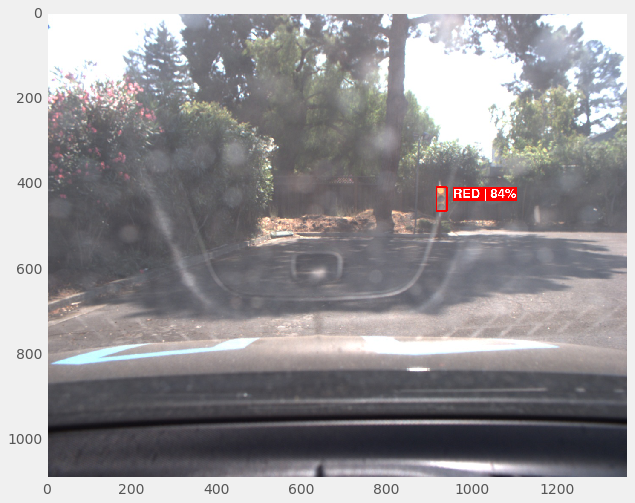

In [33]:
# Load a sample image.
image = Image.open('test/images/test2.jpg')
image_np = np.expand_dims(np.asarray(image, dtype=np.uint8), 0)

tf.reset_default_graph()

with tf.Session(graph=detection_graph) as sess:                
    # Actual detection.
    (boxes, scores, classes) = sess.run([detection_boxes, detection_scores, detection_classes], 
                                        feed_dict={image_tensor: image_np})

    # Remove unnecessary dimensions
    boxes = np.squeeze(boxes)
    scores = np.squeeze(scores)
    classes = np.squeeze(classes)

    confidence_cutoff = 0.5
    # Filter boxes with a confidence score less than `confidence_cutoff`
    boxes, scores, classes = filter_boxes(confidence_cutoff, boxes, scores, classes)

    # The current box coordinates are normalized to a range between 0 and 1.
    # This converts the coordinates to actual location on the image.
    width, height = image.size
    box_coords = to_image_coords(boxes, height, width)

    # Each class with be represented by a differently colored box
    draw_boxes(image, box_coords, classes, scores)

    plt.figure(figsize=(12, 8))
    plt.grid(False)
    plt.imshow(image)

## Timing Detection

The model zoo comes with a variety of models, each its benefits and costs. Below you'll time some of these models. The general tradeoff being sacrificing model accuracy for seconds per frame (SPF).

In [12]:
def time_detection(sess, img_height, img_width, runs=10):
    image_tensor = sess.graph.get_tensor_by_name('image_tensor:0')
    detection_boxes = sess.graph.get_tensor_by_name('detection_boxes:0')
    detection_scores = sess.graph.get_tensor_by_name('detection_scores:0')
    detection_classes = sess.graph.get_tensor_by_name('detection_classes:0')

    # warmup
    gen_image = np.uint8(np.random.randn(1, img_height, img_width, 3))
    sess.run([detection_boxes, detection_scores, detection_classes], feed_dict={image_tensor: gen_image})
    
    times = np.zeros(runs)
    for i in range(runs):
        t0 = time.time()
        sess.run([detection_boxes, detection_scores, detection_classes], feed_dict={image_tensor: image_np})
        t1 = time.time()
        times[i] = (t1 - t0) * 1000
    return times

In [13]:
with tf.Session(graph=detection_graph) as sess:
    times = time_detection(sess, height, width, runs=10)

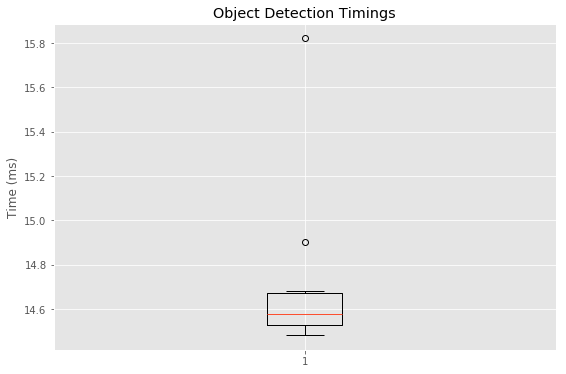

In [14]:
# Create a figure instance
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)
plt.title("Object Detection Timings")
plt.ylabel("Time (ms)")

# Create the boxplot
plt.style.use('fivethirtyeight')
bp = ax.boxplot(times)

### Exercise 4 - Model Tradeoffs

Download a few models from the [model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) and compare the timings.

## Detection on a Video

Finally run your pipeline on [this short video](https://s3-us-west-1.amazonaws.com/udacity-selfdrivingcar/advanced_deep_learning/driving.mp4).

In [15]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [16]:
HTML("""
<video width="960" height="600" controls>
  <source src="{0}" type="video/mp4">
</video>
""".format('run1.mp4'))

### Exercise 5 - Object Detection on a Video

Run an object detection pipeline on the above clip.

In [28]:
clip = VideoFileClip('test/videos/resized.mp4')#.subclip((1,15),(1,20))

In [29]:
# TODO: Complete this function.
# The input is an NumPy array.
# The output should also be a NumPy array.
def pipeline(img):
    image = Image.fromarray(img)
    image_np = np.expand_dims(np.asarray(img, dtype=np.uint8), 0)
    
    with tf.Session(graph=detection_graph) as sess:                
    # Actual detection.
        (boxes, scores, classes) = sess.run([detection_boxes, detection_scores, detection_classes], 
                                        feed_dict={image_tensor: image_np})

        # Remove unnecessary dimensions
        boxes = np.squeeze(boxes)
        scores = np.squeeze(scores)
        classes = np.squeeze(classes)

        confidence_cutoff = 0.5
        # Filter boxes with a confidence score less than `confidence_cutoff`
        boxes, scores, classes = filter_boxes(confidence_cutoff, boxes, scores, classes)

        # The current box coordinates are normalized to a range between 0 and 1.
        # This converts the coordinates actual location on the image.
        width, height = image.size
        box_coords = to_image_coords(boxes, height, width)

        # Each class with be represented by a differently colored box
        draw_boxes(image, box_coords, classes, scores)

        #plt.figure(figsize=(12, 8))
        image = np.asarray(image, dtype=np.uint8)
        return image

In [30]:
with tf.Session(graph=detection_graph) as sess:
    image_tensor = sess.graph.get_tensor_by_name('image_tensor:0')
    detection_boxes = sess.graph.get_tensor_by_name('detection_boxes:0')
    detection_scores = sess.graph.get_tensor_by_name('detection_scores:0')
    detection_classes = sess.graph.get_tensor_by_name('detection_classes:0')
    
    new_clip = clip.fl_image(pipeline)
    
    # write to file
    new_clip.write_videofile('result.mp4')

<class 'numpy.ndarray'>
1440000
(600, 800, 3)

[MoviePy] >>>> Building video result.mp4
[MoviePy] Writing video result.mp4


  0%|          | 1/3304 [00:00<28:58,  1.90it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  0%|          | 2/3304 [00:01<28:20,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  0%|          | 3/3304 [00:01<27:44,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  0%|          | 4/3304 [00:01<27:15,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  0%|          | 5/3304 [00:02<26:45,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  0%|          | 6/3304 [00:02<26:25,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  0%|          | 7/3304 [00:03<26:35,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  0%|          | 8/3304 [00:03<27:03,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  0%|          | 9/3304 [00:04<27:04,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  0%|          | 10/3304 [00:04<27:18,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  0%|          | 11/3304 [00:05<26:42,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  0%|          | 12/3304 [00:05<26:22,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  0%|          | 13/3304 [00:06<26:48,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  0%|          | 14/3304 [00:06<26:21,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  0%|          | 15/3304 [00:07<26:05,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  0%|          | 16/3304 [00:07<26:48,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  1%|          | 17/3304 [00:08<26:26,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  1%|          | 18/3304 [00:08<26:29,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  1%|          | 19/3304 [00:09<27:12,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  1%|          | 20/3304 [00:09<27:00,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  1%|          | 21/3304 [00:10<27:12,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  1%|          | 22/3304 [00:10<27:31,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  1%|          | 23/3304 [00:11<27:27,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  1%|          | 24/3304 [00:11<26:42,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  1%|          | 25/3304 [00:12<27:04,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  1%|          | 26/3304 [00:12<27:10,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  1%|          | 27/3304 [00:13<27:08,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  1%|          | 28/3304 [00:13<27:02,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  1%|          | 29/3304 [00:14<27:16,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  1%|          | 30/3304 [00:14<27:13,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  1%|          | 31/3304 [00:15<27:03,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  1%|          | 32/3304 [00:15<26:57,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  1%|          | 33/3304 [00:16<26:37,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  1%|          | 34/3304 [00:16<26:44,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  1%|          | 35/3304 [00:17<26:25,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  1%|          | 36/3304 [00:17<26:52,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  1%|          | 37/3304 [00:18<26:52,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  1%|          | 38/3304 [00:18<26:35,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  1%|          | 39/3304 [00:19<26:43,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  1%|          | 40/3304 [00:19<26:22,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  1%|          | 41/3304 [00:20<26:17,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  1%|▏         | 42/3304 [00:20<26:30,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  1%|▏         | 43/3304 [00:21<26:19,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  1%|▏         | 44/3304 [00:21<26:12,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  1%|▏         | 45/3304 [00:22<25:56,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  1%|▏         | 46/3304 [00:22<25:54,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  1%|▏         | 47/3304 [00:22<25:48,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  1%|▏         | 48/3304 [00:23<25:45,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  1%|▏         | 49/3304 [00:23<25:42,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  2%|▏         | 50/3304 [00:24<25:34,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  2%|▏         | 51/3304 [00:24<25:38,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  2%|▏         | 52/3304 [00:25<25:40,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  2%|▏         | 53/3304 [00:25<25:30,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  2%|▏         | 54/3304 [00:26<25:19,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  2%|▏         | 55/3304 [00:26<25:26,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  2%|▏         | 56/3304 [00:27<25:22,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  2%|▏         | 57/3304 [00:27<25:30,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  2%|▏         | 58/3304 [00:28<25:36,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  2%|▏         | 59/3304 [00:28<25:33,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  2%|▏         | 60/3304 [00:29<25:29,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  2%|▏         | 61/3304 [00:29<25:43,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  2%|▏         | 62/3304 [00:30<25:59,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  2%|▏         | 63/3304 [00:30<25:46,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  2%|▏         | 64/3304 [00:31<25:41,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  2%|▏         | 65/3304 [00:31<25:35,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  2%|▏         | 66/3304 [00:31<25:25,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  2%|▏         | 67/3304 [00:32<25:25,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  2%|▏         | 68/3304 [00:32<25:30,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  2%|▏         | 69/3304 [00:33<25:28,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  2%|▏         | 70/3304 [00:33<25:27,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  2%|▏         | 71/3304 [00:34<25:38,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  2%|▏         | 72/3304 [00:34<25:28,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  2%|▏         | 73/3304 [00:35<25:29,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  2%|▏         | 74/3304 [00:35<25:31,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  2%|▏         | 75/3304 [00:36<25:30,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  2%|▏         | 76/3304 [00:36<25:25,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  2%|▏         | 77/3304 [00:37<25:22,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  2%|▏         | 78/3304 [00:37<25:12,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  2%|▏         | 79/3304 [00:38<25:18,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  2%|▏         | 80/3304 [00:38<25:18,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  2%|▏         | 81/3304 [00:39<25:14,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  2%|▏         | 82/3304 [00:39<25:21,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  3%|▎         | 83/3304 [00:39<25:35,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  3%|▎         | 84/3304 [00:40<25:39,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  3%|▎         | 85/3304 [00:40<25:49,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  3%|▎         | 86/3304 [00:41<25:56,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  3%|▎         | 87/3304 [00:41<25:58,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  3%|▎         | 88/3304 [00:42<25:59,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  3%|▎         | 89/3304 [00:42<25:46,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  3%|▎         | 90/3304 [00:43<25:58,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  3%|▎         | 91/3304 [00:43<26:07,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  3%|▎         | 92/3304 [00:44<26:20,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  3%|▎         | 93/3304 [00:44<26:11,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  3%|▎         | 94/3304 [00:45<26:08,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  3%|▎         | 95/3304 [00:45<26:07,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  3%|▎         | 96/3304 [00:46<25:59,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  3%|▎         | 97/3304 [00:46<25:48,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  3%|▎         | 98/3304 [00:47<25:43,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  3%|▎         | 99/3304 [00:47<25:35,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  3%|▎         | 100/3304 [00:48<25:33,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  3%|▎         | 101/3304 [00:48<26:09,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  3%|▎         | 102/3304 [00:49<25:58,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  3%|▎         | 103/3304 [00:49<26:18,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  3%|▎         | 104/3304 [00:50<26:18,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  3%|▎         | 105/3304 [00:50<26:22,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  3%|▎         | 106/3304 [00:51<26:22,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  3%|▎         | 107/3304 [00:51<25:59,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  3%|▎         | 108/3304 [00:52<25:54,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  3%|▎         | 109/3304 [00:52<26:10,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  3%|▎         | 110/3304 [00:53<26:08,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  3%|▎         | 111/3304 [00:53<25:59,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  3%|▎         | 112/3304 [00:54<26:36,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  3%|▎         | 113/3304 [00:54<26:40,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  3%|▎         | 114/3304 [00:55<26:38,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  3%|▎         | 115/3304 [00:55<26:43,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  4%|▎         | 116/3304 [00:56<26:38,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  4%|▎         | 117/3304 [00:56<26:39,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  4%|▎         | 118/3304 [00:57<26:29,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  4%|▎         | 119/3304 [00:57<26:20,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  4%|▎         | 120/3304 [00:58<26:27,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  4%|▎         | 121/3304 [00:58<26:00,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  4%|▎         | 122/3304 [00:59<25:45,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  4%|▎         | 123/3304 [00:59<26:07,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  4%|▍         | 124/3304 [01:00<26:10,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  4%|▍         | 125/3304 [01:00<25:59,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  4%|▍         | 126/3304 [01:01<25:41,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  4%|▍         | 127/3304 [01:01<26:07,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  4%|▍         | 128/3304 [01:02<26:14,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  4%|▍         | 129/3304 [01:02<26:13,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  4%|▍         | 130/3304 [01:03<26:35,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  4%|▍         | 131/3304 [01:03<26:33,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  4%|▍         | 132/3304 [01:04<26:19,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  4%|▍         | 133/3304 [01:04<26:37,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  4%|▍         | 134/3304 [01:05<26:23,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  4%|▍         | 135/3304 [01:05<26:26,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  4%|▍         | 136/3304 [01:06<26:30,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  4%|▍         | 137/3304 [01:06<26:39,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  4%|▍         | 138/3304 [01:07<26:23,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  4%|▍         | 139/3304 [01:07<26:32,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  4%|▍         | 140/3304 [01:08<26:12,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  4%|▍         | 141/3304 [01:08<25:56,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  4%|▍         | 142/3304 [01:09<26:01,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  4%|▍         | 143/3304 [01:09<27:03,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  4%|▍         | 144/3304 [01:10<27:34,  1.91it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  4%|▍         | 145/3304 [01:10<27:23,  1.92it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  4%|▍         | 146/3304 [01:11<27:10,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  4%|▍         | 147/3304 [01:11<27:00,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  4%|▍         | 148/3304 [01:12<26:56,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  5%|▍         | 149/3304 [01:12<26:36,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  5%|▍         | 150/3304 [01:13<26:01,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  5%|▍         | 151/3304 [01:13<25:34,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  5%|▍         | 152/3304 [01:14<25:12,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  5%|▍         | 153/3304 [01:14<25:02,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  5%|▍         | 154/3304 [01:15<24:53,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  5%|▍         | 155/3304 [01:15<24:44,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  5%|▍         | 156/3304 [01:15<24:39,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  5%|▍         | 157/3304 [01:16<24:49,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  5%|▍         | 158/3304 [01:16<24:56,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  5%|▍         | 159/3304 [01:17<24:50,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  5%|▍         | 160/3304 [01:17<24:52,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  5%|▍         | 161/3304 [01:18<24:39,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  5%|▍         | 162/3304 [01:18<24:54,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  5%|▍         | 163/3304 [01:19<24:44,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  5%|▍         | 164/3304 [01:19<24:50,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  5%|▍         | 165/3304 [01:20<24:32,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  5%|▌         | 166/3304 [01:20<24:39,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  5%|▌         | 167/3304 [01:21<25:19,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  5%|▌         | 168/3304 [01:21<25:44,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  5%|▌         | 169/3304 [01:22<26:09,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  5%|▌         | 170/3304 [01:22<26:30,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  5%|▌         | 171/3304 [01:23<26:14,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  5%|▌         | 172/3304 [01:23<25:52,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  5%|▌         | 173/3304 [01:24<26:07,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  5%|▌         | 174/3304 [01:24<25:42,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  5%|▌         | 175/3304 [01:25<25:21,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  5%|▌         | 176/3304 [01:25<25:18,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  5%|▌         | 177/3304 [01:26<26:05,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  5%|▌         | 178/3304 [01:26<26:20,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  5%|▌         | 179/3304 [01:27<25:53,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  5%|▌         | 180/3304 [01:27<26:17,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  5%|▌         | 181/3304 [01:28<26:17,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  6%|▌         | 182/3304 [01:28<25:58,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  6%|▌         | 183/3304 [01:29<26:16,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  6%|▌         | 184/3304 [01:29<25:48,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  6%|▌         | 185/3304 [01:30<26:15,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  6%|▌         | 186/3304 [01:30<26:01,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  6%|▌         | 187/3304 [01:31<25:40,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  6%|▌         | 188/3304 [01:31<25:12,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  6%|▌         | 189/3304 [01:32<24:54,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  6%|▌         | 190/3304 [01:32<24:38,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  6%|▌         | 191/3304 [01:33<24:33,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  6%|▌         | 192/3304 [01:33<24:33,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  6%|▌         | 193/3304 [01:34<24:22,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  6%|▌         | 194/3304 [01:34<24:24,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  6%|▌         | 195/3304 [01:34<24:22,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  6%|▌         | 196/3304 [01:35<25:08,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  6%|▌         | 197/3304 [01:36<25:43,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  6%|▌         | 198/3304 [01:36<25:48,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  6%|▌         | 199/3304 [01:37<25:58,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  6%|▌         | 200/3304 [01:37<26:03,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  6%|▌         | 201/3304 [01:38<26:16,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  6%|▌         | 202/3304 [01:38<26:18,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  6%|▌         | 203/3304 [01:39<26:15,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  6%|▌         | 204/3304 [01:39<26:15,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  6%|▌         | 205/3304 [01:40<26:21,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  6%|▌         | 206/3304 [01:40<25:49,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  6%|▋         | 207/3304 [01:41<25:18,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  6%|▋         | 208/3304 [01:41<24:59,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  6%|▋         | 209/3304 [01:41<24:39,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  6%|▋         | 210/3304 [01:42<24:37,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  6%|▋         | 211/3304 [01:43<25:40,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  6%|▋         | 212/3304 [01:43<25:55,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  6%|▋         | 213/3304 [01:44<26:08,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  6%|▋         | 214/3304 [01:44<26:15,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  7%|▋         | 215/3304 [01:45<26:15,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  7%|▋         | 216/3304 [01:45<26:24,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  7%|▋         | 217/3304 [01:46<26:41,  1.93it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  7%|▋         | 218/3304 [01:46<25:56,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  7%|▋         | 219/3304 [01:47<25:27,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  7%|▋         | 220/3304 [01:47<25:34,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  7%|▋         | 221/3304 [01:48<25:34,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  7%|▋         | 222/3304 [01:48<25:47,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  7%|▋         | 223/3304 [01:49<25:42,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  7%|▋         | 224/3304 [01:49<25:29,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  7%|▋         | 225/3304 [01:50<25:34,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  7%|▋         | 226/3304 [01:50<25:57,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  7%|▋         | 227/3304 [01:51<26:09,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  7%|▋         | 228/3304 [01:51<26:10,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  7%|▋         | 229/3304 [01:52<26:09,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  7%|▋         | 230/3304 [01:52<25:27,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  7%|▋         | 231/3304 [01:53<24:57,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  7%|▋         | 232/3304 [01:53<24:33,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  7%|▋         | 233/3304 [01:53<24:20,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  7%|▋         | 234/3304 [01:54<24:14,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  7%|▋         | 235/3304 [01:54<24:46,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  7%|▋         | 236/3304 [01:55<25:13,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  7%|▋         | 237/3304 [01:55<25:35,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  7%|▋         | 238/3304 [01:56<25:44,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  7%|▋         | 239/3304 [01:57<25:46,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  7%|▋         | 240/3304 [01:57<25:48,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  7%|▋         | 241/3304 [01:58<26:06,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  7%|▋         | 242/3304 [01:58<25:53,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  7%|▋         | 243/3304 [01:59<26:02,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  7%|▋         | 244/3304 [01:59<26:03,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  7%|▋         | 245/3304 [02:00<25:31,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  7%|▋         | 246/3304 [02:00<24:56,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  7%|▋         | 247/3304 [02:00<24:55,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  8%|▊         | 248/3304 [02:01<24:56,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  8%|▊         | 249/3304 [02:01<24:46,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  8%|▊         | 250/3304 [02:02<24:31,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  8%|▊         | 251/3304 [02:02<24:28,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  8%|▊         | 252/3304 [02:03<24:32,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  8%|▊         | 253/3304 [02:03<24:36,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  8%|▊         | 254/3304 [02:04<24:17,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  8%|▊         | 255/3304 [02:04<24:11,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  8%|▊         | 256/3304 [02:05<24:08,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  8%|▊         | 257/3304 [02:05<24:27,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  8%|▊         | 258/3304 [02:06<25:03,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  8%|▊         | 259/3304 [02:06<25:19,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  8%|▊         | 260/3304 [02:07<25:33,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  8%|▊         | 261/3304 [02:07<24:57,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  8%|▊         | 262/3304 [02:08<24:35,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  8%|▊         | 263/3304 [02:08<25:03,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  8%|▊         | 264/3304 [02:09<25:08,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  8%|▊         | 265/3304 [02:09<25:34,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  8%|▊         | 266/3304 [02:10<25:57,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  8%|▊         | 267/3304 [02:10<25:50,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  8%|▊         | 268/3304 [02:11<25:23,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  8%|▊         | 269/3304 [02:11<25:06,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  8%|▊         | 270/3304 [02:12<24:53,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  8%|▊         | 271/3304 [02:12<25:33,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  8%|▊         | 272/3304 [02:13<25:36,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  8%|▊         | 273/3304 [02:13<25:07,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  8%|▊         | 274/3304 [02:14<25:13,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  8%|▊         | 275/3304 [02:14<24:43,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  8%|▊         | 276/3304 [02:15<25:07,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  8%|▊         | 277/3304 [02:15<24:46,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  8%|▊         | 278/3304 [02:16<24:31,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  8%|▊         | 279/3304 [02:16<24:57,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  8%|▊         | 280/3304 [02:17<25:28,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  9%|▊         | 281/3304 [02:17<25:20,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  9%|▊         | 282/3304 [02:18<24:52,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  9%|▊         | 283/3304 [02:18<24:30,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  9%|▊         | 284/3304 [02:19<24:28,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  9%|▊         | 285/3304 [02:19<25:05,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  9%|▊         | 286/3304 [02:20<24:42,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  9%|▊         | 287/3304 [02:20<24:32,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  9%|▊         | 288/3304 [02:21<24:15,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  9%|▊         | 289/3304 [02:21<23:57,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  9%|▉         | 290/3304 [02:22<23:39,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  9%|▉         | 291/3304 [02:22<23:34,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  9%|▉         | 292/3304 [02:23<23:30,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  9%|▉         | 293/3304 [02:23<23:25,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  9%|▉         | 294/3304 [02:23<23:42,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  9%|▉         | 295/3304 [02:24<23:36,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  9%|▉         | 296/3304 [02:24<23:28,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  9%|▉         | 297/3304 [02:25<23:20,  2.15it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  9%|▉         | 298/3304 [02:25<23:14,  2.16it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  9%|▉         | 299/3304 [02:26<23:09,  2.16it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  9%|▉         | 300/3304 [02:26<23:14,  2.15it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  9%|▉         | 301/3304 [02:27<23:12,  2.16it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  9%|▉         | 302/3304 [02:27<23:29,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  9%|▉         | 303/3304 [02:28<23:15,  2.15it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  9%|▉         | 304/3304 [02:28<23:09,  2.16it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  9%|▉         | 305/3304 [02:29<23:10,  2.16it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  9%|▉         | 306/3304 [02:29<23:12,  2.15it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  9%|▉         | 307/3304 [02:30<23:07,  2.16it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  9%|▉         | 308/3304 [02:30<23:10,  2.15it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  9%|▉         | 309/3304 [02:30<23:08,  2.16it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  9%|▉         | 310/3304 [02:31<23:05,  2.16it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  9%|▉         | 311/3304 [02:31<23:05,  2.16it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  9%|▉         | 312/3304 [02:32<22:59,  2.17it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



  9%|▉         | 313/3304 [02:32<23:11,  2.15it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 10%|▉         | 314/3304 [02:33<23:14,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 10%|▉         | 315/3304 [02:33<23:15,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 10%|▉         | 316/3304 [02:34<23:06,  2.16it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 10%|▉         | 317/3304 [02:34<23:12,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 10%|▉         | 318/3304 [02:35<23:22,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 10%|▉         | 319/3304 [02:35<23:50,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 10%|▉         | 320/3304 [02:36<24:25,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 10%|▉         | 321/3304 [02:36<24:46,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 10%|▉         | 322/3304 [02:37<24:51,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 10%|▉         | 323/3304 [02:37<24:28,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 10%|▉         | 324/3304 [02:38<24:54,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 10%|▉         | 325/3304 [02:38<24:36,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 10%|▉         | 326/3304 [02:39<24:48,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 10%|▉         | 327/3304 [02:39<24:43,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 10%|▉         | 328/3304 [02:40<24:27,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 10%|▉         | 329/3304 [02:40<24:57,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 10%|▉         | 330/3304 [02:41<25:24,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 10%|█         | 331/3304 [02:41<25:31,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 10%|█         | 332/3304 [02:42<25:27,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 10%|█         | 333/3304 [02:42<24:40,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 10%|█         | 334/3304 [02:43<24:19,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 10%|█         | 335/3304 [02:43<24:09,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 10%|█         | 336/3304 [02:44<24:28,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 10%|█         | 337/3304 [02:44<24:37,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 10%|█         | 338/3304 [02:45<24:46,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 10%|█         | 339/3304 [02:45<24:36,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 10%|█         | 340/3304 [02:46<24:40,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 10%|█         | 341/3304 [02:46<24:43,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 10%|█         | 342/3304 [02:47<24:19,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 10%|█         | 343/3304 [02:47<24:15,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 10%|█         | 344/3304 [02:48<25:04,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 10%|█         | 345/3304 [02:48<25:42,  1.92it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 10%|█         | 346/3304 [02:49<25:59,  1.90it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 11%|█         | 347/3304 [02:49<25:59,  1.90it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 11%|█         | 348/3304 [02:50<25:05,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 11%|█         | 349/3304 [02:50<24:32,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 11%|█         | 350/3304 [02:51<25:12,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 11%|█         | 351/3304 [02:51<24:49,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 11%|█         | 352/3304 [02:52<24:41,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 11%|█         | 353/3304 [02:52<24:53,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 11%|█         | 354/3304 [02:53<25:01,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 11%|█         | 355/3304 [02:53<24:44,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 11%|█         | 356/3304 [02:54<25:12,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 11%|█         | 357/3304 [02:54<25:28,  1.93it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 11%|█         | 358/3304 [02:55<25:42,  1.91it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 11%|█         | 359/3304 [02:55<25:43,  1.91it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 11%|█         | 360/3304 [02:56<25:34,  1.92it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 11%|█         | 361/3304 [02:56<24:58,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 11%|█         | 362/3304 [02:57<25:11,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 11%|█         | 363/3304 [02:57<24:51,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 11%|█         | 364/3304 [02:58<24:58,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 11%|█         | 365/3304 [02:58<24:37,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 11%|█         | 366/3304 [02:59<24:41,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 11%|█         | 367/3304 [02:59<24:47,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 11%|█         | 368/3304 [03:00<24:24,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 11%|█         | 369/3304 [03:00<24:34,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 11%|█         | 370/3304 [03:01<24:42,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 11%|█         | 371/3304 [03:01<24:13,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 11%|█▏        | 372/3304 [03:02<23:47,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 11%|█▏        | 373/3304 [03:02<23:40,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 11%|█▏        | 374/3304 [03:03<24:04,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 11%|█▏        | 375/3304 [03:03<24:17,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 11%|█▏        | 376/3304 [03:04<23:48,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 11%|█▏        | 377/3304 [03:04<23:42,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 11%|█▏        | 378/3304 [03:05<23:53,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 11%|█▏        | 379/3304 [03:05<24:23,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 12%|█▏        | 380/3304 [03:06<24:43,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 12%|█▏        | 381/3304 [03:06<24:38,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 12%|█▏        | 382/3304 [03:07<24:23,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 12%|█▏        | 383/3304 [03:07<24:02,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 12%|█▏        | 384/3304 [03:08<23:36,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 12%|█▏        | 385/3304 [03:08<24:01,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 12%|█▏        | 386/3304 [03:09<24:29,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 12%|█▏        | 387/3304 [03:09<24:02,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 12%|█▏        | 388/3304 [03:10<23:59,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 12%|█▏        | 389/3304 [03:10<24:20,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 12%|█▏        | 390/3304 [03:11<24:24,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 12%|█▏        | 391/3304 [03:11<24:48,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 12%|█▏        | 392/3304 [03:12<24:47,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 12%|█▏        | 393/3304 [03:12<24:40,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 12%|█▏        | 394/3304 [03:13<24:18,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 12%|█▏        | 395/3304 [03:13<24:36,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 12%|█▏        | 396/3304 [03:14<24:54,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 12%|█▏        | 397/3304 [03:14<24:54,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 12%|█▏        | 398/3304 [03:15<24:30,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 12%|█▏        | 399/3304 [03:15<24:29,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 12%|█▏        | 400/3304 [03:16<23:48,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 12%|█▏        | 401/3304 [03:16<23:43,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 12%|█▏        | 402/3304 [03:17<23:13,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 12%|█▏        | 403/3304 [03:17<23:27,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 12%|█▏        | 404/3304 [03:18<24:00,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 12%|█▏        | 405/3304 [03:18<24:14,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 12%|█▏        | 406/3304 [03:19<24:18,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 12%|█▏        | 407/3304 [03:19<24:12,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 12%|█▏        | 408/3304 [03:20<23:36,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 12%|█▏        | 409/3304 [03:20<23:44,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 12%|█▏        | 410/3304 [03:21<23:45,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 12%|█▏        | 411/3304 [03:21<23:33,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 12%|█▏        | 412/3304 [03:22<23:11,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 12%|█▎        | 413/3304 [03:22<22:54,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 13%|█▎        | 414/3304 [03:23<22:44,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 13%|█▎        | 415/3304 [03:23<22:43,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 13%|█▎        | 416/3304 [03:24<22:36,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 13%|█▎        | 417/3304 [03:24<22:28,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 13%|█▎        | 418/3304 [03:25<22:40,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 13%|█▎        | 419/3304 [03:25<22:50,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 13%|█▎        | 420/3304 [03:26<22:57,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 13%|█▎        | 421/3304 [03:26<23:04,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 13%|█▎        | 422/3304 [03:27<22:59,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 13%|█▎        | 423/3304 [03:27<22:50,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 13%|█▎        | 424/3304 [03:27<22:38,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 13%|█▎        | 425/3304 [03:28<22:29,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 13%|█▎        | 426/3304 [03:28<22:23,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 13%|█▎        | 427/3304 [03:29<22:18,  2.15it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 13%|█▎        | 428/3304 [03:29<22:25,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 13%|█▎        | 429/3304 [03:30<22:24,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 13%|█▎        | 430/3304 [03:30<22:23,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 13%|█▎        | 431/3304 [03:31<22:19,  2.15it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 13%|█▎        | 432/3304 [03:31<22:14,  2.15it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 13%|█▎        | 433/3304 [03:32<22:25,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 13%|█▎        | 434/3304 [03:32<22:16,  2.15it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 13%|█▎        | 435/3304 [03:33<22:17,  2.15it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 13%|█▎        | 436/3304 [03:33<22:23,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 13%|█▎        | 437/3304 [03:34<22:33,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 13%|█▎        | 438/3304 [03:34<23:01,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 13%|█▎        | 439/3304 [03:35<23:17,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 13%|█▎        | 440/3304 [03:35<23:26,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 13%|█▎        | 441/3304 [03:36<23:38,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 13%|█▎        | 442/3304 [03:36<24:16,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 13%|█▎        | 443/3304 [03:37<24:18,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 13%|█▎        | 444/3304 [03:37<24:08,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 13%|█▎        | 445/3304 [03:38<24:13,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 13%|█▎        | 446/3304 [03:38<24:23,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 14%|█▎        | 447/3304 [03:39<24:18,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 14%|█▎        | 448/3304 [03:39<24:00,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 14%|█▎        | 449/3304 [03:40<23:51,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 14%|█▎        | 450/3304 [03:40<23:43,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 14%|█▎        | 451/3304 [03:41<23:50,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 14%|█▎        | 452/3304 [03:41<23:43,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 14%|█▎        | 453/3304 [03:42<24:00,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 14%|█▎        | 454/3304 [03:42<23:54,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 14%|█▍        | 455/3304 [03:43<24:25,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 14%|█▍        | 456/3304 [03:43<24:16,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 14%|█▍        | 457/3304 [03:44<23:52,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 14%|█▍        | 458/3304 [03:44<23:48,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 14%|█▍        | 459/3304 [03:45<23:39,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 14%|█▍        | 460/3304 [03:45<23:28,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 14%|█▍        | 461/3304 [03:46<23:54,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 14%|█▍        | 462/3304 [03:46<23:28,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 14%|█▍        | 463/3304 [03:47<23:14,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 14%|█▍        | 464/3304 [03:47<23:20,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 14%|█▍        | 465/3304 [03:48<24:07,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 14%|█▍        | 466/3304 [03:48<24:23,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 14%|█▍        | 467/3304 [03:49<24:07,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 14%|█▍        | 468/3304 [03:49<24:40,  1.92it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 14%|█▍        | 469/3304 [03:50<24:13,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 14%|█▍        | 470/3304 [03:50<24:15,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 14%|█▍        | 471/3304 [03:51<24:21,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 14%|█▍        | 472/3304 [03:51<23:53,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 14%|█▍        | 473/3304 [03:52<23:54,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 14%|█▍        | 474/3304 [03:52<23:55,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 14%|█▍        | 475/3304 [03:53<24:24,  1.93it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 14%|█▍        | 476/3304 [03:53<24:26,  1.93it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 14%|█▍        | 477/3304 [03:54<23:55,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 14%|█▍        | 478/3304 [03:54<23:42,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 14%|█▍        | 479/3304 [03:55<23:28,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 15%|█▍        | 480/3304 [03:55<23:06,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 15%|█▍        | 481/3304 [03:56<22:48,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 15%|█▍        | 482/3304 [03:56<22:47,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 15%|█▍        | 483/3304 [03:57<22:45,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 15%|█▍        | 484/3304 [03:57<23:09,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 15%|█▍        | 485/3304 [03:58<22:57,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 15%|█▍        | 486/3304 [03:58<22:52,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 15%|█▍        | 487/3304 [03:59<22:56,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 15%|█▍        | 488/3304 [03:59<22:59,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 15%|█▍        | 489/3304 [04:00<22:44,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 15%|█▍        | 490/3304 [04:00<22:42,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 15%|█▍        | 491/3304 [04:01<22:49,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 15%|█▍        | 492/3304 [04:01<22:34,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 15%|█▍        | 493/3304 [04:02<22:31,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 15%|█▍        | 494/3304 [04:02<22:20,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 15%|█▍        | 495/3304 [04:03<22:58,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 15%|█▌        | 496/3304 [04:03<23:15,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 15%|█▌        | 497/3304 [04:04<23:04,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 15%|█▌        | 498/3304 [04:04<23:14,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 15%|█▌        | 499/3304 [04:05<22:47,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 15%|█▌        | 500/3304 [04:05<22:29,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 15%|█▌        | 501/3304 [04:05<22:24,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 15%|█▌        | 502/3304 [04:06<22:13,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 15%|█▌        | 503/3304 [04:06<22:09,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 15%|█▌        | 504/3304 [04:07<22:17,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 15%|█▌        | 505/3304 [04:07<22:18,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 15%|█▌        | 506/3304 [04:08<22:17,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 15%|█▌        | 507/3304 [04:08<22:19,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 15%|█▌        | 508/3304 [04:09<22:27,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 15%|█▌        | 509/3304 [04:09<22:16,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 15%|█▌        | 510/3304 [04:10<22:12,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 15%|█▌        | 511/3304 [04:10<22:05,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 15%|█▌        | 512/3304 [04:11<21:58,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 16%|█▌        | 513/3304 [04:11<21:54,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 16%|█▌        | 514/3304 [04:12<21:48,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 16%|█▌        | 515/3304 [04:12<21:50,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 16%|█▌        | 516/3304 [04:13<22:19,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 16%|█▌        | 517/3304 [04:13<22:48,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 16%|█▌        | 518/3304 [04:14<22:35,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 16%|█▌        | 519/3304 [04:14<22:32,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 16%|█▌        | 520/3304 [04:15<22:33,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 16%|█▌        | 521/3304 [04:15<23:02,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 16%|█▌        | 522/3304 [04:16<22:55,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 16%|█▌        | 523/3304 [04:16<23:15,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 16%|█▌        | 524/3304 [04:17<23:27,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 16%|█▌        | 525/3304 [04:17<22:57,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 16%|█▌        | 526/3304 [04:18<22:35,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 16%|█▌        | 527/3304 [04:18<22:27,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 16%|█▌        | 528/3304 [04:19<22:34,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 16%|█▌        | 529/3304 [04:19<22:45,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 16%|█▌        | 530/3304 [04:20<23:20,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 16%|█▌        | 531/3304 [04:20<23:45,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 16%|█▌        | 532/3304 [04:21<23:28,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 16%|█▌        | 533/3304 [04:21<23:23,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 16%|█▌        | 534/3304 [04:22<23:18,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 16%|█▌        | 535/3304 [04:22<23:18,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 16%|█▌        | 536/3304 [04:23<23:19,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 16%|█▋        | 537/3304 [04:23<23:05,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 16%|█▋        | 538/3304 [04:24<23:01,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 16%|█▋        | 539/3304 [04:24<22:48,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 16%|█▋        | 540/3304 [04:25<22:26,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 16%|█▋        | 541/3304 [04:25<22:29,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 16%|█▋        | 542/3304 [04:26<22:13,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 16%|█▋        | 543/3304 [04:26<21:57,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 16%|█▋        | 544/3304 [04:26<21:47,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 16%|█▋        | 545/3304 [04:27<22:00,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 17%|█▋        | 546/3304 [04:27<22:21,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 17%|█▋        | 547/3304 [04:28<22:20,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 17%|█▋        | 548/3304 [04:28<22:22,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 17%|█▋        | 549/3304 [04:29<22:23,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 17%|█▋        | 550/3304 [04:29<22:19,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 17%|█▋        | 551/3304 [04:30<22:14,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 17%|█▋        | 552/3304 [04:30<22:08,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 17%|█▋        | 553/3304 [04:31<21:58,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 17%|█▋        | 554/3304 [04:31<21:56,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 17%|█▋        | 555/3304 [04:32<22:08,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 17%|█▋        | 556/3304 [04:32<22:15,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 17%|█▋        | 557/3304 [04:33<22:05,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 17%|█▋        | 558/3304 [04:33<21:59,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 17%|█▋        | 559/3304 [04:34<22:34,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 17%|█▋        | 560/3304 [04:34<22:38,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 17%|█▋        | 561/3304 [04:35<23:02,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 17%|█▋        | 562/3304 [04:35<22:39,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 17%|█▋        | 563/3304 [04:36<22:33,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 17%|█▋        | 564/3304 [04:36<22:25,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 17%|█▋        | 565/3304 [04:37<22:21,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 17%|█▋        | 566/3304 [04:37<22:27,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 17%|█▋        | 567/3304 [04:38<22:28,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 17%|█▋        | 568/3304 [04:38<22:13,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 17%|█▋        | 569/3304 [04:39<22:29,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 17%|█▋        | 570/3304 [04:39<22:14,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 17%|█▋        | 571/3304 [04:40<21:51,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 17%|█▋        | 572/3304 [04:40<21:51,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 17%|█▋        | 573/3304 [04:41<22:03,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 17%|█▋        | 574/3304 [04:41<22:04,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 17%|█▋        | 575/3304 [04:42<21:49,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 17%|█▋        | 576/3304 [04:42<21:36,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 17%|█▋        | 577/3304 [04:42<21:29,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 17%|█▋        | 578/3304 [04:43<21:24,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 18%|█▊        | 579/3304 [04:43<21:53,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 18%|█▊        | 580/3304 [04:44<22:12,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 18%|█▊        | 581/3304 [04:44<22:06,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 18%|█▊        | 582/3304 [04:45<22:20,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 18%|█▊        | 583/3304 [04:45<22:37,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 18%|█▊        | 584/3304 [04:46<23:07,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 18%|█▊        | 585/3304 [04:47<23:50,  1.90it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 18%|█▊        | 586/3304 [04:47<24:25,  1.85it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 18%|█▊        | 587/3304 [04:48<24:01,  1.88it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 18%|█▊        | 588/3304 [04:48<23:16,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 18%|█▊        | 589/3304 [04:49<23:01,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 18%|█▊        | 590/3304 [04:49<23:02,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 18%|█▊        | 591/3304 [04:50<22:51,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 18%|█▊        | 592/3304 [04:50<22:37,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 18%|█▊        | 593/3304 [04:51<22:31,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 18%|█▊        | 594/3304 [04:51<22:33,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 18%|█▊        | 595/3304 [04:52<22:28,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 18%|█▊        | 596/3304 [04:52<22:37,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 18%|█▊        | 597/3304 [04:53<22:30,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 18%|█▊        | 598/3304 [04:53<22:22,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 18%|█▊        | 599/3304 [04:54<22:06,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 18%|█▊        | 600/3304 [04:54<21:43,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 18%|█▊        | 601/3304 [04:55<21:35,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 18%|█▊        | 602/3304 [04:55<21:20,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 18%|█▊        | 603/3304 [04:55<21:15,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 18%|█▊        | 604/3304 [04:56<21:09,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 18%|█▊        | 605/3304 [04:56<21:11,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 18%|█▊        | 606/3304 [04:57<21:03,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 18%|█▊        | 607/3304 [04:57<20:58,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 18%|█▊        | 608/3304 [04:58<21:03,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 18%|█▊        | 609/3304 [04:58<20:56,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 18%|█▊        | 610/3304 [04:59<20:52,  2.15it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 18%|█▊        | 611/3304 [04:59<20:46,  2.16it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 19%|█▊        | 612/3304 [05:00<20:46,  2.16it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 19%|█▊        | 613/3304 [05:00<20:45,  2.16it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 19%|█▊        | 614/3304 [05:01<20:46,  2.16it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 19%|█▊        | 615/3304 [05:01<20:51,  2.15it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 19%|█▊        | 616/3304 [05:01<20:51,  2.15it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 19%|█▊        | 617/3304 [05:02<20:48,  2.15it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 19%|█▊        | 618/3304 [05:02<20:49,  2.15it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 19%|█▊        | 619/3304 [05:03<20:48,  2.15it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 19%|█▉        | 620/3304 [05:03<20:51,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 19%|█▉        | 621/3304 [05:04<20:48,  2.15it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 19%|█▉        | 622/3304 [05:04<20:48,  2.15it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 19%|█▉        | 623/3304 [05:05<20:47,  2.15it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 19%|█▉        | 624/3304 [05:05<20:48,  2.15it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 19%|█▉        | 625/3304 [05:06<20:48,  2.15it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 19%|█▉        | 626/3304 [05:06<20:46,  2.15it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 19%|█▉        | 627/3304 [05:07<20:44,  2.15it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 19%|█▉        | 628/3304 [05:07<20:41,  2.16it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 19%|█▉        | 629/3304 [05:08<20:42,  2.15it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 19%|█▉        | 630/3304 [05:08<20:48,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 19%|█▉        | 631/3304 [05:09<21:22,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 19%|█▉        | 632/3304 [05:09<21:54,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 19%|█▉        | 633/3304 [05:10<22:28,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 19%|█▉        | 634/3304 [05:10<22:48,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 19%|█▉        | 635/3304 [05:11<22:38,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 19%|█▉        | 636/3304 [05:11<22:34,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 19%|█▉        | 637/3304 [05:12<22:08,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 19%|█▉        | 638/3304 [05:12<21:42,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 19%|█▉        | 639/3304 [05:13<21:44,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 19%|█▉        | 640/3304 [05:13<22:20,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 19%|█▉        | 641/3304 [05:14<22:13,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 19%|█▉        | 642/3304 [05:14<22:07,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 19%|█▉        | 643/3304 [05:15<22:06,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 19%|█▉        | 644/3304 [05:15<22:02,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 20%|█▉        | 645/3304 [05:16<21:50,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 20%|█▉        | 646/3304 [05:16<21:59,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 20%|█▉        | 647/3304 [05:17<21:44,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 20%|█▉        | 648/3304 [05:17<21:36,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 20%|█▉        | 649/3304 [05:17<21:35,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 20%|█▉        | 650/3304 [05:18<21:32,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 20%|█▉        | 651/3304 [05:18<22:09,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 20%|█▉        | 652/3304 [05:19<22:09,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 20%|█▉        | 653/3304 [05:20<22:21,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 20%|█▉        | 654/3304 [05:20<22:11,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 20%|█▉        | 655/3304 [05:20<21:51,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 20%|█▉        | 656/3304 [05:21<22:10,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 20%|█▉        | 657/3304 [05:22<22:38,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 20%|█▉        | 658/3304 [05:22<22:38,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 20%|█▉        | 659/3304 [05:23<22:17,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 20%|█▉        | 660/3304 [05:23<21:48,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 20%|██        | 661/3304 [05:23<21:31,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 20%|██        | 662/3304 [05:24<21:18,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 20%|██        | 663/3304 [05:24<21:32,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 20%|██        | 664/3304 [05:25<21:26,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 20%|██        | 665/3304 [05:25<21:48,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 20%|██        | 666/3304 [05:26<22:23,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 20%|██        | 667/3304 [05:27<22:31,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 20%|██        | 668/3304 [05:27<22:52,  1.92it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 20%|██        | 669/3304 [05:28<22:59,  1.91it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 20%|██        | 670/3304 [05:28<22:31,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 20%|██        | 671/3304 [05:29<22:40,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 20%|██        | 672/3304 [05:29<22:21,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 20%|██        | 673/3304 [05:30<21:55,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 20%|██        | 674/3304 [05:30<21:51,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 20%|██        | 675/3304 [05:31<22:09,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 20%|██        | 676/3304 [05:31<22:16,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 20%|██        | 677/3304 [05:32<21:44,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 21%|██        | 678/3304 [05:32<21:52,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 21%|██        | 679/3304 [05:33<22:07,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 21%|██        | 680/3304 [05:33<21:58,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 21%|██        | 681/3304 [05:34<21:29,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 21%|██        | 682/3304 [05:34<21:06,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 21%|██        | 683/3304 [05:34<20:51,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 21%|██        | 684/3304 [05:35<20:41,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 21%|██        | 685/3304 [05:35<20:32,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 21%|██        | 686/3304 [05:36<20:29,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 21%|██        | 687/3304 [05:36<20:35,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 21%|██        | 688/3304 [05:37<20:59,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 21%|██        | 689/3304 [05:37<21:09,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 21%|██        | 690/3304 [05:38<21:17,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 21%|██        | 691/3304 [05:38<21:24,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 21%|██        | 692/3304 [05:39<21:06,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 21%|██        | 693/3304 [05:39<20:52,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 21%|██        | 694/3304 [05:40<20:40,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 21%|██        | 695/3304 [05:40<20:32,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 21%|██        | 696/3304 [05:41<20:23,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 21%|██        | 697/3304 [05:41<20:25,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 21%|██        | 698/3304 [05:42<20:23,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 21%|██        | 699/3304 [05:42<20:19,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 21%|██        | 700/3304 [05:43<20:16,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 21%|██        | 701/3304 [05:43<20:12,  2.15it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 21%|██        | 702/3304 [05:43<20:13,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 21%|██▏       | 703/3304 [05:44<20:09,  2.15it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 21%|██▏       | 704/3304 [05:44<20:07,  2.15it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 21%|██▏       | 705/3304 [05:45<20:09,  2.15it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 21%|██▏       | 706/3304 [05:45<20:10,  2.15it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 21%|██▏       | 707/3304 [05:46<20:09,  2.15it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 21%|██▏       | 708/3304 [05:46<20:09,  2.15it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 21%|██▏       | 709/3304 [05:47<20:10,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 21%|██▏       | 710/3304 [05:47<20:27,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 22%|██▏       | 711/3304 [05:48<20:53,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 22%|██▏       | 712/3304 [05:48<21:12,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 22%|██▏       | 713/3304 [05:49<20:59,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 22%|██▏       | 714/3304 [05:49<20:42,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 22%|██▏       | 715/3304 [05:50<20:30,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 22%|██▏       | 716/3304 [05:50<20:25,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 22%|██▏       | 717/3304 [05:51<20:22,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 22%|██▏       | 718/3304 [05:51<20:20,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 22%|██▏       | 719/3304 [05:52<20:15,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 22%|██▏       | 720/3304 [05:52<20:18,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 22%|██▏       | 721/3304 [05:52<20:18,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 22%|██▏       | 722/3304 [05:53<20:19,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 22%|██▏       | 723/3304 [05:53<20:18,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 22%|██▏       | 724/3304 [05:54<20:14,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 22%|██▏       | 725/3304 [05:54<20:12,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 22%|██▏       | 726/3304 [05:55<20:08,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 22%|██▏       | 727/3304 [05:55<20:08,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 22%|██▏       | 728/3304 [05:56<20:01,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 22%|██▏       | 729/3304 [05:56<20:04,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 22%|██▏       | 730/3304 [05:57<20:00,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 22%|██▏       | 731/3304 [05:57<19:58,  2.15it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 22%|██▏       | 732/3304 [05:58<20:02,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 22%|██▏       | 733/3304 [05:58<20:04,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 22%|██▏       | 734/3304 [05:59<20:05,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 22%|██▏       | 735/3304 [05:59<20:03,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 22%|██▏       | 736/3304 [06:00<20:39,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 22%|██▏       | 737/3304 [06:00<20:30,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 22%|██▏       | 738/3304 [06:00<20:17,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 22%|██▏       | 739/3304 [06:01<20:11,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 22%|██▏       | 740/3304 [06:01<20:09,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 22%|██▏       | 741/3304 [06:02<20:00,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 22%|██▏       | 742/3304 [06:02<19:55,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 22%|██▏       | 743/3304 [06:03<19:54,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 23%|██▎       | 744/3304 [06:03<19:55,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 23%|██▎       | 745/3304 [06:04<19:52,  2.15it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 23%|██▎       | 746/3304 [06:04<19:53,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 23%|██▎       | 747/3304 [06:05<19:54,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 23%|██▎       | 748/3304 [06:05<19:54,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 23%|██▎       | 749/3304 [06:06<20:06,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 23%|██▎       | 750/3304 [06:06<20:43,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 23%|██▎       | 751/3304 [06:07<20:32,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 23%|██▎       | 752/3304 [06:07<20:20,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 23%|██▎       | 753/3304 [06:08<20:11,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 23%|██▎       | 754/3304 [06:08<20:05,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 23%|██▎       | 755/3304 [06:09<20:09,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 23%|██▎       | 756/3304 [06:09<20:07,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 23%|██▎       | 757/3304 [06:09<20:03,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 23%|██▎       | 758/3304 [06:10<20:02,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 23%|██▎       | 759/3304 [06:10<20:00,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 23%|██▎       | 760/3304 [06:11<20:22,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 23%|██▎       | 761/3304 [06:11<21:01,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 23%|██▎       | 762/3304 [06:12<21:09,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 23%|██▎       | 763/3304 [06:12<21:37,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 23%|██▎       | 764/3304 [06:13<21:20,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 23%|██▎       | 765/3304 [06:13<21:17,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 23%|██▎       | 766/3304 [06:14<20:48,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 23%|██▎       | 767/3304 [06:14<20:30,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 23%|██▎       | 768/3304 [06:15<20:19,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 23%|██▎       | 769/3304 [06:15<20:13,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 23%|██▎       | 770/3304 [06:16<20:07,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 23%|██▎       | 771/3304 [06:16<19:56,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 23%|██▎       | 772/3304 [06:17<19:50,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 23%|██▎       | 773/3304 [06:17<19:46,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 23%|██▎       | 774/3304 [06:18<19:42,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 23%|██▎       | 775/3304 [06:18<19:41,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 23%|██▎       | 776/3304 [06:19<19:43,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 24%|██▎       | 777/3304 [06:19<19:42,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 24%|██▎       | 778/3304 [06:20<19:39,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 24%|██▎       | 779/3304 [06:20<19:37,  2.15it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 24%|██▎       | 780/3304 [06:20<19:39,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 24%|██▎       | 781/3304 [06:21<19:36,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 24%|██▎       | 782/3304 [06:21<19:39,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 24%|██▎       | 783/3304 [06:22<19:41,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 24%|██▎       | 784/3304 [06:22<19:59,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 24%|██▍       | 785/3304 [06:23<19:56,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 24%|██▍       | 786/3304 [06:23<19:49,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 24%|██▍       | 787/3304 [06:24<19:47,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 24%|██▍       | 788/3304 [06:24<20:11,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 24%|██▍       | 789/3304 [06:25<20:04,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 24%|██▍       | 790/3304 [06:25<20:35,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 24%|██▍       | 791/3304 [06:26<20:38,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 24%|██▍       | 792/3304 [06:26<20:42,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 24%|██▍       | 793/3304 [06:27<20:43,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 24%|██▍       | 794/3304 [06:27<20:52,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 24%|██▍       | 795/3304 [06:28<20:40,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 24%|██▍       | 796/3304 [06:28<20:40,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 24%|██▍       | 797/3304 [06:29<20:44,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 24%|██▍       | 798/3304 [06:29<20:49,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 24%|██▍       | 799/3304 [06:30<20:47,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 24%|██▍       | 800/3304 [06:30<20:45,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 24%|██▍       | 801/3304 [06:31<20:22,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 24%|██▍       | 802/3304 [06:31<20:29,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 24%|██▍       | 803/3304 [06:32<21:03,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 24%|██▍       | 804/3304 [06:32<21:51,  1.91it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 24%|██▍       | 805/3304 [06:33<21:40,  1.92it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 24%|██▍       | 806/3304 [06:33<21:58,  1.89it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 24%|██▍       | 807/3304 [06:34<21:33,  1.93it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 24%|██▍       | 808/3304 [06:34<21:16,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 24%|██▍       | 809/3304 [06:35<21:16,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 25%|██▍       | 810/3304 [06:35<21:09,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 25%|██▍       | 811/3304 [06:36<21:14,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 25%|██▍       | 812/3304 [06:36<21:16,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 25%|██▍       | 813/3304 [06:37<21:04,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 25%|██▍       | 814/3304 [06:37<21:17,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 25%|██▍       | 815/3304 [06:38<21:00,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 25%|██▍       | 816/3304 [06:38<21:05,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 25%|██▍       | 817/3304 [06:39<20:55,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 25%|██▍       | 818/3304 [06:39<20:46,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 25%|██▍       | 819/3304 [06:40<20:40,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 25%|██▍       | 820/3304 [06:40<20:41,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 25%|██▍       | 821/3304 [06:41<20:41,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 25%|██▍       | 822/3304 [06:41<20:48,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 25%|██▍       | 823/3304 [06:42<20:37,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 25%|██▍       | 824/3304 [06:42<20:22,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 25%|██▍       | 825/3304 [06:43<20:26,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 25%|██▌       | 826/3304 [06:43<20:26,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 25%|██▌       | 827/3304 [06:44<20:20,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 25%|██▌       | 828/3304 [06:44<20:22,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 25%|██▌       | 829/3304 [06:45<20:19,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 25%|██▌       | 830/3304 [06:45<20:21,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 25%|██▌       | 831/3304 [06:46<20:14,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 25%|██▌       | 832/3304 [06:46<20:10,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 25%|██▌       | 833/3304 [06:47<20:05,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 25%|██▌       | 834/3304 [06:47<20:05,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 25%|██▌       | 835/3304 [06:48<20:05,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 25%|██▌       | 836/3304 [06:48<19:53,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 25%|██▌       | 837/3304 [06:49<19:36,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 25%|██▌       | 838/3304 [06:49<19:27,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 25%|██▌       | 839/3304 [06:50<19:46,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 25%|██▌       | 840/3304 [06:50<20:15,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 25%|██▌       | 841/3304 [06:51<20:28,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 25%|██▌       | 842/3304 [06:51<20:37,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 26%|██▌       | 843/3304 [06:52<20:34,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 26%|██▌       | 844/3304 [06:52<20:42,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 26%|██▌       | 845/3304 [06:53<20:20,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 26%|██▌       | 846/3304 [06:53<20:24,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 26%|██▌       | 847/3304 [06:54<20:40,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 26%|██▌       | 848/3304 [06:54<20:31,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 26%|██▌       | 849/3304 [06:55<20:16,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 26%|██▌       | 850/3304 [06:55<20:36,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 26%|██▌       | 851/3304 [06:56<20:14,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 26%|██▌       | 852/3304 [06:56<20:11,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 26%|██▌       | 853/3304 [06:57<20:35,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 26%|██▌       | 854/3304 [06:57<20:45,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 26%|██▌       | 855/3304 [06:58<20:50,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 26%|██▌       | 856/3304 [06:58<20:53,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 26%|██▌       | 857/3304 [06:59<20:44,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 26%|██▌       | 858/3304 [06:59<20:33,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 26%|██▌       | 859/3304 [07:00<20:14,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 26%|██▌       | 860/3304 [07:00<19:58,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 26%|██▌       | 861/3304 [07:01<19:37,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 26%|██▌       | 862/3304 [07:01<19:27,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 26%|██▌       | 863/3304 [07:02<19:16,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 26%|██▌       | 864/3304 [07:02<19:11,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 26%|██▌       | 865/3304 [07:03<19:39,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 26%|██▌       | 866/3304 [07:03<20:04,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 26%|██▌       | 867/3304 [07:04<20:31,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 26%|██▋       | 868/3304 [07:04<20:46,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 26%|██▋       | 869/3304 [07:05<20:12,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 26%|██▋       | 870/3304 [07:05<19:50,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 26%|██▋       | 871/3304 [07:06<19:38,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 26%|██▋       | 872/3304 [07:06<19:34,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 26%|██▋       | 873/3304 [07:07<19:39,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 26%|██▋       | 874/3304 [07:07<19:55,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 26%|██▋       | 875/3304 [07:08<19:39,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 27%|██▋       | 876/3304 [07:08<19:23,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 27%|██▋       | 877/3304 [07:09<19:18,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 27%|██▋       | 878/3304 [07:09<19:10,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 27%|██▋       | 879/3304 [07:09<19:07,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 27%|██▋       | 880/3304 [07:10<19:02,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 27%|██▋       | 881/3304 [07:10<19:02,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 27%|██▋       | 882/3304 [07:11<18:56,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 27%|██▋       | 883/3304 [07:11<18:54,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 27%|██▋       | 884/3304 [07:12<18:48,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 27%|██▋       | 885/3304 [07:12<18:47,  2.15it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 27%|██▋       | 886/3304 [07:13<18:51,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 27%|██▋       | 887/3304 [07:13<19:04,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 27%|██▋       | 888/3304 [07:14<19:08,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 27%|██▋       | 889/3304 [07:14<19:12,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 27%|██▋       | 890/3304 [07:15<19:08,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 27%|██▋       | 891/3304 [07:15<19:05,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 27%|██▋       | 892/3304 [07:16<19:50,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 27%|██▋       | 893/3304 [07:16<19:25,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 27%|██▋       | 894/3304 [07:17<19:17,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 27%|██▋       | 895/3304 [07:17<19:49,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 27%|██▋       | 896/3304 [07:18<20:08,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 27%|██▋       | 897/3304 [07:18<20:18,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 27%|██▋       | 898/3304 [07:19<20:28,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 27%|██▋       | 899/3304 [07:19<20:44,  1.93it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 27%|██▋       | 900/3304 [07:20<20:57,  1.91it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 27%|██▋       | 901/3304 [07:20<20:45,  1.93it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 27%|██▋       | 902/3304 [07:21<20:54,  1.91it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 27%|██▋       | 903/3304 [07:21<20:52,  1.92it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 27%|██▋       | 904/3304 [07:22<20:42,  1.93it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 27%|██▋       | 905/3304 [07:22<20:40,  1.93it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 27%|██▋       | 906/3304 [07:23<20:03,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 27%|██▋       | 907/3304 [07:23<19:40,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 27%|██▋       | 908/3304 [07:24<19:20,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 28%|██▊       | 909/3304 [07:24<19:11,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 28%|██▊       | 910/3304 [07:25<19:06,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 28%|██▊       | 911/3304 [07:25<19:00,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 28%|██▊       | 912/3304 [07:26<18:56,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 28%|██▊       | 913/3304 [07:26<18:49,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 28%|██▊       | 914/3304 [07:27<18:42,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 28%|██▊       | 915/3304 [07:27<18:39,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 28%|██▊       | 916/3304 [07:27<18:49,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 28%|██▊       | 917/3304 [07:28<18:43,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 28%|██▊       | 918/3304 [07:28<18:58,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 28%|██▊       | 919/3304 [07:29<19:20,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 28%|██▊       | 920/3304 [07:29<20:09,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 28%|██▊       | 921/3304 [07:30<20:30,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 28%|██▊       | 922/3304 [07:31<19:59,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 28%|██▊       | 923/3304 [07:31<19:47,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 28%|██▊       | 924/3304 [07:31<19:28,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 28%|██▊       | 925/3304 [07:32<19:08,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 28%|██▊       | 926/3304 [07:32<19:04,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 28%|██▊       | 927/3304 [07:33<18:51,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 28%|██▊       | 928/3304 [07:33<18:58,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 28%|██▊       | 929/3304 [07:34<18:49,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 28%|██▊       | 930/3304 [07:34<18:49,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 28%|██▊       | 931/3304 [07:35<18:36,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 28%|██▊       | 932/3304 [07:35<18:33,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 28%|██▊       | 933/3304 [07:36<18:32,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 28%|██▊       | 934/3304 [07:36<18:36,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 28%|██▊       | 935/3304 [07:37<18:35,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 28%|██▊       | 936/3304 [07:37<18:33,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 28%|██▊       | 937/3304 [07:38<18:37,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 28%|██▊       | 938/3304 [07:38<18:27,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 28%|██▊       | 939/3304 [07:39<18:38,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 28%|██▊       | 940/3304 [07:39<18:30,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 28%|██▊       | 941/3304 [07:39<18:30,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 29%|██▊       | 942/3304 [07:40<18:38,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 29%|██▊       | 943/3304 [07:40<18:28,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 29%|██▊       | 944/3304 [07:41<18:24,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 29%|██▊       | 945/3304 [07:41<18:19,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 29%|██▊       | 946/3304 [07:42<18:20,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 29%|██▊       | 947/3304 [07:42<18:18,  2.15it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 29%|██▊       | 948/3304 [07:43<18:22,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 29%|██▊       | 949/3304 [07:43<18:26,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 29%|██▉       | 950/3304 [07:44<18:23,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 29%|██▉       | 951/3304 [07:44<18:23,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 29%|██▉       | 952/3304 [07:45<18:20,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 29%|██▉       | 953/3304 [07:45<18:19,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 29%|██▉       | 954/3304 [07:46<18:16,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 29%|██▉       | 955/3304 [07:46<18:21,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 29%|██▉       | 956/3304 [07:46<18:23,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 29%|██▉       | 957/3304 [07:47<18:25,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 29%|██▉       | 958/3304 [07:47<18:30,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 29%|██▉       | 959/3304 [07:48<18:39,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 29%|██▉       | 960/3304 [07:48<18:37,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 29%|██▉       | 961/3304 [07:49<18:28,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 29%|██▉       | 962/3304 [07:49<18:30,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 29%|██▉       | 963/3304 [07:50<18:23,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 29%|██▉       | 964/3304 [07:50<18:21,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 29%|██▉       | 965/3304 [07:51<18:17,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 29%|██▉       | 966/3304 [07:51<18:35,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 29%|██▉       | 967/3304 [07:52<19:02,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 29%|██▉       | 968/3304 [07:52<19:10,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 29%|██▉       | 969/3304 [07:53<19:30,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 29%|██▉       | 970/3304 [07:53<19:02,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 29%|██▉       | 971/3304 [07:54<18:41,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 29%|██▉       | 972/3304 [07:54<18:34,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 29%|██▉       | 973/3304 [07:55<18:33,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 29%|██▉       | 974/3304 [07:55<18:20,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 30%|██▉       | 975/3304 [07:56<18:19,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 30%|██▉       | 976/3304 [07:56<18:11,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 30%|██▉       | 977/3304 [07:57<18:08,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 30%|██▉       | 978/3304 [07:57<18:05,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 30%|██▉       | 979/3304 [07:57<18:09,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 30%|██▉       | 980/3304 [07:58<18:04,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 30%|██▉       | 981/3304 [07:58<18:06,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 30%|██▉       | 982/3304 [07:59<18:01,  2.15it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 30%|██▉       | 983/3304 [07:59<18:09,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 30%|██▉       | 984/3304 [08:00<18:10,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 30%|██▉       | 985/3304 [08:00<18:05,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 30%|██▉       | 986/3304 [08:01<18:06,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 30%|██▉       | 987/3304 [08:01<18:02,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 30%|██▉       | 988/3304 [08:02<18:00,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 30%|██▉       | 989/3304 [08:02<18:01,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 30%|██▉       | 990/3304 [08:03<18:05,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 30%|██▉       | 991/3304 [08:03<18:18,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 30%|███       | 992/3304 [08:04<18:21,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 30%|███       | 993/3304 [08:04<18:24,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 30%|███       | 994/3304 [08:05<18:21,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 30%|███       | 995/3304 [08:05<18:29,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 30%|███       | 996/3304 [08:06<19:01,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 30%|███       | 997/3304 [08:06<18:47,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 30%|███       | 998/3304 [08:06<18:29,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 30%|███       | 999/3304 [08:07<18:44,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 30%|███       | 1000/3304 [08:07<18:34,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 30%|███       | 1001/3304 [08:08<18:23,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 30%|███       | 1002/3304 [08:08<18:15,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 30%|███       | 1003/3304 [08:09<18:03,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 30%|███       | 1004/3304 [08:09<17:59,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 30%|███       | 1005/3304 [08:10<17:54,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 30%|███       | 1006/3304 [08:10<17:54,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 30%|███       | 1007/3304 [08:11<17:56,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 31%|███       | 1008/3304 [08:11<18:14,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 31%|███       | 1009/3304 [08:12<18:11,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 31%|███       | 1010/3304 [08:12<18:21,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 31%|███       | 1011/3304 [08:13<18:26,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 31%|███       | 1012/3304 [08:13<18:29,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 31%|███       | 1013/3304 [08:14<18:31,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 31%|███       | 1014/3304 [08:14<18:34,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 31%|███       | 1015/3304 [08:15<18:58,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 31%|███       | 1016/3304 [08:15<19:03,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 31%|███       | 1017/3304 [08:16<18:56,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 31%|███       | 1018/3304 [08:16<18:59,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 31%|███       | 1019/3304 [08:17<18:54,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 31%|███       | 1020/3304 [08:17<18:40,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 31%|███       | 1021/3304 [08:18<18:31,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 31%|███       | 1022/3304 [08:18<18:45,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 31%|███       | 1023/3304 [08:19<18:40,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 31%|███       | 1024/3304 [08:19<18:29,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 31%|███       | 1025/3304 [08:20<18:18,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 31%|███       | 1026/3304 [08:20<18:10,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 31%|███       | 1027/3304 [08:20<18:19,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 31%|███       | 1028/3304 [08:21<18:11,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 31%|███       | 1029/3304 [08:21<18:10,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 31%|███       | 1030/3304 [08:22<18:03,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 31%|███       | 1031/3304 [08:22<18:11,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 31%|███       | 1032/3304 [08:23<18:10,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 31%|███▏      | 1033/3304 [08:23<18:13,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 31%|███▏      | 1034/3304 [08:24<18:25,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 31%|███▏      | 1035/3304 [08:24<18:29,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 31%|███▏      | 1036/3304 [08:25<18:22,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 31%|███▏      | 1037/3304 [08:25<18:19,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 31%|███▏      | 1038/3304 [08:26<18:12,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 31%|███▏      | 1039/3304 [08:26<18:21,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 31%|███▏      | 1040/3304 [08:27<19:08,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 32%|███▏      | 1041/3304 [08:27<19:40,  1.92it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 32%|███▏      | 1042/3304 [08:28<19:51,  1.90it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 32%|███▏      | 1043/3304 [08:28<19:33,  1.93it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 32%|███▏      | 1044/3304 [08:29<19:17,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 32%|███▏      | 1045/3304 [08:29<18:58,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 32%|███▏      | 1046/3304 [08:30<18:46,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 32%|███▏      | 1047/3304 [08:30<18:31,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 32%|███▏      | 1048/3304 [08:31<18:25,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 32%|███▏      | 1049/3304 [08:31<18:07,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 32%|███▏      | 1050/3304 [08:32<17:56,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 32%|███▏      | 1051/3304 [08:32<17:47,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 32%|███▏      | 1052/3304 [08:33<17:50,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 32%|███▏      | 1053/3304 [08:33<17:52,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 32%|███▏      | 1054/3304 [08:34<18:01,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 32%|███▏      | 1055/3304 [08:34<17:55,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 32%|███▏      | 1056/3304 [08:35<17:51,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 32%|███▏      | 1057/3304 [08:35<18:15,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 32%|███▏      | 1058/3304 [08:36<17:59,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 32%|███▏      | 1059/3304 [08:36<18:17,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 32%|███▏      | 1060/3304 [08:37<18:30,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 32%|███▏      | 1061/3304 [08:37<18:45,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 32%|███▏      | 1062/3304 [08:38<18:19,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 32%|███▏      | 1063/3304 [08:38<18:00,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 32%|███▏      | 1064/3304 [08:39<18:16,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 32%|███▏      | 1065/3304 [08:39<17:59,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 32%|███▏      | 1066/3304 [08:40<18:12,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 32%|███▏      | 1067/3304 [08:40<18:44,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 32%|███▏      | 1068/3304 [08:41<18:29,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 32%|███▏      | 1069/3304 [08:41<18:55,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 32%|███▏      | 1070/3304 [08:42<19:08,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 32%|███▏      | 1071/3304 [08:42<19:10,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 32%|███▏      | 1072/3304 [08:43<19:02,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 32%|███▏      | 1073/3304 [08:43<18:52,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 33%|███▎      | 1074/3304 [08:44<18:40,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 33%|███▎      | 1075/3304 [08:44<18:21,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 33%|███▎      | 1076/3304 [08:45<18:38,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 33%|███▎      | 1077/3304 [08:45<18:30,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 33%|███▎      | 1078/3304 [08:46<18:12,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 33%|███▎      | 1079/3304 [08:46<18:56,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 33%|███▎      | 1080/3304 [08:47<18:51,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 33%|███▎      | 1081/3304 [08:47<18:23,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 33%|███▎      | 1082/3304 [08:48<18:01,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 33%|███▎      | 1083/3304 [08:48<17:52,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 33%|███▎      | 1084/3304 [08:49<17:39,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 33%|███▎      | 1085/3304 [08:49<17:29,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 33%|███▎      | 1086/3304 [08:50<17:32,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 33%|███▎      | 1087/3304 [08:50<18:14,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 33%|███▎      | 1088/3304 [08:51<18:52,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 33%|███▎      | 1089/3304 [08:51<18:49,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 33%|███▎      | 1090/3304 [08:52<19:05,  1.93it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 33%|███▎      | 1091/3304 [08:52<18:31,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 33%|███▎      | 1092/3304 [08:53<19:06,  1.93it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 33%|███▎      | 1093/3304 [08:53<19:08,  1.93it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 33%|███▎      | 1094/3304 [08:54<18:45,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 33%|███▎      | 1095/3304 [08:54<18:35,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 33%|███▎      | 1096/3304 [08:55<18:25,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 33%|███▎      | 1097/3304 [08:55<18:48,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 33%|███▎      | 1098/3304 [08:56<18:31,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 33%|███▎      | 1099/3304 [08:56<18:47,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 33%|███▎      | 1100/3304 [08:57<19:05,  1.92it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 33%|███▎      | 1101/3304 [08:57<18:49,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 33%|███▎      | 1102/3304 [08:58<18:30,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 33%|███▎      | 1103/3304 [08:58<18:35,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 33%|███▎      | 1104/3304 [08:59<18:30,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 33%|███▎      | 1105/3304 [08:59<18:43,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 33%|███▎      | 1106/3304 [09:00<18:56,  1.93it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 34%|███▎      | 1107/3304 [09:00<19:01,  1.93it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 34%|███▎      | 1108/3304 [09:01<18:30,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 34%|███▎      | 1109/3304 [09:01<18:29,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 34%|███▎      | 1110/3304 [09:02<18:49,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 34%|███▎      | 1111/3304 [09:02<18:56,  1.93it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 34%|███▎      | 1112/3304 [09:03<19:05,  1.91it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 34%|███▎      | 1113/3304 [09:03<19:08,  1.91it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 34%|███▎      | 1114/3304 [09:04<18:57,  1.92it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 34%|███▎      | 1115/3304 [09:04<18:59,  1.92it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 34%|███▍      | 1116/3304 [09:05<18:42,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 34%|███▍      | 1117/3304 [09:05<18:17,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 34%|███▍      | 1118/3304 [09:06<17:54,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 34%|███▍      | 1119/3304 [09:06<17:35,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 34%|███▍      | 1120/3304 [09:07<17:20,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 34%|███▍      | 1121/3304 [09:07<17:13,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 34%|███▍      | 1122/3304 [09:08<17:08,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 34%|███▍      | 1123/3304 [09:08<17:04,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 34%|███▍      | 1124/3304 [09:09<17:04,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 34%|███▍      | 1125/3304 [09:09<17:00,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 34%|███▍      | 1126/3304 [09:10<17:00,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 34%|███▍      | 1127/3304 [09:10<16:58,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 34%|███▍      | 1128/3304 [09:11<16:59,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 34%|███▍      | 1129/3304 [09:11<17:00,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 34%|███▍      | 1130/3304 [09:11<16:59,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 34%|███▍      | 1131/3304 [09:12<16:58,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 34%|███▍      | 1132/3304 [09:12<16:54,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 34%|███▍      | 1133/3304 [09:13<16:56,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 34%|███▍      | 1134/3304 [09:13<16:58,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 34%|███▍      | 1135/3304 [09:14<17:10,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 34%|███▍      | 1136/3304 [09:14<17:29,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 34%|███▍      | 1137/3304 [09:15<17:20,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 34%|███▍      | 1138/3304 [09:15<17:16,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 34%|███▍      | 1139/3304 [09:16<17:14,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 35%|███▍      | 1140/3304 [09:16<17:08,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 35%|███▍      | 1141/3304 [09:17<17:02,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 35%|███▍      | 1142/3304 [09:17<17:01,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 35%|███▍      | 1143/3304 [09:18<16:58,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 35%|███▍      | 1144/3304 [09:18<17:04,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 35%|███▍      | 1145/3304 [09:19<16:58,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 35%|███▍      | 1146/3304 [09:19<16:59,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 35%|███▍      | 1147/3304 [09:20<16:53,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 35%|███▍      | 1148/3304 [09:20<16:49,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 35%|███▍      | 1149/3304 [09:20<16:48,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 35%|███▍      | 1150/3304 [09:21<16:48,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 35%|███▍      | 1151/3304 [09:21<16:46,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 35%|███▍      | 1152/3304 [09:22<16:47,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 35%|███▍      | 1153/3304 [09:22<16:47,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 35%|███▍      | 1154/3304 [09:23<16:44,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 35%|███▍      | 1155/3304 [09:23<16:43,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 35%|███▍      | 1156/3304 [09:24<16:43,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 35%|███▌      | 1157/3304 [09:24<16:41,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 35%|███▌      | 1158/3304 [09:25<16:44,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 35%|███▌      | 1159/3304 [09:25<16:43,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 35%|███▌      | 1160/3304 [09:26<16:42,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 35%|███▌      | 1161/3304 [09:26<16:50,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 35%|███▌      | 1162/3304 [09:27<16:48,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 35%|███▌      | 1163/3304 [09:27<16:44,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 35%|███▌      | 1164/3304 [09:28<16:49,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 35%|███▌      | 1165/3304 [09:28<16:43,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 35%|███▌      | 1166/3304 [09:28<16:42,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 35%|███▌      | 1167/3304 [09:29<16:38,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 35%|███▌      | 1168/3304 [09:29<16:39,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 35%|███▌      | 1169/3304 [09:30<16:47,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 35%|███▌      | 1170/3304 [09:30<16:51,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 35%|███▌      | 1171/3304 [09:31<17:07,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 35%|███▌      | 1172/3304 [09:31<17:21,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 36%|███▌      | 1173/3304 [09:32<17:37,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 36%|███▌      | 1174/3304 [09:32<17:45,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 36%|███▌      | 1175/3304 [09:33<17:58,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 36%|███▌      | 1176/3304 [09:33<17:56,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 36%|███▌      | 1177/3304 [09:34<17:58,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 36%|███▌      | 1178/3304 [09:34<18:03,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 36%|███▌      | 1179/3304 [09:35<18:05,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 36%|███▌      | 1180/3304 [09:35<18:10,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 36%|███▌      | 1181/3304 [09:36<17:51,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 36%|███▌      | 1182/3304 [09:36<17:57,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 36%|███▌      | 1183/3304 [09:37<18:01,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 36%|███▌      | 1184/3304 [09:37<17:34,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 36%|███▌      | 1185/3304 [09:38<17:36,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 36%|███▌      | 1186/3304 [09:38<17:41,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 36%|███▌      | 1187/3304 [09:39<17:36,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 36%|███▌      | 1188/3304 [09:39<17:46,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 36%|███▌      | 1189/3304 [09:40<17:27,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 36%|███▌      | 1190/3304 [09:40<17:21,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 36%|███▌      | 1191/3304 [09:41<17:14,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 36%|███▌      | 1192/3304 [09:41<17:07,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 36%|███▌      | 1193/3304 [09:42<16:52,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 36%|███▌      | 1194/3304 [09:42<16:45,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 36%|███▌      | 1195/3304 [09:43<16:38,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 36%|███▌      | 1196/3304 [09:43<16:38,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 36%|███▌      | 1197/3304 [09:44<16:29,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 36%|███▋      | 1198/3304 [09:44<16:25,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 36%|███▋      | 1199/3304 [09:45<16:24,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 36%|███▋      | 1200/3304 [09:45<16:21,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 36%|███▋      | 1201/3304 [09:46<16:23,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 36%|███▋      | 1202/3304 [09:46<16:20,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 36%|███▋      | 1203/3304 [09:47<16:30,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 36%|███▋      | 1204/3304 [09:47<16:24,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 36%|███▋      | 1205/3304 [09:47<16:23,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 37%|███▋      | 1206/3304 [09:48<16:18,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 37%|███▋      | 1207/3304 [09:48<16:18,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 37%|███▋      | 1208/3304 [09:49<16:15,  2.15it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 37%|███▋      | 1209/3304 [09:49<16:16,  2.15it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 37%|███▋      | 1210/3304 [09:50<16:15,  2.15it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 37%|███▋      | 1211/3304 [09:50<16:10,  2.16it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 37%|███▋      | 1212/3304 [09:51<16:10,  2.15it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 37%|███▋      | 1213/3304 [09:51<16:10,  2.16it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 37%|███▋      | 1214/3304 [09:52<16:09,  2.15it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 37%|███▋      | 1215/3304 [09:52<16:06,  2.16it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 37%|███▋      | 1216/3304 [09:53<16:10,  2.15it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 37%|███▋      | 1217/3304 [09:53<16:09,  2.15it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 37%|███▋      | 1218/3304 [09:53<16:14,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 37%|███▋      | 1219/3304 [09:54<16:13,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 37%|███▋      | 1220/3304 [09:54<16:18,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 37%|███▋      | 1221/3304 [09:55<16:11,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 37%|███▋      | 1222/3304 [09:55<16:15,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 37%|███▋      | 1223/3304 [09:56<16:17,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 37%|███▋      | 1224/3304 [09:56<16:16,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 37%|███▋      | 1225/3304 [09:57<16:12,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 37%|███▋      | 1226/3304 [09:57<16:08,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 37%|███▋      | 1227/3304 [09:58<16:05,  2.15it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 37%|███▋      | 1228/3304 [09:58<16:03,  2.15it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 37%|███▋      | 1229/3304 [09:59<16:03,  2.15it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 37%|███▋      | 1230/3304 [09:59<16:01,  2.16it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 37%|███▋      | 1231/3304 [10:00<16:03,  2.15it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 37%|███▋      | 1232/3304 [10:00<16:09,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 37%|███▋      | 1233/3304 [10:00<16:05,  2.15it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 37%|███▋      | 1234/3304 [10:01<16:02,  2.15it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 37%|███▋      | 1235/3304 [10:01<16:05,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 37%|███▋      | 1236/3304 [10:02<16:04,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 37%|███▋      | 1237/3304 [10:02<16:02,  2.15it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 37%|███▋      | 1238/3304 [10:03<16:01,  2.15it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 38%|███▊      | 1239/3304 [10:03<15:58,  2.15it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 38%|███▊      | 1240/3304 [10:04<15:58,  2.15it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 38%|███▊      | 1241/3304 [10:04<15:58,  2.15it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 38%|███▊      | 1242/3304 [10:05<16:02,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 38%|███▊      | 1243/3304 [10:05<16:22,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 38%|███▊      | 1244/3304 [10:06<16:59,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 38%|███▊      | 1245/3304 [10:06<17:08,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 38%|███▊      | 1246/3304 [10:07<17:23,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 38%|███▊      | 1247/3304 [10:07<17:17,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 38%|███▊      | 1248/3304 [10:08<17:41,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 38%|███▊      | 1249/3304 [10:08<17:45,  1.93it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 38%|███▊      | 1250/3304 [10:09<17:31,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 38%|███▊      | 1251/3304 [10:09<17:20,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 38%|███▊      | 1252/3304 [10:10<17:13,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 38%|███▊      | 1253/3304 [10:10<17:16,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 38%|███▊      | 1254/3304 [10:11<17:13,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 38%|███▊      | 1255/3304 [10:11<17:03,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 38%|███▊      | 1256/3304 [10:12<17:05,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 38%|███▊      | 1257/3304 [10:12<17:44,  1.92it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 38%|███▊      | 1258/3304 [10:13<17:36,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 38%|███▊      | 1259/3304 [10:13<17:29,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 38%|███▊      | 1260/3304 [10:14<17:40,  1.93it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 38%|███▊      | 1261/3304 [10:14<17:26,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 38%|███▊      | 1262/3304 [10:15<17:14,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 38%|███▊      | 1263/3304 [10:15<17:03,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 38%|███▊      | 1264/3304 [10:16<17:07,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 38%|███▊      | 1265/3304 [10:16<17:12,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 38%|███▊      | 1266/3304 [10:17<17:10,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 38%|███▊      | 1267/3304 [10:17<17:09,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 38%|███▊      | 1268/3304 [10:18<17:29,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 38%|███▊      | 1269/3304 [10:18<17:36,  1.93it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 38%|███▊      | 1270/3304 [10:19<17:51,  1.90it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 38%|███▊      | 1271/3304 [10:20<18:05,  1.87it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 38%|███▊      | 1272/3304 [10:20<17:55,  1.89it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 39%|███▊      | 1273/3304 [10:21<17:47,  1.90it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 39%|███▊      | 1274/3304 [10:21<17:52,  1.89it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 39%|███▊      | 1275/3304 [10:22<17:50,  1.90it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 39%|███▊      | 1276/3304 [10:22<17:29,  1.93it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 39%|███▊      | 1277/3304 [10:23<17:29,  1.93it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 39%|███▊      | 1278/3304 [10:23<17:06,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 39%|███▊      | 1279/3304 [10:24<16:52,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 39%|███▊      | 1280/3304 [10:24<16:46,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 39%|███▉      | 1281/3304 [10:25<16:36,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 39%|███▉      | 1282/3304 [10:25<16:22,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 39%|███▉      | 1283/3304 [10:26<16:14,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 39%|███▉      | 1284/3304 [10:26<16:18,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 39%|███▉      | 1285/3304 [10:27<16:17,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 39%|███▉      | 1286/3304 [10:27<16:14,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 39%|███▉      | 1287/3304 [10:27<15:51,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 39%|███▉      | 1288/3304 [10:28<15:34,  2.16it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 39%|███▉      | 1289/3304 [10:28<15:37,  2.15it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 39%|███▉      | 1290/3304 [10:29<15:45,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 39%|███▉      | 1291/3304 [10:29<15:51,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 39%|███▉      | 1292/3304 [10:30<15:55,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 39%|███▉      | 1293/3304 [10:30<15:56,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 39%|███▉      | 1294/3304 [10:31<16:11,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 39%|███▉      | 1295/3304 [10:31<16:07,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 39%|███▉      | 1296/3304 [10:32<16:08,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 39%|███▉      | 1297/3304 [10:32<16:02,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 39%|███▉      | 1298/3304 [10:33<16:00,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 39%|███▉      | 1299/3304 [10:33<16:00,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 39%|███▉      | 1300/3304 [10:34<16:03,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 39%|███▉      | 1301/3304 [10:34<16:13,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 39%|███▉      | 1302/3304 [10:35<16:04,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 39%|███▉      | 1303/3304 [10:35<15:56,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 39%|███▉      | 1304/3304 [10:36<15:53,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 39%|███▉      | 1305/3304 [10:36<15:54,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 40%|███▉      | 1306/3304 [10:37<16:12,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 40%|███▉      | 1307/3304 [10:37<16:21,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 40%|███▉      | 1308/3304 [10:38<16:23,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 40%|███▉      | 1309/3304 [10:38<16:17,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 40%|███▉      | 1310/3304 [10:39<16:25,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 40%|███▉      | 1311/3304 [10:39<16:25,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 40%|███▉      | 1312/3304 [10:40<16:14,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 40%|███▉      | 1313/3304 [10:40<16:09,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 40%|███▉      | 1314/3304 [10:41<16:04,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 40%|███▉      | 1315/3304 [10:41<15:58,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 40%|███▉      | 1316/3304 [10:41<15:54,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 40%|███▉      | 1317/3304 [10:42<15:53,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 40%|███▉      | 1318/3304 [10:42<15:46,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 40%|███▉      | 1319/3304 [10:43<15:45,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 40%|███▉      | 1320/3304 [10:43<15:49,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 40%|███▉      | 1321/3304 [10:44<15:44,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 40%|████      | 1322/3304 [10:44<15:39,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 40%|████      | 1323/3304 [10:45<15:35,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 40%|████      | 1324/3304 [10:45<15:31,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 40%|████      | 1325/3304 [10:46<15:27,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 40%|████      | 1326/3304 [10:46<15:33,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 40%|████      | 1327/3304 [10:47<15:31,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 40%|████      | 1328/3304 [10:47<15:27,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 40%|████      | 1329/3304 [10:48<15:28,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 40%|████      | 1330/3304 [10:48<15:24,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 40%|████      | 1331/3304 [10:49<15:24,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 40%|████      | 1332/3304 [10:49<15:17,  2.15it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 40%|████      | 1333/3304 [10:49<15:23,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 40%|████      | 1334/3304 [10:50<15:20,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 40%|████      | 1335/3304 [10:50<15:23,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 40%|████      | 1336/3304 [10:51<15:23,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 40%|████      | 1337/3304 [10:51<15:19,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 40%|████      | 1338/3304 [10:52<15:19,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 41%|████      | 1339/3304 [10:52<15:20,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 41%|████      | 1340/3304 [10:53<15:21,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 41%|████      | 1341/3304 [10:53<15:21,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 41%|████      | 1342/3304 [10:54<15:18,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 41%|████      | 1343/3304 [10:54<15:20,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 41%|████      | 1344/3304 [10:55<15:29,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 41%|████      | 1345/3304 [10:55<15:31,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 41%|████      | 1346/3304 [10:56<15:31,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 41%|████      | 1347/3304 [10:56<15:28,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 41%|████      | 1348/3304 [10:57<15:32,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 41%|████      | 1349/3304 [10:57<15:35,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 41%|████      | 1350/3304 [10:58<15:38,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 41%|████      | 1351/3304 [10:58<15:36,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 41%|████      | 1352/3304 [10:58<15:33,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 41%|████      | 1353/3304 [10:59<15:31,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 41%|████      | 1354/3304 [10:59<15:59,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 41%|████      | 1355/3304 [11:00<15:57,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 41%|████      | 1356/3304 [11:00<15:55,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 41%|████      | 1357/3304 [11:01<15:50,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 41%|████      | 1358/3304 [11:01<15:37,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 41%|████      | 1359/3304 [11:02<16:02,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 41%|████      | 1360/3304 [11:02<15:59,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 41%|████      | 1361/3304 [11:03<15:56,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 41%|████      | 1362/3304 [11:03<15:45,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 41%|████▏     | 1363/3304 [11:04<15:35,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 41%|████▏     | 1364/3304 [11:04<15:34,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 41%|████▏     | 1365/3304 [11:05<15:28,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 41%|████▏     | 1366/3304 [11:05<15:27,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 41%|████▏     | 1367/3304 [11:06<15:23,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 41%|████▏     | 1368/3304 [11:06<15:24,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 41%|████▏     | 1369/3304 [11:07<15:19,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 41%|████▏     | 1370/3304 [11:07<15:17,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 41%|████▏     | 1371/3304 [11:08<15:14,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 42%|████▏     | 1372/3304 [11:08<15:19,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 42%|████▏     | 1373/3304 [11:09<15:19,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 42%|████▏     | 1374/3304 [11:09<15:18,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 42%|████▏     | 1375/3304 [11:10<15:24,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 42%|████▏     | 1376/3304 [11:10<15:20,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 42%|████▏     | 1377/3304 [11:11<15:25,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 42%|████▏     | 1378/3304 [11:11<15:25,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 42%|████▏     | 1379/3304 [11:11<15:17,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 42%|████▏     | 1380/3304 [11:12<15:20,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 42%|████▏     | 1381/3304 [11:12<15:12,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 42%|████▏     | 1382/3304 [11:13<15:08,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 42%|████▏     | 1383/3304 [11:13<15:11,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 42%|████▏     | 1384/3304 [11:14<15:16,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 42%|████▏     | 1385/3304 [11:14<15:20,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 42%|████▏     | 1386/3304 [11:15<15:19,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 42%|████▏     | 1387/3304 [11:15<15:18,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 42%|████▏     | 1388/3304 [11:16<15:20,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 42%|████▏     | 1389/3304 [11:16<15:23,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 42%|████▏     | 1390/3304 [11:17<15:17,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 42%|████▏     | 1391/3304 [11:17<15:13,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 42%|████▏     | 1392/3304 [11:18<15:16,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 42%|████▏     | 1393/3304 [11:18<15:12,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 42%|████▏     | 1394/3304 [11:19<15:14,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 42%|████▏     | 1395/3304 [11:19<15:16,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 42%|████▏     | 1396/3304 [11:20<15:18,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 42%|████▏     | 1397/3304 [11:20<15:19,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 42%|████▏     | 1398/3304 [11:21<15:23,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 42%|████▏     | 1399/3304 [11:21<15:15,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 42%|████▏     | 1400/3304 [11:22<15:11,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 42%|████▏     | 1401/3304 [11:22<15:09,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 42%|████▏     | 1402/3304 [11:22<15:07,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 42%|████▏     | 1403/3304 [11:23<15:04,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 42%|████▏     | 1404/3304 [11:23<15:04,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 43%|████▎     | 1405/3304 [11:24<15:00,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 43%|████▎     | 1406/3304 [11:24<15:07,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 43%|████▎     | 1407/3304 [11:25<15:07,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 43%|████▎     | 1408/3304 [11:25<15:05,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 43%|████▎     | 1409/3304 [11:26<15:10,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 43%|████▎     | 1410/3304 [11:26<15:10,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 43%|████▎     | 1411/3304 [11:27<15:08,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 43%|████▎     | 1412/3304 [11:27<15:10,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 43%|████▎     | 1413/3304 [11:28<15:05,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 43%|████▎     | 1414/3304 [11:28<15:06,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 43%|████▎     | 1415/3304 [11:29<15:01,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 43%|████▎     | 1416/3304 [11:29<14:59,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 43%|████▎     | 1417/3304 [11:30<14:57,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 43%|████▎     | 1418/3304 [11:30<14:59,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 43%|████▎     | 1419/3304 [11:31<14:59,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 43%|████▎     | 1420/3304 [11:31<14:54,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 43%|████▎     | 1421/3304 [11:32<14:58,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 43%|████▎     | 1422/3304 [11:32<14:55,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 43%|████▎     | 1423/3304 [11:32<14:51,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 43%|████▎     | 1424/3304 [11:33<14:48,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 43%|████▎     | 1425/3304 [11:33<15:00,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 43%|████▎     | 1426/3304 [11:34<15:00,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 43%|████▎     | 1427/3304 [11:34<14:53,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 43%|████▎     | 1428/3304 [11:35<14:52,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 43%|████▎     | 1429/3304 [11:35<14:57,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 43%|████▎     | 1430/3304 [11:36<15:01,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 43%|████▎     | 1431/3304 [11:36<15:05,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 43%|████▎     | 1432/3304 [11:37<15:01,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 43%|████▎     | 1433/3304 [11:37<14:58,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 43%|████▎     | 1434/3304 [11:38<14:51,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 43%|████▎     | 1435/3304 [11:38<14:50,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 43%|████▎     | 1436/3304 [11:39<14:48,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 43%|████▎     | 1437/3304 [11:39<14:50,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 44%|████▎     | 1438/3304 [11:40<14:48,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 44%|████▎     | 1439/3304 [11:40<14:45,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 44%|████▎     | 1440/3304 [11:41<14:47,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 44%|████▎     | 1441/3304 [11:41<14:42,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 44%|████▎     | 1442/3304 [11:42<14:41,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 44%|████▎     | 1443/3304 [11:42<14:34,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 44%|████▎     | 1444/3304 [11:42<14:31,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 44%|████▎     | 1445/3304 [11:43<14:31,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 44%|████▍     | 1446/3304 [11:43<14:30,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 44%|████▍     | 1447/3304 [11:44<14:38,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 44%|████▍     | 1448/3304 [11:44<14:47,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 44%|████▍     | 1449/3304 [11:45<14:43,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 44%|████▍     | 1450/3304 [11:45<14:40,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 44%|████▍     | 1451/3304 [11:46<14:37,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 44%|████▍     | 1452/3304 [11:46<14:34,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 44%|████▍     | 1453/3304 [11:47<14:36,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 44%|████▍     | 1454/3304 [11:47<14:41,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 44%|████▍     | 1455/3304 [11:48<14:40,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 44%|████▍     | 1456/3304 [11:48<14:43,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 44%|████▍     | 1457/3304 [11:49<14:41,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 44%|████▍     | 1458/3304 [11:49<14:45,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 44%|████▍     | 1459/3304 [11:50<14:49,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 44%|████▍     | 1460/3304 [11:50<14:44,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 44%|████▍     | 1461/3304 [11:51<14:42,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 44%|████▍     | 1462/3304 [11:51<14:37,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 44%|████▍     | 1463/3304 [11:52<14:37,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 44%|████▍     | 1464/3304 [11:52<14:41,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 44%|████▍     | 1465/3304 [11:53<14:41,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 44%|████▍     | 1466/3304 [11:53<14:42,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 44%|████▍     | 1467/3304 [11:53<14:39,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 44%|████▍     | 1468/3304 [11:54<14:32,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 44%|████▍     | 1469/3304 [11:54<14:29,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 44%|████▍     | 1470/3304 [11:55<14:41,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 45%|████▍     | 1471/3304 [11:55<14:49,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 45%|████▍     | 1472/3304 [11:56<14:50,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 45%|████▍     | 1473/3304 [11:56<14:40,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 45%|████▍     | 1474/3304 [11:57<14:38,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 45%|████▍     | 1475/3304 [11:57<14:47,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 45%|████▍     | 1476/3304 [11:58<14:50,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 45%|████▍     | 1477/3304 [11:58<14:53,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 45%|████▍     | 1478/3304 [11:59<14:58,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 45%|████▍     | 1479/3304 [11:59<14:58,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 45%|████▍     | 1480/3304 [12:00<14:51,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 45%|████▍     | 1481/3304 [12:00<14:58,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 45%|████▍     | 1482/3304 [12:01<15:04,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 45%|████▍     | 1483/3304 [12:01<15:10,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 45%|████▍     | 1484/3304 [12:02<15:01,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 45%|████▍     | 1485/3304 [12:02<15:18,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 45%|████▍     | 1486/3304 [12:03<15:21,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 45%|████▌     | 1487/3304 [12:03<15:18,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 45%|████▌     | 1488/3304 [12:04<15:22,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 45%|████▌     | 1489/3304 [12:04<14:59,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 45%|████▌     | 1490/3304 [12:05<15:02,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 45%|████▌     | 1491/3304 [12:05<15:07,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 45%|████▌     | 1492/3304 [12:06<14:48,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 45%|████▌     | 1493/3304 [12:06<14:39,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 45%|████▌     | 1494/3304 [12:07<14:27,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 45%|████▌     | 1495/3304 [12:07<14:24,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 45%|████▌     | 1496/3304 [12:08<14:20,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 45%|████▌     | 1497/3304 [12:08<14:13,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 45%|████▌     | 1498/3304 [12:09<14:09,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 45%|████▌     | 1499/3304 [12:09<14:32,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 45%|████▌     | 1500/3304 [12:10<14:42,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 45%|████▌     | 1501/3304 [12:10<14:48,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 45%|████▌     | 1502/3304 [12:11<14:52,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 45%|████▌     | 1503/3304 [12:11<14:54,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 46%|████▌     | 1504/3304 [12:12<15:04,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 46%|████▌     | 1505/3304 [12:12<14:54,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 46%|████▌     | 1506/3304 [12:13<14:53,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 46%|████▌     | 1507/3304 [12:13<14:54,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 46%|████▌     | 1508/3304 [12:14<14:49,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 46%|████▌     | 1509/3304 [12:14<14:50,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 46%|████▌     | 1510/3304 [12:15<14:55,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 46%|████▌     | 1511/3304 [12:15<15:05,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 46%|████▌     | 1512/3304 [12:16<14:50,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 46%|████▌     | 1513/3304 [12:16<14:42,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 46%|████▌     | 1514/3304 [12:17<14:42,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 46%|████▌     | 1515/3304 [12:17<14:42,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 46%|████▌     | 1516/3304 [12:18<14:49,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 46%|████▌     | 1517/3304 [12:18<14:52,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 46%|████▌     | 1518/3304 [12:19<14:58,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 46%|████▌     | 1519/3304 [12:19<14:55,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 46%|████▌     | 1520/3304 [12:20<14:58,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 46%|████▌     | 1521/3304 [12:20<15:00,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 46%|████▌     | 1522/3304 [12:21<15:09,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 46%|████▌     | 1523/3304 [12:21<15:19,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 46%|████▌     | 1524/3304 [12:22<14:53,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 46%|████▌     | 1525/3304 [12:22<14:31,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 46%|████▌     | 1526/3304 [12:23<14:16,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 46%|████▌     | 1527/3304 [12:23<14:05,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 46%|████▌     | 1528/3304 [12:23<13:56,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 46%|████▋     | 1529/3304 [12:24<13:50,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 46%|████▋     | 1530/3304 [12:24<13:50,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 46%|████▋     | 1531/3304 [12:25<13:45,  2.15it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 46%|████▋     | 1532/3304 [12:25<13:42,  2.15it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 46%|████▋     | 1533/3304 [12:26<13:40,  2.16it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 46%|████▋     | 1534/3304 [12:26<13:40,  2.16it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 46%|████▋     | 1535/3304 [12:27<13:39,  2.16it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 46%|████▋     | 1536/3304 [12:27<13:47,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 47%|████▋     | 1537/3304 [12:28<13:45,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 47%|████▋     | 1538/3304 [12:28<13:56,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 47%|████▋     | 1539/3304 [12:29<14:10,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 47%|████▋     | 1540/3304 [12:29<14:07,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 47%|████▋     | 1541/3304 [12:30<14:25,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 47%|████▋     | 1542/3304 [12:30<14:19,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 47%|████▋     | 1543/3304 [12:31<14:16,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 47%|████▋     | 1544/3304 [12:31<14:03,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 47%|████▋     | 1545/3304 [12:32<14:03,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 47%|████▋     | 1546/3304 [12:32<13:59,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 47%|████▋     | 1547/3304 [12:33<14:12,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 47%|████▋     | 1548/3304 [12:33<14:06,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 47%|████▋     | 1549/3304 [12:33<14:07,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 47%|████▋     | 1550/3304 [12:34<14:33,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 47%|████▋     | 1551/3304 [12:35<14:48,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 47%|████▋     | 1552/3304 [12:35<14:55,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 47%|████▋     | 1553/3304 [12:36<14:45,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 47%|████▋     | 1554/3304 [12:36<14:34,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 47%|████▋     | 1555/3304 [12:37<14:24,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 47%|████▋     | 1556/3304 [12:37<14:11,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 47%|████▋     | 1557/3304 [12:37<14:11,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 47%|████▋     | 1558/3304 [12:38<13:57,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 47%|████▋     | 1559/3304 [12:38<13:52,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 47%|████▋     | 1560/3304 [12:39<13:56,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 47%|████▋     | 1561/3304 [12:39<13:57,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 47%|████▋     | 1562/3304 [12:40<14:06,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 47%|████▋     | 1563/3304 [12:40<14:18,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 47%|████▋     | 1564/3304 [12:41<14:06,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 47%|████▋     | 1565/3304 [12:41<13:59,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 47%|████▋     | 1566/3304 [12:42<13:51,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 47%|████▋     | 1567/3304 [12:42<13:45,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 47%|████▋     | 1568/3304 [12:43<13:39,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 47%|████▋     | 1569/3304 [12:43<13:50,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 48%|████▊     | 1570/3304 [12:44<13:42,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 48%|████▊     | 1571/3304 [12:44<13:43,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 48%|████▊     | 1572/3304 [12:45<13:38,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 48%|████▊     | 1573/3304 [12:45<13:33,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 48%|████▊     | 1574/3304 [12:46<13:38,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 48%|████▊     | 1575/3304 [12:46<13:36,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 48%|████▊     | 1576/3304 [12:47<13:43,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 48%|████▊     | 1577/3304 [12:47<13:40,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 48%|████▊     | 1578/3304 [12:47<13:37,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 48%|████▊     | 1579/3304 [12:48<14:01,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 48%|████▊     | 1580/3304 [12:49<14:25,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 48%|████▊     | 1581/3304 [12:49<14:27,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 48%|████▊     | 1582/3304 [12:50<14:24,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 48%|████▊     | 1583/3304 [12:50<14:13,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 48%|████▊     | 1584/3304 [12:51<13:59,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 48%|████▊     | 1585/3304 [12:51<13:57,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 48%|████▊     | 1586/3304 [12:52<14:10,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 48%|████▊     | 1587/3304 [12:52<14:09,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 48%|████▊     | 1588/3304 [12:52<14:07,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 48%|████▊     | 1589/3304 [12:53<13:58,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 48%|████▊     | 1590/3304 [12:53<13:52,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 48%|████▊     | 1591/3304 [12:54<13:50,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 48%|████▊     | 1592/3304 [12:54<13:52,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 48%|████▊     | 1593/3304 [12:55<13:53,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 48%|████▊     | 1594/3304 [12:55<13:56,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 48%|████▊     | 1595/3304 [12:56<14:00,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 48%|████▊     | 1596/3304 [12:56<13:52,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 48%|████▊     | 1597/3304 [12:57<13:55,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 48%|████▊     | 1598/3304 [12:57<13:54,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 48%|████▊     | 1599/3304 [12:58<13:57,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 48%|████▊     | 1600/3304 [12:58<14:08,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 48%|████▊     | 1601/3304 [12:59<14:15,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 48%|████▊     | 1602/3304 [12:59<14:10,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 49%|████▊     | 1603/3304 [13:00<14:04,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 49%|████▊     | 1604/3304 [13:00<13:58,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 49%|████▊     | 1605/3304 [13:01<13:54,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 49%|████▊     | 1606/3304 [13:01<13:56,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 49%|████▊     | 1607/3304 [13:02<13:41,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 49%|████▊     | 1608/3304 [13:02<13:29,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 49%|████▊     | 1609/3304 [13:03<13:30,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 49%|████▊     | 1610/3304 [13:03<13:43,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 49%|████▉     | 1611/3304 [13:04<13:37,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 49%|████▉     | 1612/3304 [13:04<13:31,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 49%|████▉     | 1613/3304 [13:05<13:44,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 49%|████▉     | 1614/3304 [13:05<13:48,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 49%|████▉     | 1615/3304 [13:06<13:48,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 49%|████▉     | 1616/3304 [13:06<13:42,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 49%|████▉     | 1617/3304 [13:07<13:48,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 49%|████▉     | 1618/3304 [13:07<13:44,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 49%|████▉     | 1619/3304 [13:08<13:39,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 49%|████▉     | 1620/3304 [13:08<13:33,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 49%|████▉     | 1621/3304 [13:09<13:32,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 49%|████▉     | 1622/3304 [13:09<13:25,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 49%|████▉     | 1623/3304 [13:10<13:29,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 49%|████▉     | 1624/3304 [13:10<13:22,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 49%|████▉     | 1625/3304 [13:11<13:27,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 49%|████▉     | 1626/3304 [13:11<13:27,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 49%|████▉     | 1627/3304 [13:11<13:40,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 49%|████▉     | 1628/3304 [13:12<13:46,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 49%|████▉     | 1629/3304 [13:12<13:50,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 49%|████▉     | 1630/3304 [13:13<13:53,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 49%|████▉     | 1631/3304 [13:13<13:44,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 49%|████▉     | 1632/3304 [13:14<13:46,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 49%|████▉     | 1633/3304 [13:14<13:41,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 49%|████▉     | 1634/3304 [13:15<13:45,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 49%|████▉     | 1635/3304 [13:15<13:44,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 50%|████▉     | 1636/3304 [13:16<14:01,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 50%|████▉     | 1637/3304 [13:16<14:01,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 50%|████▉     | 1638/3304 [13:17<14:10,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 50%|████▉     | 1639/3304 [13:18<14:19,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 50%|████▉     | 1640/3304 [13:18<14:19,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 50%|████▉     | 1641/3304 [13:19<13:57,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 50%|████▉     | 1642/3304 [13:19<13:57,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 50%|████▉     | 1643/3304 [13:20<13:51,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 50%|████▉     | 1644/3304 [13:20<13:45,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 50%|████▉     | 1645/3304 [13:21<13:43,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 50%|████▉     | 1646/3304 [13:21<13:49,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 50%|████▉     | 1647/3304 [13:22<13:47,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 50%|████▉     | 1648/3304 [13:22<13:39,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 50%|████▉     | 1649/3304 [13:23<13:45,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 50%|████▉     | 1650/3304 [13:23<14:02,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 50%|████▉     | 1651/3304 [13:24<14:09,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 50%|█████     | 1652/3304 [13:24<14:21,  1.92it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 50%|█████     | 1653/3304 [13:25<13:58,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 50%|█████     | 1654/3304 [13:25<13:56,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 50%|█████     | 1655/3304 [13:26<14:05,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 50%|█████     | 1656/3304 [13:26<13:56,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 50%|█████     | 1657/3304 [13:27<13:40,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 50%|█████     | 1658/3304 [13:27<13:28,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 50%|█████     | 1659/3304 [13:28<13:20,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 50%|█████     | 1660/3304 [13:28<13:17,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 50%|█████     | 1661/3304 [13:29<13:14,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 50%|█████     | 1662/3304 [13:29<13:11,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 50%|█████     | 1663/3304 [13:29<13:09,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 50%|█████     | 1664/3304 [13:30<13:11,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 50%|█████     | 1665/3304 [13:30<13:04,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 50%|█████     | 1666/3304 [13:31<13:02,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 50%|█████     | 1667/3304 [13:31<13:10,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 50%|█████     | 1668/3304 [13:32<13:04,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 51%|█████     | 1669/3304 [13:32<13:03,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 51%|█████     | 1670/3304 [13:33<13:03,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 51%|█████     | 1671/3304 [13:33<13:02,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 51%|█████     | 1672/3304 [13:34<13:05,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 51%|█████     | 1673/3304 [13:34<13:08,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 51%|█████     | 1674/3304 [13:35<13:22,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 51%|█████     | 1675/3304 [13:35<13:18,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 51%|█████     | 1676/3304 [13:36<13:13,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 51%|█████     | 1677/3304 [13:36<13:12,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 51%|█████     | 1678/3304 [13:37<13:46,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 51%|█████     | 1679/3304 [13:37<14:03,  1.93it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 51%|█████     | 1680/3304 [13:38<13:50,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 51%|█████     | 1681/3304 [13:38<13:35,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 51%|█████     | 1682/3304 [13:39<13:29,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 51%|█████     | 1683/3304 [13:39<13:30,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 51%|█████     | 1684/3304 [13:40<13:36,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 51%|█████     | 1685/3304 [13:40<13:21,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 51%|█████     | 1686/3304 [13:41<13:13,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 51%|█████     | 1687/3304 [13:41<13:01,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 51%|█████     | 1688/3304 [13:42<12:50,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 51%|█████     | 1689/3304 [13:42<12:42,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 51%|█████     | 1690/3304 [13:43<12:50,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 51%|█████     | 1691/3304 [13:43<12:47,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 51%|█████     | 1692/3304 [13:44<12:40,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 51%|█████     | 1693/3304 [13:44<12:33,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 51%|█████▏    | 1694/3304 [13:45<12:34,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 51%|█████▏    | 1695/3304 [13:45<12:36,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 51%|█████▏    | 1696/3304 [13:45<12:31,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 51%|█████▏    | 1697/3304 [13:46<12:59,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 51%|█████▏    | 1698/3304 [13:47<13:19,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 51%|█████▏    | 1699/3304 [13:47<13:39,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 51%|█████▏    | 1700/3304 [13:48<13:46,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 51%|█████▏    | 1701/3304 [13:48<13:43,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 52%|█████▏    | 1702/3304 [13:49<14:02,  1.90it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 52%|█████▏    | 1703/3304 [13:49<13:59,  1.91it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 52%|█████▏    | 1704/3304 [13:50<13:38,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 52%|█████▏    | 1705/3304 [13:50<13:41,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 52%|█████▏    | 1706/3304 [13:51<13:59,  1.90it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 52%|█████▏    | 1707/3304 [13:51<13:49,  1.93it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 52%|█████▏    | 1708/3304 [13:52<13:42,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 52%|█████▏    | 1709/3304 [13:52<13:43,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 52%|█████▏    | 1710/3304 [13:53<13:38,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 52%|█████▏    | 1711/3304 [13:53<13:32,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 52%|█████▏    | 1712/3304 [13:54<13:25,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 52%|█████▏    | 1713/3304 [13:54<13:25,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 52%|█████▏    | 1714/3304 [13:55<13:22,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 52%|█████▏    | 1715/3304 [13:55<13:24,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 52%|█████▏    | 1716/3304 [13:56<13:23,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 52%|█████▏    | 1717/3304 [13:56<13:38,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 52%|█████▏    | 1718/3304 [13:57<13:24,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 52%|█████▏    | 1719/3304 [13:57<13:13,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 52%|█████▏    | 1720/3304 [13:58<13:16,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 52%|█████▏    | 1721/3304 [13:58<13:36,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 52%|█████▏    | 1722/3304 [13:59<13:30,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 52%|█████▏    | 1723/3304 [13:59<13:08,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 52%|█████▏    | 1724/3304 [14:00<12:48,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 52%|█████▏    | 1725/3304 [14:00<12:39,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 52%|█████▏    | 1726/3304 [14:01<12:49,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 52%|█████▏    | 1727/3304 [14:01<12:41,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 52%|█████▏    | 1728/3304 [14:02<13:01,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 52%|█████▏    | 1729/3304 [14:02<13:31,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 52%|█████▏    | 1730/3304 [14:03<13:52,  1.89it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 52%|█████▏    | 1731/3304 [14:03<13:51,  1.89it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 52%|█████▏    | 1732/3304 [14:04<13:58,  1.88it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 52%|█████▏    | 1733/3304 [14:04<14:09,  1.85it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 52%|█████▏    | 1734/3304 [14:05<13:58,  1.87it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 53%|█████▎    | 1735/3304 [14:06<13:43,  1.90it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 53%|█████▎    | 1736/3304 [14:06<13:40,  1.91it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 53%|█████▎    | 1737/3304 [14:07<14:09,  1.84it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 53%|█████▎    | 1738/3304 [14:07<14:26,  1.81it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 53%|█████▎    | 1739/3304 [14:08<14:24,  1.81it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 53%|█████▎    | 1740/3304 [14:08<14:17,  1.82it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 53%|█████▎    | 1741/3304 [14:09<14:26,  1.80it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 53%|█████▎    | 1742/3304 [14:09<14:19,  1.82it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 53%|█████▎    | 1743/3304 [14:10<14:22,  1.81it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 53%|█████▎    | 1744/3304 [14:11<14:24,  1.80it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 53%|█████▎    | 1745/3304 [14:11<14:21,  1.81it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 53%|█████▎    | 1746/3304 [14:12<14:25,  1.80it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 53%|█████▎    | 1747/3304 [14:12<14:16,  1.82it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 53%|█████▎    | 1748/3304 [14:13<13:49,  1.88it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 53%|█████▎    | 1749/3304 [14:13<13:23,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 53%|█████▎    | 1750/3304 [14:14<13:05,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 53%|█████▎    | 1751/3304 [14:14<13:03,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 53%|█████▎    | 1752/3304 [14:15<12:51,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 53%|█████▎    | 1753/3304 [14:15<13:10,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 53%|█████▎    | 1754/3304 [14:16<13:18,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 53%|█████▎    | 1755/3304 [14:16<13:01,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 53%|█████▎    | 1756/3304 [14:17<13:04,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 53%|█████▎    | 1757/3304 [14:17<12:45,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 53%|█████▎    | 1758/3304 [14:18<12:38,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 53%|█████▎    | 1759/3304 [14:18<12:35,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 53%|█████▎    | 1760/3304 [14:19<12:45,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 53%|█████▎    | 1761/3304 [14:19<12:38,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 53%|█████▎    | 1762/3304 [14:20<13:01,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 53%|█████▎    | 1763/3304 [14:20<12:52,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 53%|█████▎    | 1764/3304 [14:21<12:40,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 53%|█████▎    | 1765/3304 [14:21<12:32,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 53%|█████▎    | 1766/3304 [14:22<12:34,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 53%|█████▎    | 1767/3304 [14:22<12:32,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 54%|█████▎    | 1768/3304 [14:23<12:25,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 54%|█████▎    | 1769/3304 [14:23<12:18,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 54%|█████▎    | 1770/3304 [14:23<12:21,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 54%|█████▎    | 1771/3304 [14:24<12:35,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 54%|█████▎    | 1772/3304 [14:24<12:34,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 54%|█████▎    | 1773/3304 [14:25<12:32,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 54%|█████▎    | 1774/3304 [14:25<12:27,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 54%|█████▎    | 1775/3304 [14:26<12:18,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 54%|█████▍    | 1776/3304 [14:26<12:19,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 54%|█████▍    | 1777/3304 [14:27<12:25,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 54%|█████▍    | 1778/3304 [14:27<12:31,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 54%|█████▍    | 1779/3304 [14:28<12:19,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 54%|█████▍    | 1780/3304 [14:28<12:08,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 54%|█████▍    | 1781/3304 [14:29<12:14,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 54%|█████▍    | 1782/3304 [14:29<12:08,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 54%|█████▍    | 1783/3304 [14:30<12:02,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 54%|█████▍    | 1784/3304 [14:30<12:04,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 54%|█████▍    | 1785/3304 [14:31<12:09,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 54%|█████▍    | 1786/3304 [14:31<12:08,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 54%|█████▍    | 1787/3304 [14:32<12:09,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 54%|█████▍    | 1788/3304 [14:32<12:09,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 54%|█████▍    | 1789/3304 [14:33<12:16,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 54%|█████▍    | 1790/3304 [14:33<12:15,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 54%|█████▍    | 1791/3304 [14:34<12:12,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 54%|█████▍    | 1792/3304 [14:34<12:06,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 54%|█████▍    | 1793/3304 [14:35<12:05,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 54%|█████▍    | 1794/3304 [14:35<12:08,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 54%|█████▍    | 1795/3304 [14:36<12:04,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 54%|█████▍    | 1796/3304 [14:36<12:02,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 54%|█████▍    | 1797/3304 [14:37<11:58,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 54%|█████▍    | 1798/3304 [14:37<11:56,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 54%|█████▍    | 1799/3304 [14:37<11:56,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 54%|█████▍    | 1800/3304 [14:38<11:58,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 55%|█████▍    | 1801/3304 [14:38<12:05,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 55%|█████▍    | 1802/3304 [14:39<12:06,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 55%|█████▍    | 1803/3304 [14:39<12:04,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 55%|█████▍    | 1804/3304 [14:40<12:13,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 55%|█████▍    | 1805/3304 [14:40<12:10,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 55%|█████▍    | 1806/3304 [14:41<12:14,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 55%|█████▍    | 1807/3304 [14:41<12:15,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 55%|█████▍    | 1808/3304 [14:42<12:07,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 55%|█████▍    | 1809/3304 [14:42<12:02,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 55%|█████▍    | 1810/3304 [14:43<11:57,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 55%|█████▍    | 1811/3304 [14:43<11:56,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 55%|█████▍    | 1812/3304 [14:44<11:55,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 55%|█████▍    | 1813/3304 [14:44<11:53,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 55%|█████▍    | 1814/3304 [14:45<11:50,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 55%|█████▍    | 1815/3304 [14:45<11:52,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 55%|█████▍    | 1816/3304 [14:46<11:53,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 55%|█████▍    | 1817/3304 [14:46<11:54,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 55%|█████▌    | 1818/3304 [14:47<11:55,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 55%|█████▌    | 1819/3304 [14:47<11:55,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 55%|█████▌    | 1820/3304 [14:48<11:54,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 55%|█████▌    | 1821/3304 [14:48<11:55,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 55%|█████▌    | 1822/3304 [14:49<11:52,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 55%|█████▌    | 1823/3304 [14:49<11:48,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 55%|█████▌    | 1824/3304 [14:50<11:49,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 55%|█████▌    | 1825/3304 [14:50<11:54,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 55%|█████▌    | 1826/3304 [14:51<11:58,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 55%|█████▌    | 1827/3304 [14:51<11:57,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 55%|█████▌    | 1828/3304 [14:51<11:54,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 55%|█████▌    | 1829/3304 [14:52<11:53,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 55%|█████▌    | 1830/3304 [14:52<11:48,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 55%|█████▌    | 1831/3304 [14:53<11:51,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 55%|█████▌    | 1832/3304 [14:53<11:51,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 55%|█████▌    | 1833/3304 [14:54<11:48,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 56%|█████▌    | 1834/3304 [14:54<11:44,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 56%|█████▌    | 1835/3304 [14:55<11:43,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 56%|█████▌    | 1836/3304 [14:55<11:43,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 56%|█████▌    | 1837/3304 [14:56<11:45,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 56%|█████▌    | 1838/3304 [14:56<11:42,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 56%|█████▌    | 1839/3304 [14:57<11:39,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 56%|█████▌    | 1840/3304 [14:57<11:40,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 56%|█████▌    | 1841/3304 [14:58<11:37,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 56%|█████▌    | 1842/3304 [14:58<11:34,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 56%|█████▌    | 1843/3304 [14:59<11:33,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 56%|█████▌    | 1844/3304 [14:59<11:35,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 56%|█████▌    | 1845/3304 [15:00<11:37,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 56%|█████▌    | 1846/3304 [15:00<11:37,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 56%|█████▌    | 1847/3304 [15:01<11:35,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 56%|█████▌    | 1848/3304 [15:01<11:32,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 56%|█████▌    | 1849/3304 [15:02<11:34,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 56%|█████▌    | 1850/3304 [15:02<11:34,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 56%|█████▌    | 1851/3304 [15:02<11:33,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 56%|█████▌    | 1852/3304 [15:03<11:30,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 56%|█████▌    | 1853/3304 [15:03<11:30,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 56%|█████▌    | 1854/3304 [15:04<11:29,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 56%|█████▌    | 1855/3304 [15:04<11:31,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 56%|█████▌    | 1856/3304 [15:05<11:30,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 56%|█████▌    | 1857/3304 [15:05<11:26,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 56%|█████▌    | 1858/3304 [15:06<11:26,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 56%|█████▋    | 1859/3304 [15:06<11:29,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 56%|█████▋    | 1860/3304 [15:07<11:31,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 56%|█████▋    | 1861/3304 [15:07<11:36,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 56%|█████▋    | 1862/3304 [15:08<11:43,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 56%|█████▋    | 1863/3304 [15:08<11:43,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 56%|█████▋    | 1864/3304 [15:09<11:38,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 56%|█████▋    | 1865/3304 [15:09<11:38,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 56%|█████▋    | 1866/3304 [15:10<11:37,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 57%|█████▋    | 1867/3304 [15:10<11:39,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 57%|█████▋    | 1868/3304 [15:11<11:42,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 57%|█████▋    | 1869/3304 [15:11<11:40,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 57%|█████▋    | 1870/3304 [15:12<11:33,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 57%|█████▋    | 1871/3304 [15:12<11:31,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 57%|█████▋    | 1872/3304 [15:13<11:31,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 57%|█████▋    | 1873/3304 [15:13<11:32,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 57%|█████▋    | 1874/3304 [15:14<11:33,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 57%|█████▋    | 1875/3304 [15:14<11:26,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 57%|█████▋    | 1876/3304 [15:15<11:25,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 57%|█████▋    | 1877/3304 [15:15<11:21,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 57%|█████▋    | 1878/3304 [15:15<11:19,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 57%|█████▋    | 1879/3304 [15:16<11:20,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 57%|█████▋    | 1880/3304 [15:16<11:25,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 57%|█████▋    | 1881/3304 [15:17<11:23,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 57%|█████▋    | 1882/3304 [15:17<11:23,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 57%|█████▋    | 1883/3304 [15:18<11:25,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 57%|█████▋    | 1884/3304 [15:18<11:25,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 57%|█████▋    | 1885/3304 [15:19<11:29,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 57%|█████▋    | 1886/3304 [15:19<11:26,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 57%|█████▋    | 1887/3304 [15:20<11:25,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 57%|█████▋    | 1888/3304 [15:20<11:29,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 57%|█████▋    | 1889/3304 [15:21<11:27,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 57%|█████▋    | 1890/3304 [15:21<11:28,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 57%|█████▋    | 1891/3304 [15:22<11:30,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 57%|█████▋    | 1892/3304 [15:22<11:28,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 57%|█████▋    | 1893/3304 [15:23<11:29,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 57%|█████▋    | 1894/3304 [15:23<11:26,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 57%|█████▋    | 1895/3304 [15:24<11:23,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 57%|█████▋    | 1896/3304 [15:24<11:21,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 57%|█████▋    | 1897/3304 [15:25<11:23,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 57%|█████▋    | 1898/3304 [15:25<11:25,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 57%|█████▋    | 1899/3304 [15:26<11:32,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 58%|█████▊    | 1900/3304 [15:26<11:35,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 58%|█████▊    | 1901/3304 [15:27<11:32,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 58%|█████▊    | 1902/3304 [15:27<11:29,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 58%|█████▊    | 1903/3304 [15:28<11:26,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 58%|█████▊    | 1904/3304 [15:28<11:25,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 58%|█████▊    | 1905/3304 [15:29<11:22,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 58%|█████▊    | 1906/3304 [15:29<11:22,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 58%|█████▊    | 1907/3304 [15:30<11:23,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 58%|█████▊    | 1908/3304 [15:30<11:22,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 58%|█████▊    | 1909/3304 [15:31<11:21,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 58%|█████▊    | 1910/3304 [15:31<11:20,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 58%|█████▊    | 1911/3304 [15:32<11:16,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 58%|█████▊    | 1912/3304 [15:32<11:17,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 58%|█████▊    | 1913/3304 [15:33<11:20,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 58%|█████▊    | 1914/3304 [15:33<11:23,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 58%|█████▊    | 1915/3304 [15:34<11:24,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 58%|█████▊    | 1916/3304 [15:34<11:21,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 58%|█████▊    | 1917/3304 [15:34<11:21,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 58%|█████▊    | 1918/3304 [15:35<11:26,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 58%|█████▊    | 1919/3304 [15:36<11:36,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 58%|█████▊    | 1920/3304 [15:36<11:40,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 58%|█████▊    | 1921/3304 [15:37<11:45,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 58%|█████▊    | 1922/3304 [15:37<11:34,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 58%|█████▊    | 1923/3304 [15:38<11:37,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 58%|█████▊    | 1924/3304 [15:38<11:31,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 58%|█████▊    | 1925/3304 [15:39<11:22,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 58%|█████▊    | 1926/3304 [15:39<11:24,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 58%|█████▊    | 1927/3304 [15:40<11:22,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 58%|█████▊    | 1928/3304 [15:40<11:23,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 58%|█████▊    | 1929/3304 [15:41<11:27,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 58%|█████▊    | 1930/3304 [15:41<11:42,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 58%|█████▊    | 1931/3304 [15:42<11:42,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 58%|█████▊    | 1932/3304 [15:42<11:39,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 59%|█████▊    | 1933/3304 [15:43<11:45,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 59%|█████▊    | 1934/3304 [15:43<11:41,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 59%|█████▊    | 1935/3304 [15:44<11:50,  1.93it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 59%|█████▊    | 1936/3304 [15:44<11:40,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 59%|█████▊    | 1937/3304 [15:45<11:37,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 59%|█████▊    | 1938/3304 [15:45<11:35,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 59%|█████▊    | 1939/3304 [15:46<11:38,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 59%|█████▊    | 1940/3304 [15:46<11:41,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 59%|█████▊    | 1941/3304 [15:47<11:31,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 59%|█████▉    | 1942/3304 [15:47<11:28,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 59%|█████▉    | 1943/3304 [15:48<11:23,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 59%|█████▉    | 1944/3304 [15:48<11:22,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 59%|█████▉    | 1945/3304 [15:49<11:13,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 59%|█████▉    | 1946/3304 [15:49<11:11,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 59%|█████▉    | 1947/3304 [15:50<11:09,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 59%|█████▉    | 1948/3304 [15:50<11:12,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 59%|█████▉    | 1949/3304 [15:51<11:26,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 59%|█████▉    | 1950/3304 [15:51<11:31,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 59%|█████▉    | 1951/3304 [15:52<11:31,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 59%|█████▉    | 1952/3304 [15:52<11:31,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 59%|█████▉    | 1953/3304 [15:53<11:31,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 59%|█████▉    | 1954/3304 [15:53<11:35,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 59%|█████▉    | 1955/3304 [15:54<11:33,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 59%|█████▉    | 1956/3304 [15:54<11:33,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 59%|█████▉    | 1957/3304 [15:55<11:28,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 59%|█████▉    | 1958/3304 [15:55<11:27,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 59%|█████▉    | 1959/3304 [15:56<11:28,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 59%|█████▉    | 1960/3304 [15:56<11:25,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 59%|█████▉    | 1961/3304 [15:57<11:23,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 59%|█████▉    | 1962/3304 [15:57<11:26,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 59%|█████▉    | 1963/3304 [15:58<11:30,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 59%|█████▉    | 1964/3304 [15:58<11:27,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 59%|█████▉    | 1965/3304 [15:59<11:26,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 60%|█████▉    | 1966/3304 [15:59<11:22,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 60%|█████▉    | 1967/3304 [16:00<11:21,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 60%|█████▉    | 1968/3304 [16:00<11:19,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 60%|█████▉    | 1969/3304 [16:01<11:16,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 60%|█████▉    | 1970/3304 [16:01<11:11,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 60%|█████▉    | 1971/3304 [16:02<11:08,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 60%|█████▉    | 1972/3304 [16:02<11:06,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 60%|█████▉    | 1973/3304 [16:03<11:12,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 60%|█████▉    | 1974/3304 [16:03<11:15,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 60%|█████▉    | 1975/3304 [16:04<11:08,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 60%|█████▉    | 1976/3304 [16:04<11:05,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 60%|█████▉    | 1977/3304 [16:05<11:02,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 60%|█████▉    | 1978/3304 [16:05<11:03,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 60%|█████▉    | 1979/3304 [16:06<11:06,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 60%|█████▉    | 1980/3304 [16:06<11:06,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 60%|█████▉    | 1981/3304 [16:07<11:06,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 60%|█████▉    | 1982/3304 [16:07<11:04,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 60%|██████    | 1983/3304 [16:08<11:01,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 60%|██████    | 1984/3304 [16:08<11:00,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 60%|██████    | 1985/3304 [16:09<10:57,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 60%|██████    | 1986/3304 [16:09<10:57,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 60%|██████    | 1987/3304 [16:10<10:55,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 60%|██████    | 1988/3304 [16:10<10:53,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 60%|██████    | 1989/3304 [16:11<10:56,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 60%|██████    | 1990/3304 [16:11<10:58,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 60%|██████    | 1991/3304 [16:12<10:56,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 60%|██████    | 1992/3304 [16:12<10:55,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 60%|██████    | 1993/3304 [16:13<10:53,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 60%|██████    | 1994/3304 [16:13<10:57,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 60%|██████    | 1995/3304 [16:14<10:56,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 60%|██████    | 1996/3304 [16:14<10:56,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 60%|██████    | 1997/3304 [16:15<10:55,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 60%|██████    | 1998/3304 [16:15<10:52,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 61%|██████    | 1999/3304 [16:16<10:49,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 61%|██████    | 2000/3304 [16:16<10:51,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 61%|██████    | 2001/3304 [16:17<10:49,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 61%|██████    | 2002/3304 [16:17<10:48,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 61%|██████    | 2003/3304 [16:18<10:49,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 61%|██████    | 2004/3304 [16:18<10:54,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 61%|██████    | 2005/3304 [16:19<10:51,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 61%|██████    | 2006/3304 [16:19<10:48,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 61%|██████    | 2007/3304 [16:20<10:53,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 61%|██████    | 2008/3304 [16:20<10:51,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 61%|██████    | 2009/3304 [16:21<10:47,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 61%|██████    | 2010/3304 [16:21<10:49,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 61%|██████    | 2011/3304 [16:22<10:50,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 61%|██████    | 2012/3304 [16:22<10:45,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 61%|██████    | 2013/3304 [16:23<10:42,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 61%|██████    | 2014/3304 [16:23<10:44,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 61%|██████    | 2015/3304 [16:24<10:40,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 61%|██████    | 2016/3304 [16:24<10:39,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 61%|██████    | 2017/3304 [16:25<10:38,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 61%|██████    | 2018/3304 [16:25<10:35,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 61%|██████    | 2019/3304 [16:26<10:38,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 61%|██████    | 2020/3304 [16:26<10:40,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 61%|██████    | 2021/3304 [16:27<10:42,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 61%|██████    | 2022/3304 [16:27<10:44,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 61%|██████    | 2023/3304 [16:28<10:39,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 61%|██████▏   | 2024/3304 [16:28<10:36,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 61%|██████▏   | 2025/3304 [16:29<10:33,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 61%|██████▏   | 2026/3304 [16:29<10:28,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 61%|██████▏   | 2027/3304 [16:30<10:26,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 61%|██████▏   | 2028/3304 [16:30<10:29,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 61%|██████▏   | 2029/3304 [16:31<10:34,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 61%|██████▏   | 2030/3304 [16:31<10:37,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 61%|██████▏   | 2031/3304 [16:32<10:37,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 62%|██████▏   | 2032/3304 [16:32<10:44,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 62%|██████▏   | 2033/3304 [16:33<10:39,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 62%|██████▏   | 2034/3304 [16:33<10:41,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 62%|██████▏   | 2035/3304 [16:34<10:52,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 62%|██████▏   | 2036/3304 [16:34<10:47,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 62%|██████▏   | 2037/3304 [16:35<10:40,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 62%|██████▏   | 2038/3304 [16:35<10:36,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 62%|██████▏   | 2039/3304 [16:36<10:34,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 62%|██████▏   | 2040/3304 [16:36<10:36,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 62%|██████▏   | 2041/3304 [16:37<10:32,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 62%|██████▏   | 2042/3304 [16:37<10:31,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 62%|██████▏   | 2043/3304 [16:38<10:30,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 62%|██████▏   | 2044/3304 [16:38<10:29,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 62%|██████▏   | 2045/3304 [16:39<10:30,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 62%|██████▏   | 2046/3304 [16:39<10:32,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 62%|██████▏   | 2047/3304 [16:40<10:30,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 62%|██████▏   | 2048/3304 [16:40<10:34,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 62%|██████▏   | 2049/3304 [16:41<10:31,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 62%|██████▏   | 2050/3304 [16:41<10:32,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 62%|██████▏   | 2051/3304 [16:42<10:44,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 62%|██████▏   | 2052/3304 [16:43<10:40,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 62%|██████▏   | 2053/3304 [16:43<10:40,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 62%|██████▏   | 2054/3304 [16:44<10:31,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 62%|██████▏   | 2055/3304 [16:44<10:26,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 62%|██████▏   | 2056/3304 [16:45<10:38,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 62%|██████▏   | 2057/3304 [16:45<10:30,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 62%|██████▏   | 2058/3304 [16:46<10:21,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 62%|██████▏   | 2059/3304 [16:46<10:18,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 62%|██████▏   | 2060/3304 [16:47<10:19,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 62%|██████▏   | 2061/3304 [16:47<10:25,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 62%|██████▏   | 2062/3304 [16:48<10:19,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 62%|██████▏   | 2063/3304 [16:48<10:13,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 62%|██████▏   | 2064/3304 [16:48<10:11,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 62%|██████▎   | 2065/3304 [16:49<10:11,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 63%|██████▎   | 2066/3304 [16:49<10:08,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 63%|██████▎   | 2067/3304 [16:50<10:08,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 63%|██████▎   | 2068/3304 [16:50<10:09,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 63%|██████▎   | 2069/3304 [16:51<10:13,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 63%|██████▎   | 2070/3304 [16:51<10:12,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 63%|██████▎   | 2071/3304 [16:52<10:16,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 63%|██████▎   | 2072/3304 [16:52<10:16,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 63%|██████▎   | 2073/3304 [16:53<10:16,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 63%|██████▎   | 2074/3304 [16:53<10:20,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 63%|██████▎   | 2075/3304 [16:54<10:18,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 63%|██████▎   | 2076/3304 [16:54<10:18,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 63%|██████▎   | 2077/3304 [16:55<10:16,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 63%|██████▎   | 2078/3304 [16:55<10:17,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 63%|██████▎   | 2079/3304 [16:56<10:23,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 63%|██████▎   | 2080/3304 [16:57<10:20,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 63%|██████▎   | 2081/3304 [16:57<10:19,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 63%|██████▎   | 2082/3304 [16:58<10:19,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 63%|██████▎   | 2083/3304 [16:58<10:13,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 63%|██████▎   | 2084/3304 [16:59<10:07,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 63%|██████▎   | 2085/3304 [16:59<10:08,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 63%|██████▎   | 2086/3304 [17:00<10:10,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 63%|██████▎   | 2087/3304 [17:00<10:07,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 63%|██████▎   | 2088/3304 [17:01<10:07,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 63%|██████▎   | 2089/3304 [17:01<10:22,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 63%|██████▎   | 2090/3304 [17:02<10:19,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 63%|██████▎   | 2091/3304 [17:02<10:11,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 63%|██████▎   | 2092/3304 [17:03<10:06,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 63%|██████▎   | 2093/3304 [17:03<10:14,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 63%|██████▎   | 2094/3304 [17:04<10:16,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 63%|██████▎   | 2095/3304 [17:04<10:15,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 63%|██████▎   | 2096/3304 [17:05<10:12,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 63%|██████▎   | 2097/3304 [17:05<10:07,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 63%|██████▎   | 2098/3304 [17:06<10:07,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 64%|██████▎   | 2099/3304 [17:06<10:05,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 64%|██████▎   | 2100/3304 [17:07<10:13,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 64%|██████▎   | 2101/3304 [17:07<10:10,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 64%|██████▎   | 2102/3304 [17:08<10:05,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 64%|██████▎   | 2103/3304 [17:08<10:04,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 64%|██████▎   | 2104/3304 [17:09<10:03,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 64%|██████▎   | 2105/3304 [17:09<10:00,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 64%|██████▎   | 2106/3304 [17:10<09:56,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 64%|██████▍   | 2107/3304 [17:10<09:57,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 64%|██████▍   | 2108/3304 [17:11<10:01,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 64%|██████▍   | 2109/3304 [17:11<10:15,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 64%|██████▍   | 2110/3304 [17:12<10:12,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 64%|██████▍   | 2111/3304 [17:12<10:06,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 64%|██████▍   | 2112/3304 [17:13<10:03,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 64%|██████▍   | 2113/3304 [17:13<10:01,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 64%|██████▍   | 2114/3304 [17:14<10:13,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 64%|██████▍   | 2115/3304 [17:14<10:09,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 64%|██████▍   | 2116/3304 [17:15<10:06,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 64%|██████▍   | 2117/3304 [17:15<10:08,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 64%|██████▍   | 2118/3304 [17:16<10:06,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 64%|██████▍   | 2119/3304 [17:16<09:59,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 64%|██████▍   | 2120/3304 [17:17<09:56,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 64%|██████▍   | 2121/3304 [17:17<09:56,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 64%|██████▍   | 2122/3304 [17:18<09:56,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 64%|██████▍   | 2123/3304 [17:18<09:54,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 64%|██████▍   | 2124/3304 [17:19<09:53,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 64%|██████▍   | 2125/3304 [17:19<09:52,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 64%|██████▍   | 2126/3304 [17:20<09:52,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 64%|██████▍   | 2127/3304 [17:20<09:49,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 64%|██████▍   | 2128/3304 [17:21<09:48,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 64%|██████▍   | 2129/3304 [17:21<09:50,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 64%|██████▍   | 2130/3304 [17:22<09:51,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 64%|██████▍   | 2131/3304 [17:22<09:57,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 65%|██████▍   | 2132/3304 [17:23<09:57,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 65%|██████▍   | 2133/3304 [17:23<09:54,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 65%|██████▍   | 2134/3304 [17:24<09:52,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 65%|██████▍   | 2135/3304 [17:24<09:55,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 65%|██████▍   | 2136/3304 [17:25<09:56,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 65%|██████▍   | 2137/3304 [17:25<09:52,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 65%|██████▍   | 2138/3304 [17:26<09:52,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 65%|██████▍   | 2139/3304 [17:26<09:54,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 65%|██████▍   | 2140/3304 [17:27<09:49,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 65%|██████▍   | 2141/3304 [17:27<09:48,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 65%|██████▍   | 2142/3304 [17:28<09:47,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 65%|██████▍   | 2143/3304 [17:28<09:47,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 65%|██████▍   | 2144/3304 [17:29<09:45,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 65%|██████▍   | 2145/3304 [17:29<09:45,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 65%|██████▍   | 2146/3304 [17:30<09:42,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 65%|██████▍   | 2147/3304 [17:30<09:37,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 65%|██████▌   | 2148/3304 [17:31<09:34,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 65%|██████▌   | 2149/3304 [17:31<09:29,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 65%|██████▌   | 2150/3304 [17:32<09:26,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 65%|██████▌   | 2151/3304 [17:32<09:26,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 65%|██████▌   | 2152/3304 [17:33<09:25,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 65%|██████▌   | 2153/3304 [17:33<09:25,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 65%|██████▌   | 2154/3304 [17:34<09:32,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 65%|██████▌   | 2155/3304 [17:34<09:44,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 65%|██████▌   | 2156/3304 [17:35<09:42,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 65%|██████▌   | 2157/3304 [17:35<09:38,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 65%|██████▌   | 2158/3304 [17:36<09:39,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 65%|██████▌   | 2159/3304 [17:36<09:35,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 65%|██████▌   | 2160/3304 [17:37<09:26,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 65%|██████▌   | 2161/3304 [17:37<09:27,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 65%|██████▌   | 2162/3304 [17:38<09:28,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 65%|██████▌   | 2163/3304 [17:38<09:29,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 65%|██████▌   | 2164/3304 [17:39<09:30,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 66%|██████▌   | 2165/3304 [17:39<09:32,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 66%|██████▌   | 2166/3304 [17:40<09:36,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 66%|██████▌   | 2167/3304 [17:40<09:36,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 66%|██████▌   | 2168/3304 [17:41<09:36,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 66%|██████▌   | 2169/3304 [17:41<09:36,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 66%|██████▌   | 2170/3304 [17:42<09:33,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 66%|██████▌   | 2171/3304 [17:42<09:33,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 66%|██████▌   | 2172/3304 [17:43<09:28,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 66%|██████▌   | 2173/3304 [17:43<09:30,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 66%|██████▌   | 2174/3304 [17:44<09:34,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 66%|██████▌   | 2175/3304 [17:44<09:31,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 66%|██████▌   | 2176/3304 [17:45<09:24,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 66%|██████▌   | 2177/3304 [17:45<09:21,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 66%|██████▌   | 2178/3304 [17:46<09:20,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 66%|██████▌   | 2179/3304 [17:46<09:16,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 66%|██████▌   | 2180/3304 [17:47<09:15,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 66%|██████▌   | 2181/3304 [17:47<09:12,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 66%|██████▌   | 2182/3304 [17:48<09:09,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 66%|██████▌   | 2183/3304 [17:48<09:05,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 66%|██████▌   | 2184/3304 [17:49<09:06,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 66%|██████▌   | 2185/3304 [17:49<09:07,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 66%|██████▌   | 2186/3304 [17:50<09:07,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 66%|██████▌   | 2187/3304 [17:50<09:06,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 66%|██████▌   | 2188/3304 [17:51<09:07,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 66%|██████▋   | 2189/3304 [17:51<09:12,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 66%|██████▋   | 2190/3304 [17:52<09:14,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 66%|██████▋   | 2191/3304 [17:52<09:16,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 66%|██████▋   | 2192/3304 [17:53<09:14,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 66%|██████▋   | 2193/3304 [17:53<09:20,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 66%|██████▋   | 2194/3304 [17:54<09:17,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 66%|██████▋   | 2195/3304 [17:54<09:18,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 66%|██████▋   | 2196/3304 [17:55<09:17,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 66%|██████▋   | 2197/3304 [17:55<09:17,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 67%|██████▋   | 2198/3304 [17:56<09:18,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 67%|██████▋   | 2199/3304 [17:56<09:15,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 67%|██████▋   | 2200/3304 [17:57<09:10,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 67%|██████▋   | 2201/3304 [17:57<09:07,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 67%|██████▋   | 2202/3304 [17:58<09:03,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 67%|██████▋   | 2203/3304 [17:58<09:05,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 67%|██████▋   | 2204/3304 [17:59<09:02,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 67%|██████▋   | 2205/3304 [17:59<09:04,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 67%|██████▋   | 2206/3304 [18:00<09:02,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 67%|██████▋   | 2207/3304 [18:00<09:05,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 67%|██████▋   | 2208/3304 [18:01<09:05,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 67%|██████▋   | 2209/3304 [18:01<09:08,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 67%|██████▋   | 2210/3304 [18:02<09:07,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 67%|██████▋   | 2211/3304 [18:02<09:05,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 67%|██████▋   | 2212/3304 [18:03<09:09,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 67%|██████▋   | 2213/3304 [18:03<09:03,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 67%|██████▋   | 2214/3304 [18:04<08:54,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 67%|██████▋   | 2215/3304 [18:04<08:54,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 67%|██████▋   | 2216/3304 [18:05<08:57,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 67%|██████▋   | 2217/3304 [18:05<09:00,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 67%|██████▋   | 2218/3304 [18:06<09:02,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 67%|██████▋   | 2219/3304 [18:06<08:52,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 67%|██████▋   | 2220/3304 [18:07<09:01,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 67%|██████▋   | 2221/3304 [18:07<09:04,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 67%|██████▋   | 2222/3304 [18:08<09:06,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 67%|██████▋   | 2223/3304 [18:08<09:10,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 67%|██████▋   | 2224/3304 [18:09<09:05,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 67%|██████▋   | 2225/3304 [18:09<09:19,  1.93it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 67%|██████▋   | 2226/3304 [18:10<09:27,  1.90it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 67%|██████▋   | 2227/3304 [18:10<09:19,  1.93it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 67%|██████▋   | 2228/3304 [18:11<09:14,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 67%|██████▋   | 2229/3304 [18:11<09:21,  1.91it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 67%|██████▋   | 2230/3304 [18:12<09:18,  1.92it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 68%|██████▊   | 2231/3304 [18:12<09:16,  1.93it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 68%|██████▊   | 2232/3304 [18:13<09:20,  1.91it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 68%|██████▊   | 2233/3304 [18:14<09:22,  1.91it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 68%|██████▊   | 2234/3304 [18:14<09:07,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 68%|██████▊   | 2235/3304 [18:15<09:11,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 68%|██████▊   | 2236/3304 [18:15<09:12,  1.93it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 68%|██████▊   | 2237/3304 [18:16<09:03,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 68%|██████▊   | 2238/3304 [18:16<08:51,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 68%|██████▊   | 2239/3304 [18:16<08:47,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 68%|██████▊   | 2240/3304 [18:17<08:37,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 68%|██████▊   | 2241/3304 [18:17<08:35,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 68%|██████▊   | 2242/3304 [18:18<08:38,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 68%|██████▊   | 2243/3304 [18:18<08:33,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 68%|██████▊   | 2244/3304 [18:19<08:40,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 68%|██████▊   | 2245/3304 [18:19<08:49,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 68%|██████▊   | 2246/3304 [18:20<08:44,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 68%|██████▊   | 2247/3304 [18:20<08:36,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 68%|██████▊   | 2248/3304 [18:21<08:30,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 68%|██████▊   | 2249/3304 [18:21<08:30,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 68%|██████▊   | 2250/3304 [18:22<08:27,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 68%|██████▊   | 2251/3304 [18:22<08:27,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 68%|██████▊   | 2252/3304 [18:23<08:27,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 68%|██████▊   | 2253/3304 [18:23<08:25,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 68%|██████▊   | 2254/3304 [18:24<08:23,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 68%|██████▊   | 2255/3304 [18:24<08:23,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 68%|██████▊   | 2256/3304 [18:25<08:20,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 68%|██████▊   | 2257/3304 [18:25<08:17,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 68%|██████▊   | 2258/3304 [18:26<08:17,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 68%|██████▊   | 2259/3304 [18:26<08:17,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 68%|██████▊   | 2260/3304 [18:27<08:16,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 68%|██████▊   | 2261/3304 [18:27<08:21,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 68%|██████▊   | 2262/3304 [18:28<08:14,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 68%|██████▊   | 2263/3304 [18:28<08:03,  2.15it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 69%|██████▊   | 2264/3304 [18:28<08:02,  2.15it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 69%|██████▊   | 2265/3304 [18:29<08:05,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 69%|██████▊   | 2266/3304 [18:29<07:58,  2.17it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 69%|██████▊   | 2267/3304 [18:30<08:01,  2.15it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 69%|██████▊   | 2268/3304 [18:30<08:09,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 69%|██████▊   | 2269/3304 [18:31<08:11,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 69%|██████▊   | 2270/3304 [18:31<08:11,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 69%|██████▊   | 2271/3304 [18:32<08:20,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 69%|██████▉   | 2272/3304 [18:32<08:29,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 69%|██████▉   | 2273/3304 [18:33<08:24,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 69%|██████▉   | 2274/3304 [18:33<08:21,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 69%|██████▉   | 2275/3304 [18:34<08:25,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 69%|██████▉   | 2276/3304 [18:34<08:30,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 69%|██████▉   | 2277/3304 [18:35<08:23,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 69%|██████▉   | 2278/3304 [18:35<08:16,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 69%|██████▉   | 2279/3304 [18:36<08:13,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 69%|██████▉   | 2280/3304 [18:36<08:14,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 69%|██████▉   | 2281/3304 [18:37<08:13,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 69%|██████▉   | 2282/3304 [18:37<08:13,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 69%|██████▉   | 2283/3304 [18:38<08:26,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 69%|██████▉   | 2284/3304 [18:38<08:26,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 69%|██████▉   | 2285/3304 [18:39<08:18,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 69%|██████▉   | 2286/3304 [18:39<08:14,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 69%|██████▉   | 2287/3304 [18:40<08:10,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 69%|██████▉   | 2288/3304 [18:40<08:07,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 69%|██████▉   | 2289/3304 [18:41<08:04,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 69%|██████▉   | 2290/3304 [18:41<08:02,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 69%|██████▉   | 2291/3304 [18:42<08:04,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 69%|██████▉   | 2292/3304 [18:42<08:04,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 69%|██████▉   | 2293/3304 [18:42<08:07,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 69%|██████▉   | 2294/3304 [18:43<08:12,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 69%|██████▉   | 2295/3304 [18:43<08:17,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 69%|██████▉   | 2296/3304 [18:44<08:33,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 70%|██████▉   | 2297/3304 [18:45<08:30,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 70%|██████▉   | 2298/3304 [18:45<08:32,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 70%|██████▉   | 2299/3304 [18:46<08:30,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 70%|██████▉   | 2300/3304 [18:46<08:28,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 70%|██████▉   | 2301/3304 [18:47<08:30,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 70%|██████▉   | 2302/3304 [18:47<08:38,  1.93it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 70%|██████▉   | 2303/3304 [18:48<08:30,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 70%|██████▉   | 2304/3304 [18:48<08:32,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 70%|██████▉   | 2305/3304 [18:49<08:21,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 70%|██████▉   | 2306/3304 [18:49<08:15,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 70%|██████▉   | 2307/3304 [18:50<08:14,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 70%|██████▉   | 2308/3304 [18:50<08:14,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 70%|██████▉   | 2309/3304 [18:51<08:06,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 70%|██████▉   | 2310/3304 [18:51<08:01,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 70%|██████▉   | 2311/3304 [18:52<07:59,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 70%|██████▉   | 2312/3304 [18:52<07:56,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 70%|███████   | 2313/3304 [18:52<07:56,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 70%|███████   | 2314/3304 [18:53<07:54,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 70%|███████   | 2315/3304 [18:53<07:51,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 70%|███████   | 2316/3304 [18:54<07:50,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 70%|███████   | 2317/3304 [18:54<07:48,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 70%|███████   | 2318/3304 [18:55<07:47,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 70%|███████   | 2319/3304 [18:55<07:47,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 70%|███████   | 2320/3304 [18:56<07:46,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 70%|███████   | 2321/3304 [18:56<07:45,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 70%|███████   | 2322/3304 [18:57<07:48,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 70%|███████   | 2323/3304 [18:57<07:49,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 70%|███████   | 2324/3304 [18:58<07:50,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 70%|███████   | 2325/3304 [18:58<07:49,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 70%|███████   | 2326/3304 [18:59<07:47,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 70%|███████   | 2327/3304 [18:59<07:44,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 70%|███████   | 2328/3304 [19:00<07:44,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 70%|███████   | 2329/3304 [19:00<07:44,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 71%|███████   | 2330/3304 [19:01<07:43,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 71%|███████   | 2331/3304 [19:01<07:43,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 71%|███████   | 2332/3304 [19:02<07:43,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 71%|███████   | 2333/3304 [19:02<07:43,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 71%|███████   | 2334/3304 [19:02<07:46,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 71%|███████   | 2335/3304 [19:03<07:42,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 71%|███████   | 2336/3304 [19:03<07:40,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 71%|███████   | 2337/3304 [19:04<07:42,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 71%|███████   | 2338/3304 [19:04<07:42,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 71%|███████   | 2339/3304 [19:05<07:40,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 71%|███████   | 2340/3304 [19:05<07:42,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 71%|███████   | 2341/3304 [19:06<07:50,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 71%|███████   | 2342/3304 [19:06<07:53,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 71%|███████   | 2343/3304 [19:07<07:50,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 71%|███████   | 2344/3304 [19:07<07:47,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 71%|███████   | 2345/3304 [19:08<07:47,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 71%|███████   | 2346/3304 [19:08<07:49,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 71%|███████   | 2347/3304 [19:09<07:48,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 71%|███████   | 2348/3304 [19:09<07:50,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 71%|███████   | 2349/3304 [19:10<07:51,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 71%|███████   | 2350/3304 [19:10<07:54,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 71%|███████   | 2351/3304 [19:11<07:56,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 71%|███████   | 2352/3304 [19:11<07:57,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 71%|███████   | 2353/3304 [19:12<07:55,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 71%|███████   | 2354/3304 [19:12<07:54,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 71%|███████▏  | 2355/3304 [19:13<07:54,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 71%|███████▏  | 2356/3304 [19:13<07:53,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 71%|███████▏  | 2357/3304 [19:14<07:53,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 71%|███████▏  | 2358/3304 [19:14<07:50,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 71%|███████▏  | 2359/3304 [19:15<07:52,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 71%|███████▏  | 2360/3304 [19:15<07:54,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 71%|███████▏  | 2361/3304 [19:16<07:52,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 71%|███████▏  | 2362/3304 [19:16<07:56,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 72%|███████▏  | 2363/3304 [19:17<07:56,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 72%|███████▏  | 2364/3304 [19:17<07:56,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 72%|███████▏  | 2365/3304 [19:18<07:54,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 72%|███████▏  | 2366/3304 [19:18<07:50,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 72%|███████▏  | 2367/3304 [19:19<07:49,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 72%|███████▏  | 2368/3304 [19:19<07:48,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 72%|███████▏  | 2369/3304 [19:20<07:55,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 72%|███████▏  | 2370/3304 [19:20<08:00,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 72%|███████▏  | 2371/3304 [19:21<07:59,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 72%|███████▏  | 2372/3304 [19:21<07:58,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 72%|███████▏  | 2373/3304 [19:22<07:54,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 72%|███████▏  | 2374/3304 [19:22<08:01,  1.93it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 72%|███████▏  | 2375/3304 [19:23<07:58,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 72%|███████▏  | 2376/3304 [19:23<07:58,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 72%|███████▏  | 2377/3304 [19:24<07:59,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 72%|███████▏  | 2378/3304 [19:25<08:00,  1.93it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 72%|███████▏  | 2379/3304 [19:25<07:56,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 72%|███████▏  | 2380/3304 [19:26<07:59,  1.93it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 72%|███████▏  | 2381/3304 [19:26<07:59,  1.92it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 72%|███████▏  | 2382/3304 [19:27<07:54,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 72%|███████▏  | 2383/3304 [19:27<07:49,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 72%|███████▏  | 2384/3304 [19:28<07:55,  1.93it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 72%|███████▏  | 2385/3304 [19:28<07:50,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 72%|███████▏  | 2386/3304 [19:29<07:52,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 72%|███████▏  | 2387/3304 [19:29<07:58,  1.92it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 72%|███████▏  | 2388/3304 [19:30<07:56,  1.92it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 72%|███████▏  | 2389/3304 [19:30<07:54,  1.93it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 72%|███████▏  | 2390/3304 [19:31<07:53,  1.93it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 72%|███████▏  | 2391/3304 [19:31<07:54,  1.93it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 72%|███████▏  | 2392/3304 [19:32<07:52,  1.93it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 72%|███████▏  | 2393/3304 [19:32<07:51,  1.93it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 72%|███████▏  | 2394/3304 [19:33<07:48,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 72%|███████▏  | 2395/3304 [19:33<07:52,  1.93it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 73%|███████▎  | 2396/3304 [19:34<07:49,  1.93it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 73%|███████▎  | 2397/3304 [19:34<07:49,  1.93it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 73%|███████▎  | 2398/3304 [19:35<07:51,  1.92it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 73%|███████▎  | 2399/3304 [19:35<07:51,  1.92it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 73%|███████▎  | 2400/3304 [19:36<07:49,  1.93it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 73%|███████▎  | 2401/3304 [19:36<07:49,  1.92it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 73%|███████▎  | 2402/3304 [19:37<07:47,  1.93it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 73%|███████▎  | 2403/3304 [19:37<07:44,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 73%|███████▎  | 2404/3304 [19:38<07:43,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 73%|███████▎  | 2405/3304 [19:38<07:43,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 73%|███████▎  | 2406/3304 [19:39<07:41,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 73%|███████▎  | 2407/3304 [19:39<07:39,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 73%|███████▎  | 2408/3304 [19:40<07:42,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 73%|███████▎  | 2409/3304 [19:41<07:43,  1.93it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 73%|███████▎  | 2410/3304 [19:41<07:41,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 73%|███████▎  | 2411/3304 [19:42<07:42,  1.93it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 73%|███████▎  | 2412/3304 [19:42<07:41,  1.93it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 73%|███████▎  | 2413/3304 [19:43<07:40,  1.93it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 73%|███████▎  | 2414/3304 [19:43<07:39,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 73%|███████▎  | 2415/3304 [19:44<07:38,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 73%|███████▎  | 2416/3304 [19:44<07:37,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 73%|███████▎  | 2417/3304 [19:45<07:40,  1.93it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 73%|███████▎  | 2418/3304 [19:45<07:38,  1.93it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 73%|███████▎  | 2419/3304 [19:46<07:37,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 73%|███████▎  | 2420/3304 [19:46<07:39,  1.92it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 73%|███████▎  | 2421/3304 [19:47<07:40,  1.92it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 73%|███████▎  | 2422/3304 [19:47<07:37,  1.93it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 73%|███████▎  | 2423/3304 [19:48<07:35,  1.93it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 73%|███████▎  | 2424/3304 [19:48<07:34,  1.93it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 73%|███████▎  | 2425/3304 [19:49<07:33,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 73%|███████▎  | 2426/3304 [19:49<07:34,  1.93it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 73%|███████▎  | 2427/3304 [19:50<07:32,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 73%|███████▎  | 2428/3304 [19:50<07:33,  1.93it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 74%|███████▎  | 2429/3304 [19:51<07:31,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 74%|███████▎  | 2430/3304 [19:51<07:32,  1.93it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 74%|███████▎  | 2431/3304 [19:52<07:33,  1.92it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 74%|███████▎  | 2432/3304 [19:52<07:29,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 74%|███████▎  | 2433/3304 [19:53<07:27,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 74%|███████▎  | 2434/3304 [19:53<07:25,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 74%|███████▎  | 2435/3304 [19:54<07:28,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 74%|███████▎  | 2436/3304 [19:54<07:27,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 74%|███████▍  | 2437/3304 [19:55<07:27,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 74%|███████▍  | 2438/3304 [19:56<07:25,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 74%|███████▍  | 2439/3304 [19:56<07:24,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 74%|███████▍  | 2440/3304 [19:57<07:24,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 74%|███████▍  | 2441/3304 [19:57<07:24,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 74%|███████▍  | 2442/3304 [19:58<07:22,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 74%|███████▍  | 2443/3304 [19:58<07:19,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 74%|███████▍  | 2444/3304 [19:59<07:20,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 74%|███████▍  | 2445/3304 [19:59<07:19,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 74%|███████▍  | 2446/3304 [20:00<07:20,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 74%|███████▍  | 2447/3304 [20:00<07:19,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 74%|███████▍  | 2448/3304 [20:01<07:23,  1.93it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 74%|███████▍  | 2449/3304 [20:01<07:23,  1.93it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 74%|███████▍  | 2450/3304 [20:02<07:25,  1.92it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 74%|███████▍  | 2451/3304 [20:02<07:27,  1.91it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 74%|███████▍  | 2452/3304 [20:03<07:26,  1.91it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 74%|███████▍  | 2453/3304 [20:03<07:25,  1.91it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 74%|███████▍  | 2454/3304 [20:04<07:26,  1.90it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 74%|███████▍  | 2455/3304 [20:04<07:27,  1.90it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 74%|███████▍  | 2456/3304 [20:05<07:24,  1.91it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 74%|███████▍  | 2457/3304 [20:05<07:18,  1.93it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 74%|███████▍  | 2458/3304 [20:06<07:14,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 74%|███████▍  | 2459/3304 [20:06<07:15,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 74%|███████▍  | 2460/3304 [20:07<07:15,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 74%|███████▍  | 2461/3304 [20:07<07:14,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 75%|███████▍  | 2462/3304 [20:08<07:15,  1.93it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 75%|███████▍  | 2463/3304 [20:08<07:13,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 75%|███████▍  | 2464/3304 [20:09<07:10,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 75%|███████▍  | 2465/3304 [20:09<07:10,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 75%|███████▍  | 2466/3304 [20:10<07:10,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 75%|███████▍  | 2467/3304 [20:11<07:09,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 75%|███████▍  | 2468/3304 [20:11<07:08,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 75%|███████▍  | 2469/3304 [20:12<07:07,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 75%|███████▍  | 2470/3304 [20:12<07:11,  1.93it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 75%|███████▍  | 2471/3304 [20:13<07:09,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 75%|███████▍  | 2472/3304 [20:13<07:06,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 75%|███████▍  | 2473/3304 [20:14<07:06,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 75%|███████▍  | 2474/3304 [20:14<07:05,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 75%|███████▍  | 2475/3304 [20:15<07:06,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 75%|███████▍  | 2476/3304 [20:15<07:05,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 75%|███████▍  | 2477/3304 [20:16<07:03,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 75%|███████▌  | 2478/3304 [20:16<07:06,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 75%|███████▌  | 2479/3304 [20:17<07:03,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 75%|███████▌  | 2480/3304 [20:17<07:04,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 75%|███████▌  | 2481/3304 [20:18<07:00,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 75%|███████▌  | 2482/3304 [20:18<07:00,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 75%|███████▌  | 2483/3304 [20:19<06:57,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 75%|███████▌  | 2484/3304 [20:19<07:02,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 75%|███████▌  | 2485/3304 [20:20<06:59,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 75%|███████▌  | 2486/3304 [20:20<06:55,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 75%|███████▌  | 2487/3304 [20:21<06:53,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 75%|███████▌  | 2488/3304 [20:21<06:52,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 75%|███████▌  | 2489/3304 [20:22<06:50,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 75%|███████▌  | 2490/3304 [20:22<06:49,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 75%|███████▌  | 2491/3304 [20:23<06:47,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 75%|███████▌  | 2492/3304 [20:23<06:49,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 75%|███████▌  | 2493/3304 [20:24<06:49,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 75%|███████▌  | 2494/3304 [20:24<06:56,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 76%|███████▌  | 2495/3304 [20:25<06:55,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 76%|███████▌  | 2496/3304 [20:25<06:53,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 76%|███████▌  | 2497/3304 [20:26<06:52,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 76%|███████▌  | 2498/3304 [20:26<06:49,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 76%|███████▌  | 2499/3304 [20:27<06:47,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 76%|███████▌  | 2500/3304 [20:27<06:51,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 76%|███████▌  | 2501/3304 [20:28<06:49,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 76%|███████▌  | 2502/3304 [20:28<06:56,  1.93it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 76%|███████▌  | 2503/3304 [20:29<06:59,  1.91it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 76%|███████▌  | 2504/3304 [20:29<06:51,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 76%|███████▌  | 2505/3304 [20:30<06:40,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 76%|███████▌  | 2506/3304 [20:30<06:39,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 76%|███████▌  | 2507/3304 [20:31<06:37,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 76%|███████▌  | 2508/3304 [20:31<06:37,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 76%|███████▌  | 2509/3304 [20:32<06:36,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 76%|███████▌  | 2510/3304 [20:32<06:39,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 76%|███████▌  | 2511/3304 [20:33<06:42,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 76%|███████▌  | 2512/3304 [20:33<06:44,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 76%|███████▌  | 2513/3304 [20:34<06:41,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 76%|███████▌  | 2514/3304 [20:34<06:40,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 76%|███████▌  | 2515/3304 [20:35<06:38,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 76%|███████▌  | 2516/3304 [20:35<06:39,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 76%|███████▌  | 2517/3304 [20:36<06:46,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 76%|███████▌  | 2518/3304 [20:37<06:43,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 76%|███████▌  | 2519/3304 [20:37<06:41,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 76%|███████▋  | 2520/3304 [20:38<06:38,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 76%|███████▋  | 2521/3304 [20:38<06:41,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 76%|███████▋  | 2522/3304 [20:39<06:49,  1.91it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 76%|███████▋  | 2523/3304 [20:39<06:47,  1.92it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 76%|███████▋  | 2524/3304 [20:40<06:49,  1.91it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 76%|███████▋  | 2525/3304 [20:40<06:46,  1.92it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 76%|███████▋  | 2526/3304 [20:41<06:49,  1.90it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 76%|███████▋  | 2527/3304 [20:41<06:47,  1.90it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 77%|███████▋  | 2528/3304 [20:42<06:45,  1.91it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 77%|███████▋  | 2529/3304 [20:42<06:42,  1.93it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 77%|███████▋  | 2530/3304 [20:43<06:48,  1.89it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 77%|███████▋  | 2531/3304 [20:43<06:49,  1.89it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 77%|███████▋  | 2532/3304 [20:44<06:44,  1.91it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 77%|███████▋  | 2533/3304 [20:44<06:44,  1.91it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 77%|███████▋  | 2534/3304 [20:45<06:49,  1.88it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 77%|███████▋  | 2535/3304 [20:45<06:49,  1.88it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 77%|███████▋  | 2536/3304 [20:46<06:46,  1.89it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 77%|███████▋  | 2537/3304 [20:46<06:48,  1.88it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 77%|███████▋  | 2538/3304 [20:47<06:49,  1.87it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 77%|███████▋  | 2539/3304 [20:48<06:47,  1.88it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 77%|███████▋  | 2540/3304 [20:48<06:44,  1.89it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 77%|███████▋  | 2541/3304 [20:49<06:40,  1.91it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 77%|███████▋  | 2542/3304 [20:49<06:46,  1.88it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 77%|███████▋  | 2543/3304 [20:50<06:49,  1.86it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 77%|███████▋  | 2544/3304 [20:50<06:45,  1.87it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 77%|███████▋  | 2545/3304 [20:51<06:46,  1.87it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 77%|███████▋  | 2546/3304 [20:51<06:49,  1.85it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 77%|███████▋  | 2547/3304 [20:52<06:48,  1.85it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 77%|███████▋  | 2548/3304 [20:52<06:52,  1.83it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 77%|███████▋  | 2549/3304 [20:53<06:48,  1.85it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 77%|███████▋  | 2550/3304 [20:53<06:46,  1.85it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 77%|███████▋  | 2551/3304 [20:54<06:47,  1.85it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 77%|███████▋  | 2552/3304 [20:55<06:48,  1.84it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 77%|███████▋  | 2553/3304 [20:55<06:46,  1.85it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 77%|███████▋  | 2554/3304 [20:56<06:45,  1.85it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 77%|███████▋  | 2555/3304 [20:56<06:40,  1.87it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 77%|███████▋  | 2556/3304 [20:57<06:34,  1.90it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 77%|███████▋  | 2557/3304 [20:57<06:32,  1.90it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 77%|███████▋  | 2558/3304 [20:58<06:30,  1.91it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 77%|███████▋  | 2559/3304 [20:58<06:27,  1.92it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 77%|███████▋  | 2560/3304 [20:59<06:26,  1.92it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 78%|███████▊  | 2561/3304 [20:59<06:24,  1.93it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 78%|███████▊  | 2562/3304 [21:00<06:24,  1.93it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 78%|███████▊  | 2563/3304 [21:00<06:25,  1.92it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 78%|███████▊  | 2564/3304 [21:01<06:26,  1.91it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 78%|███████▊  | 2565/3304 [21:01<06:25,  1.92it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 78%|███████▊  | 2566/3304 [21:02<06:26,  1.91it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 78%|███████▊  | 2567/3304 [21:02<06:28,  1.90it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 78%|███████▊  | 2568/3304 [21:03<06:25,  1.91it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 78%|███████▊  | 2569/3304 [21:03<06:22,  1.92it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 78%|███████▊  | 2570/3304 [21:04<06:30,  1.88it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 78%|███████▊  | 2571/3304 [21:05<06:26,  1.89it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 78%|███████▊  | 2572/3304 [21:05<06:22,  1.91it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 78%|███████▊  | 2573/3304 [21:06<06:19,  1.93it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 78%|███████▊  | 2574/3304 [21:06<06:15,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 78%|███████▊  | 2575/3304 [21:07<06:13,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 78%|███████▊  | 2576/3304 [21:07<06:10,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 78%|███████▊  | 2577/3304 [21:08<06:11,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 78%|███████▊  | 2578/3304 [21:08<06:11,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 78%|███████▊  | 2579/3304 [21:09<06:10,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 78%|███████▊  | 2580/3304 [21:09<06:11,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 78%|███████▊  | 2581/3304 [21:10<06:10,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 78%|███████▊  | 2582/3304 [21:10<06:10,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 78%|███████▊  | 2583/3304 [21:11<06:07,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 78%|███████▊  | 2584/3304 [21:11<06:08,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 78%|███████▊  | 2585/3304 [21:12<06:04,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 78%|███████▊  | 2586/3304 [21:12<06:11,  1.93it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 78%|███████▊  | 2587/3304 [21:13<06:12,  1.92it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 78%|███████▊  | 2588/3304 [21:13<06:10,  1.93it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 78%|███████▊  | 2589/3304 [21:14<06:09,  1.93it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 78%|███████▊  | 2590/3304 [21:14<06:05,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 78%|███████▊  | 2591/3304 [21:15<06:03,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 78%|███████▊  | 2592/3304 [21:15<06:03,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 78%|███████▊  | 2593/3304 [21:16<06:00,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 79%|███████▊  | 2594/3304 [21:16<05:59,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 79%|███████▊  | 2595/3304 [21:17<05:56,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 79%|███████▊  | 2596/3304 [21:17<05:50,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 79%|███████▊  | 2597/3304 [21:18<05:48,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 79%|███████▊  | 2598/3304 [21:18<05:50,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 79%|███████▊  | 2599/3304 [21:19<05:49,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 79%|███████▊  | 2600/3304 [21:19<05:47,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 79%|███████▊  | 2601/3304 [21:20<05:46,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 79%|███████▉  | 2602/3304 [21:20<05:48,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 79%|███████▉  | 2603/3304 [21:21<05:51,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 79%|███████▉  | 2604/3304 [21:21<05:47,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 79%|███████▉  | 2605/3304 [21:22<05:44,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 79%|███████▉  | 2606/3304 [21:22<05:40,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 79%|███████▉  | 2607/3304 [21:23<05:38,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 79%|███████▉  | 2608/3304 [21:23<05:38,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 79%|███████▉  | 2609/3304 [21:24<05:41,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 79%|███████▉  | 2610/3304 [21:24<05:37,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 79%|███████▉  | 2611/3304 [21:25<05:35,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 79%|███████▉  | 2612/3304 [21:25<05:32,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 79%|███████▉  | 2613/3304 [21:26<05:31,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 79%|███████▉  | 2614/3304 [21:26<05:30,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 79%|███████▉  | 2615/3304 [21:27<05:31,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 79%|███████▉  | 2616/3304 [21:27<05:34,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 79%|███████▉  | 2617/3304 [21:27<05:34,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 79%|███████▉  | 2618/3304 [21:28<05:33,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 79%|███████▉  | 2619/3304 [21:28<05:32,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 79%|███████▉  | 2620/3304 [21:29<05:32,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 79%|███████▉  | 2621/3304 [21:29<05:32,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 79%|███████▉  | 2622/3304 [21:30<05:38,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 79%|███████▉  | 2623/3304 [21:31<05:49,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 79%|███████▉  | 2624/3304 [21:31<05:53,  1.92it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 79%|███████▉  | 2625/3304 [21:32<05:49,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 79%|███████▉  | 2626/3304 [21:32<05:51,  1.93it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 80%|███████▉  | 2627/3304 [21:33<05:55,  1.91it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 80%|███████▉  | 2628/3304 [21:33<05:57,  1.89it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 80%|███████▉  | 2629/3304 [21:34<06:06,  1.84it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 80%|███████▉  | 2630/3304 [21:34<06:03,  1.85it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 80%|███████▉  | 2631/3304 [21:35<06:04,  1.85it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 80%|███████▉  | 2632/3304 [21:35<06:00,  1.87it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 80%|███████▉  | 2633/3304 [21:36<05:55,  1.89it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 80%|███████▉  | 2634/3304 [21:36<05:53,  1.89it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 80%|███████▉  | 2635/3304 [21:37<05:45,  1.93it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 80%|███████▉  | 2636/3304 [21:37<05:46,  1.93it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 80%|███████▉  | 2637/3304 [21:38<05:38,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 80%|███████▉  | 2638/3304 [21:38<05:32,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 80%|███████▉  | 2639/3304 [21:39<05:30,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 80%|███████▉  | 2640/3304 [21:39<05:24,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 80%|███████▉  | 2641/3304 [21:40<05:23,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 80%|███████▉  | 2642/3304 [21:40<05:31,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 80%|███████▉  | 2643/3304 [21:41<05:31,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 80%|████████  | 2644/3304 [21:41<05:26,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 80%|████████  | 2645/3304 [21:42<05:27,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 80%|████████  | 2646/3304 [21:42<05:31,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 80%|████████  | 2647/3304 [21:43<05:37,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 80%|████████  | 2648/3304 [21:43<05:32,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 80%|████████  | 2649/3304 [21:44<05:34,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 80%|████████  | 2650/3304 [21:44<05:38,  1.93it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 80%|████████  | 2651/3304 [21:45<05:36,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 80%|████████  | 2652/3304 [21:45<05:30,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 80%|████████  | 2653/3304 [21:46<05:32,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 80%|████████  | 2654/3304 [21:46<05:29,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 80%|████████  | 2655/3304 [21:47<05:23,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 80%|████████  | 2656/3304 [21:47<05:17,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 80%|████████  | 2657/3304 [21:48<05:12,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 80%|████████  | 2658/3304 [21:48<05:09,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 80%|████████  | 2659/3304 [21:49<05:08,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 81%|████████  | 2660/3304 [21:49<05:17,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 81%|████████  | 2661/3304 [21:50<05:19,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 81%|████████  | 2662/3304 [21:50<05:23,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 81%|████████  | 2663/3304 [21:51<05:27,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 81%|████████  | 2664/3304 [21:51<05:26,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 81%|████████  | 2665/3304 [21:52<05:29,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 81%|████████  | 2666/3304 [21:52<05:28,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 81%|████████  | 2667/3304 [21:53<05:20,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 81%|████████  | 2668/3304 [21:53<05:13,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 81%|████████  | 2669/3304 [21:54<05:08,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 81%|████████  | 2670/3304 [21:54<05:08,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 81%|████████  | 2671/3304 [21:55<05:09,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 81%|████████  | 2672/3304 [21:55<05:12,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 81%|████████  | 2673/3304 [21:56<05:12,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 81%|████████  | 2674/3304 [21:56<05:11,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 81%|████████  | 2675/3304 [21:57<05:11,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 81%|████████  | 2676/3304 [21:57<05:12,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 81%|████████  | 2677/3304 [21:58<05:11,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 81%|████████  | 2678/3304 [21:58<05:12,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 81%|████████  | 2679/3304 [21:59<05:12,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 81%|████████  | 2680/3304 [21:59<05:12,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 81%|████████  | 2681/3304 [22:00<05:06,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 81%|████████  | 2682/3304 [22:00<05:09,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 81%|████████  | 2683/3304 [22:01<05:03,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 81%|████████  | 2684/3304 [22:01<05:03,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 81%|████████▏ | 2685/3304 [22:02<05:05,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 81%|████████▏ | 2686/3304 [22:02<05:06,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 81%|████████▏ | 2687/3304 [22:03<05:03,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 81%|████████▏ | 2688/3304 [22:03<04:57,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 81%|████████▏ | 2689/3304 [22:04<04:53,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 81%|████████▏ | 2690/3304 [22:04<04:54,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 81%|████████▏ | 2691/3304 [22:05<04:50,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 81%|████████▏ | 2692/3304 [22:05<04:50,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 82%|████████▏ | 2693/3304 [22:06<04:51,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 82%|████████▏ | 2694/3304 [22:06<04:48,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 82%|████████▏ | 2695/3304 [22:07<04:46,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 82%|████████▏ | 2696/3304 [22:07<04:44,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 82%|████████▏ | 2697/3304 [22:07<04:43,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 82%|████████▏ | 2698/3304 [22:08<04:42,  2.15it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 82%|████████▏ | 2699/3304 [22:08<04:41,  2.15it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 82%|████████▏ | 2700/3304 [22:09<04:39,  2.16it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 82%|████████▏ | 2701/3304 [22:09<04:39,  2.16it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 82%|████████▏ | 2702/3304 [22:10<04:39,  2.16it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 82%|████████▏ | 2703/3304 [22:10<04:38,  2.16it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 82%|████████▏ | 2704/3304 [22:11<04:37,  2.16it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 82%|████████▏ | 2705/3304 [22:11<04:36,  2.17it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 82%|████████▏ | 2706/3304 [22:12<04:36,  2.17it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 82%|████████▏ | 2707/3304 [22:12<04:36,  2.16it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 82%|████████▏ | 2708/3304 [22:13<04:45,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 82%|████████▏ | 2709/3304 [22:13<04:44,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 82%|████████▏ | 2710/3304 [22:14<04:40,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 82%|████████▏ | 2711/3304 [22:14<04:39,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 82%|████████▏ | 2712/3304 [22:14<04:37,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 82%|████████▏ | 2713/3304 [22:15<04:35,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 82%|████████▏ | 2714/3304 [22:15<04:35,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 82%|████████▏ | 2715/3304 [22:16<04:41,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 82%|████████▏ | 2716/3304 [22:16<04:38,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 82%|████████▏ | 2717/3304 [22:17<04:43,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 82%|████████▏ | 2718/3304 [22:17<04:41,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 82%|████████▏ | 2719/3304 [22:18<04:41,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 82%|████████▏ | 2720/3304 [22:18<04:38,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 82%|████████▏ | 2721/3304 [22:19<04:36,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 82%|████████▏ | 2722/3304 [22:19<04:40,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 82%|████████▏ | 2723/3304 [22:20<04:42,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 82%|████████▏ | 2724/3304 [22:20<04:42,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 82%|████████▏ | 2725/3304 [22:21<04:42,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 83%|████████▎ | 2726/3304 [22:21<04:42,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 83%|████████▎ | 2727/3304 [22:22<04:39,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 83%|████████▎ | 2728/3304 [22:22<04:36,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 83%|████████▎ | 2729/3304 [22:23<04:34,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 83%|████████▎ | 2730/3304 [22:23<04:34,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 83%|████████▎ | 2731/3304 [22:24<04:36,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 83%|████████▎ | 2732/3304 [22:24<04:41,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 83%|████████▎ | 2733/3304 [22:25<04:49,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 83%|████████▎ | 2734/3304 [22:25<04:45,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 83%|████████▎ | 2735/3304 [22:26<04:44,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 83%|████████▎ | 2736/3304 [22:26<04:42,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 83%|████████▎ | 2737/3304 [22:27<04:47,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 83%|████████▎ | 2738/3304 [22:27<04:48,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 83%|████████▎ | 2739/3304 [22:28<04:39,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 83%|████████▎ | 2740/3304 [22:28<04:41,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 83%|████████▎ | 2741/3304 [22:29<04:41,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 83%|████████▎ | 2742/3304 [22:29<04:40,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 83%|████████▎ | 2743/3304 [22:30<04:36,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 83%|████████▎ | 2744/3304 [22:30<04:46,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 83%|████████▎ | 2745/3304 [22:31<04:44,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 83%|████████▎ | 2746/3304 [22:31<04:44,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 83%|████████▎ | 2747/3304 [22:32<04:38,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 83%|████████▎ | 2748/3304 [22:32<04:32,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 83%|████████▎ | 2749/3304 [22:33<04:33,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 83%|████████▎ | 2750/3304 [22:33<04:29,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 83%|████████▎ | 2751/3304 [22:34<04:29,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 83%|████████▎ | 2752/3304 [22:34<04:25,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 83%|████████▎ | 2753/3304 [22:35<04:23,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 83%|████████▎ | 2754/3304 [22:35<04:21,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 83%|████████▎ | 2755/3304 [22:35<04:20,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 83%|████████▎ | 2756/3304 [22:36<04:18,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 83%|████████▎ | 2757/3304 [22:36<04:17,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 83%|████████▎ | 2758/3304 [22:37<04:17,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 84%|████████▎ | 2759/3304 [22:37<04:17,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 84%|████████▎ | 2760/3304 [22:38<04:18,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 84%|████████▎ | 2761/3304 [22:38<04:17,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 84%|████████▎ | 2762/3304 [22:39<04:15,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 84%|████████▎ | 2763/3304 [22:39<04:14,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 84%|████████▎ | 2764/3304 [22:40<04:14,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 84%|████████▎ | 2765/3304 [22:40<04:14,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 84%|████████▎ | 2766/3304 [22:41<04:13,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 84%|████████▎ | 2767/3304 [22:41<04:12,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 84%|████████▍ | 2768/3304 [22:42<04:12,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 84%|████████▍ | 2769/3304 [22:42<04:12,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 84%|████████▍ | 2770/3304 [22:43<04:11,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 84%|████████▍ | 2771/3304 [22:43<04:11,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 84%|████████▍ | 2772/3304 [22:43<04:10,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 84%|████████▍ | 2773/3304 [22:44<04:11,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 84%|████████▍ | 2774/3304 [22:44<04:11,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 84%|████████▍ | 2775/3304 [22:45<04:10,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 84%|████████▍ | 2776/3304 [22:45<04:10,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 84%|████████▍ | 2777/3304 [22:46<04:09,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 84%|████████▍ | 2778/3304 [22:46<04:07,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 84%|████████▍ | 2779/3304 [22:47<04:09,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 84%|████████▍ | 2780/3304 [22:47<04:08,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 84%|████████▍ | 2781/3304 [22:48<04:07,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 84%|████████▍ | 2782/3304 [22:48<04:09,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 84%|████████▍ | 2783/3304 [22:49<04:07,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 84%|████████▍ | 2784/3304 [22:49<04:06,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 84%|████████▍ | 2785/3304 [22:50<04:05,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 84%|████████▍ | 2786/3304 [22:50<04:04,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 84%|████████▍ | 2787/3304 [22:51<04:05,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 84%|████████▍ | 2788/3304 [22:51<04:08,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 84%|████████▍ | 2789/3304 [22:52<04:19,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 84%|████████▍ | 2790/3304 [22:52<04:28,  1.92it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 84%|████████▍ | 2791/3304 [22:53<04:32,  1.88it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 85%|████████▍ | 2792/3304 [22:53<04:34,  1.87it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 85%|████████▍ | 2793/3304 [22:54<04:36,  1.85it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 85%|████████▍ | 2794/3304 [22:54<04:36,  1.84it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 85%|████████▍ | 2795/3304 [22:55<04:38,  1.83it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 85%|████████▍ | 2796/3304 [22:55<04:29,  1.89it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 85%|████████▍ | 2797/3304 [22:56<04:21,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 85%|████████▍ | 2798/3304 [22:56<04:15,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 85%|████████▍ | 2799/3304 [22:57<04:13,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 85%|████████▍ | 2800/3304 [22:57<04:15,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 85%|████████▍ | 2801/3304 [22:58<04:11,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 85%|████████▍ | 2802/3304 [22:58<04:07,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 85%|████████▍ | 2803/3304 [22:59<04:04,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 85%|████████▍ | 2804/3304 [22:59<04:05,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 85%|████████▍ | 2805/3304 [23:00<04:02,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 85%|████████▍ | 2806/3304 [23:00<04:01,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 85%|████████▍ | 2807/3304 [23:01<03:59,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 85%|████████▍ | 2808/3304 [23:01<03:59,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 85%|████████▌ | 2809/3304 [23:02<03:58,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 85%|████████▌ | 2810/3304 [23:02<03:58,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 85%|████████▌ | 2811/3304 [23:03<04:02,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 85%|████████▌ | 2812/3304 [23:03<04:01,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 85%|████████▌ | 2813/3304 [23:04<04:00,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 85%|████████▌ | 2814/3304 [23:04<04:02,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 85%|████████▌ | 2815/3304 [23:05<03:59,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 85%|████████▌ | 2816/3304 [23:05<04:04,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 85%|████████▌ | 2817/3304 [23:06<04:03,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 85%|████████▌ | 2818/3304 [23:06<04:03,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 85%|████████▌ | 2819/3304 [23:07<04:05,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 85%|████████▌ | 2820/3304 [23:07<04:09,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 85%|████████▌ | 2821/3304 [23:08<04:07,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 85%|████████▌ | 2822/3304 [23:08<04:04,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 85%|████████▌ | 2823/3304 [23:09<04:04,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 85%|████████▌ | 2824/3304 [23:09<04:00,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 86%|████████▌ | 2825/3304 [23:10<04:03,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 86%|████████▌ | 2826/3304 [23:10<04:01,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 86%|████████▌ | 2827/3304 [23:11<03:58,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 86%|████████▌ | 2828/3304 [23:11<03:59,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 86%|████████▌ | 2829/3304 [23:12<04:03,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 86%|████████▌ | 2830/3304 [23:12<04:01,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 86%|████████▌ | 2831/3304 [23:13<04:01,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 86%|████████▌ | 2832/3304 [23:13<04:00,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 86%|████████▌ | 2833/3304 [23:14<04:00,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 86%|████████▌ | 2834/3304 [23:14<03:58,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 86%|████████▌ | 2835/3304 [23:15<03:55,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 86%|████████▌ | 2836/3304 [23:15<03:55,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 86%|████████▌ | 2837/3304 [23:16<03:56,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 86%|████████▌ | 2838/3304 [23:16<03:53,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 86%|████████▌ | 2839/3304 [23:17<03:50,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 86%|████████▌ | 2840/3304 [23:17<03:49,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 86%|████████▌ | 2841/3304 [23:18<03:48,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 86%|████████▌ | 2842/3304 [23:18<03:47,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 86%|████████▌ | 2843/3304 [23:19<03:46,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 86%|████████▌ | 2844/3304 [23:19<03:46,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 86%|████████▌ | 2845/3304 [23:20<03:44,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 86%|████████▌ | 2846/3304 [23:20<03:41,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 86%|████████▌ | 2847/3304 [23:21<03:42,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 86%|████████▌ | 2848/3304 [23:21<03:42,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 86%|████████▌ | 2849/3304 [23:22<03:45,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 86%|████████▋ | 2850/3304 [23:22<03:45,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 86%|████████▋ | 2851/3304 [23:23<03:43,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 86%|████████▋ | 2852/3304 [23:23<03:42,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 86%|████████▋ | 2853/3304 [23:24<03:42,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 86%|████████▋ | 2854/3304 [23:24<03:42,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 86%|████████▋ | 2855/3304 [23:25<03:43,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 86%|████████▋ | 2856/3304 [23:25<03:44,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 86%|████████▋ | 2857/3304 [23:26<03:42,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 87%|████████▋ | 2858/3304 [23:26<03:43,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 87%|████████▋ | 2859/3304 [23:27<03:38,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 87%|████████▋ | 2860/3304 [23:27<03:35,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 87%|████████▋ | 2861/3304 [23:28<03:32,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 87%|████████▋ | 2862/3304 [23:28<03:30,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 87%|████████▋ | 2863/3304 [23:29<03:29,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 87%|████████▋ | 2864/3304 [23:29<03:28,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 87%|████████▋ | 2865/3304 [23:30<03:26,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 87%|████████▋ | 2866/3304 [23:30<03:25,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 87%|████████▋ | 2867/3304 [23:30<03:24,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 87%|████████▋ | 2868/3304 [23:31<03:23,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 87%|████████▋ | 2869/3304 [23:31<03:22,  2.15it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 87%|████████▋ | 2870/3304 [23:32<03:21,  2.15it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 87%|████████▋ | 2871/3304 [23:32<03:20,  2.16it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 87%|████████▋ | 2872/3304 [23:33<03:20,  2.16it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 87%|████████▋ | 2873/3304 [23:33<03:20,  2.15it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 87%|████████▋ | 2874/3304 [23:34<03:20,  2.15it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 87%|████████▋ | 2875/3304 [23:34<03:19,  2.15it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 87%|████████▋ | 2876/3304 [23:35<03:18,  2.15it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 87%|████████▋ | 2877/3304 [23:35<03:18,  2.15it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 87%|████████▋ | 2878/3304 [23:36<03:18,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 87%|████████▋ | 2879/3304 [23:36<03:18,  2.15it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 87%|████████▋ | 2880/3304 [23:37<03:18,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 87%|████████▋ | 2881/3304 [23:37<03:16,  2.15it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 87%|████████▋ | 2882/3304 [23:37<03:16,  2.15it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 87%|████████▋ | 2883/3304 [23:38<03:15,  2.15it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 87%|████████▋ | 2884/3304 [23:38<03:15,  2.15it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 87%|████████▋ | 2885/3304 [23:39<03:15,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 87%|████████▋ | 2886/3304 [23:39<03:15,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 87%|████████▋ | 2887/3304 [23:40<03:14,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 87%|████████▋ | 2888/3304 [23:40<03:14,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 87%|████████▋ | 2889/3304 [23:41<03:13,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 87%|████████▋ | 2890/3304 [23:41<03:12,  2.15it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 88%|████████▊ | 2891/3304 [23:42<03:11,  2.15it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 88%|████████▊ | 2892/3304 [23:42<03:11,  2.15it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 88%|████████▊ | 2893/3304 [23:43<03:10,  2.15it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 88%|████████▊ | 2894/3304 [23:43<03:10,  2.16it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 88%|████████▊ | 2895/3304 [23:44<03:10,  2.15it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 88%|████████▊ | 2896/3304 [23:44<03:10,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 88%|████████▊ | 2897/3304 [23:44<03:10,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 88%|████████▊ | 2898/3304 [23:45<03:08,  2.15it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 88%|████████▊ | 2899/3304 [23:45<03:08,  2.15it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 88%|████████▊ | 2900/3304 [23:46<03:08,  2.15it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 88%|████████▊ | 2901/3304 [23:46<03:07,  2.15it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 88%|████████▊ | 2902/3304 [23:47<03:09,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 88%|████████▊ | 2903/3304 [23:47<03:10,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 88%|████████▊ | 2904/3304 [23:48<03:10,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 88%|████████▊ | 2905/3304 [23:48<03:11,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 88%|████████▊ | 2906/3304 [23:49<03:12,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 88%|████████▊ | 2907/3304 [23:49<03:10,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 88%|████████▊ | 2908/3304 [23:50<03:10,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 88%|████████▊ | 2909/3304 [23:50<03:11,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 88%|████████▊ | 2910/3304 [23:51<03:13,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 88%|████████▊ | 2911/3304 [23:51<03:13,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 88%|████████▊ | 2912/3304 [23:52<03:10,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 88%|████████▊ | 2913/3304 [23:52<03:08,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 88%|████████▊ | 2914/3304 [23:53<03:09,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 88%|████████▊ | 2915/3304 [23:53<03:10,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 88%|████████▊ | 2916/3304 [23:54<03:11,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 88%|████████▊ | 2917/3304 [23:54<03:10,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 88%|████████▊ | 2918/3304 [23:55<03:10,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 88%|████████▊ | 2919/3304 [23:55<03:08,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 88%|████████▊ | 2920/3304 [23:56<03:08,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 88%|████████▊ | 2921/3304 [23:56<03:06,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 88%|████████▊ | 2922/3304 [23:57<03:03,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 88%|████████▊ | 2923/3304 [23:57<03:03,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 88%|████████▊ | 2924/3304 [23:57<03:03,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 89%|████████▊ | 2925/3304 [23:58<03:04,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 89%|████████▊ | 2926/3304 [23:58<03:05,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 89%|████████▊ | 2927/3304 [23:59<03:05,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 89%|████████▊ | 2928/3304 [23:59<03:05,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 89%|████████▊ | 2929/3304 [24:00<03:05,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 89%|████████▊ | 2930/3304 [24:00<03:04,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 89%|████████▊ | 2931/3304 [24:01<03:04,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 89%|████████▊ | 2932/3304 [24:01<03:03,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 89%|████████▉ | 2933/3304 [24:02<03:03,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 89%|████████▉ | 2934/3304 [24:02<03:00,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 89%|████████▉ | 2935/3304 [24:03<03:00,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 89%|████████▉ | 2936/3304 [24:03<02:59,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 89%|████████▉ | 2937/3304 [24:04<02:56,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 89%|████████▉ | 2938/3304 [24:04<02:56,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 89%|████████▉ | 2939/3304 [24:05<02:54,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 89%|████████▉ | 2940/3304 [24:05<02:53,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 89%|████████▉ | 2941/3304 [24:06<02:52,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 89%|████████▉ | 2942/3304 [24:06<02:51,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 89%|████████▉ | 2943/3304 [24:07<02:51,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 89%|████████▉ | 2944/3304 [24:07<02:51,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 89%|████████▉ | 2945/3304 [24:08<02:53,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 89%|████████▉ | 2946/3304 [24:08<02:58,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 89%|████████▉ | 2947/3304 [24:09<03:02,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 89%|████████▉ | 2948/3304 [24:09<02:59,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 89%|████████▉ | 2949/3304 [24:10<03:00,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 89%|████████▉ | 2950/3304 [24:10<03:01,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 89%|████████▉ | 2951/3304 [24:11<03:03,  1.93it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 89%|████████▉ | 2952/3304 [24:11<03:03,  1.92it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 89%|████████▉ | 2953/3304 [24:12<03:02,  1.93it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 89%|████████▉ | 2954/3304 [24:12<03:00,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 89%|████████▉ | 2955/3304 [24:13<02:59,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 89%|████████▉ | 2956/3304 [24:13<02:58,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 89%|████████▉ | 2957/3304 [24:14<02:57,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 90%|████████▉ | 2958/3304 [24:14<02:57,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 90%|████████▉ | 2959/3304 [24:15<02:56,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 90%|████████▉ | 2960/3304 [24:15<02:55,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 90%|████████▉ | 2961/3304 [24:16<02:56,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 90%|████████▉ | 2962/3304 [24:16<02:55,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 90%|████████▉ | 2963/3304 [24:17<02:57,  1.92it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 90%|████████▉ | 2964/3304 [24:18<02:59,  1.90it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 90%|████████▉ | 2965/3304 [24:18<02:59,  1.88it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 90%|████████▉ | 2966/3304 [24:19<03:00,  1.87it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 90%|████████▉ | 2967/3304 [24:19<03:01,  1.86it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 90%|████████▉ | 2968/3304 [24:20<03:01,  1.85it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 90%|████████▉ | 2969/3304 [24:20<03:00,  1.86it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 90%|████████▉ | 2970/3304 [24:21<02:56,  1.89it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 90%|████████▉ | 2971/3304 [24:21<02:54,  1.91it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 90%|████████▉ | 2972/3304 [24:22<02:51,  1.93it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 90%|████████▉ | 2973/3304 [24:22<02:49,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 90%|█████████ | 2974/3304 [24:23<02:47,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 90%|█████████ | 2975/3304 [24:23<02:46,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 90%|█████████ | 2976/3304 [24:24<02:48,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 90%|█████████ | 2977/3304 [24:24<02:49,  1.93it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 90%|█████████ | 2978/3304 [24:25<02:47,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 90%|█████████ | 2979/3304 [24:25<02:46,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 90%|█████████ | 2980/3304 [24:26<02:49,  1.91it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 90%|█████████ | 2981/3304 [24:26<02:48,  1.91it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 90%|█████████ | 2982/3304 [24:27<02:49,  1.90it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 90%|█████████ | 2983/3304 [24:27<02:48,  1.91it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 90%|█████████ | 2984/3304 [24:28<02:41,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 90%|█████████ | 2985/3304 [24:28<02:40,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 90%|█████████ | 2986/3304 [24:29<02:36,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 90%|█████████ | 2987/3304 [24:29<02:35,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 90%|█████████ | 2988/3304 [24:30<02:32,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 90%|█████████ | 2989/3304 [24:30<02:28,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 90%|█████████ | 2990/3304 [24:31<02:28,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 91%|█████████ | 2991/3304 [24:31<02:28,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 91%|█████████ | 2992/3304 [24:32<02:30,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 91%|█████████ | 2993/3304 [24:32<02:30,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 91%|█████████ | 2994/3304 [24:33<02:30,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 91%|█████████ | 2995/3304 [24:33<02:30,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 91%|█████████ | 2996/3304 [24:34<02:33,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 91%|█████████ | 2997/3304 [24:34<02:32,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 91%|█████████ | 2998/3304 [24:35<02:32,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 91%|█████████ | 2999/3304 [24:35<02:30,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 91%|█████████ | 3000/3304 [24:36<02:29,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 91%|█████████ | 3001/3304 [24:36<02:29,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 91%|█████████ | 3002/3304 [24:37<02:29,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 91%|█████████ | 3003/3304 [24:37<02:30,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 91%|█████████ | 3004/3304 [24:38<02:28,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 91%|█████████ | 3005/3304 [24:38<02:31,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 91%|█████████ | 3006/3304 [24:39<02:34,  1.93it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 91%|█████████ | 3007/3304 [24:39<02:32,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 91%|█████████ | 3008/3304 [24:40<02:29,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 91%|█████████ | 3009/3304 [24:40<02:29,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 91%|█████████ | 3010/3304 [24:41<02:28,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 91%|█████████ | 3011/3304 [24:41<02:28,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 91%|█████████ | 3012/3304 [24:42<02:28,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 91%|█████████ | 3013/3304 [24:42<02:29,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 91%|█████████ | 3014/3304 [24:43<02:29,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 91%|█████████▏| 3015/3304 [24:43<02:28,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 91%|█████████▏| 3016/3304 [24:44<02:25,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 91%|█████████▏| 3017/3304 [24:44<02:24,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 91%|█████████▏| 3018/3304 [24:45<02:24,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 91%|█████████▏| 3019/3304 [24:45<02:22,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 91%|█████████▏| 3020/3304 [24:46<02:22,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 91%|█████████▏| 3021/3304 [24:46<02:23,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 91%|█████████▏| 3022/3304 [24:47<02:21,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 91%|█████████▏| 3023/3304 [24:47<02:20,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 92%|█████████▏| 3024/3304 [24:48<02:18,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 92%|█████████▏| 3025/3304 [24:48<02:19,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 92%|█████████▏| 3026/3304 [24:49<02:18,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 92%|█████████▏| 3027/3304 [24:49<02:18,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 92%|█████████▏| 3028/3304 [24:50<02:20,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 92%|█████████▏| 3029/3304 [24:50<02:17,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 92%|█████████▏| 3030/3304 [24:51<02:17,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 92%|█████████▏| 3031/3304 [24:51<02:15,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 92%|█████████▏| 3032/3304 [24:52<02:14,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 92%|█████████▏| 3033/3304 [24:52<02:11,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 92%|█████████▏| 3034/3304 [24:53<02:11,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 92%|█████████▏| 3035/3304 [24:53<02:15,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 92%|█████████▏| 3036/3304 [24:54<02:18,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 92%|█████████▏| 3037/3304 [24:54<02:19,  1.91it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 92%|█████████▏| 3038/3304 [24:55<02:16,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 92%|█████████▏| 3039/3304 [24:55<02:13,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 92%|█████████▏| 3040/3304 [24:56<02:11,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 92%|█████████▏| 3041/3304 [24:56<02:09,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 92%|█████████▏| 3042/3304 [24:57<02:11,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 92%|█████████▏| 3043/3304 [24:57<02:13,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 92%|█████████▏| 3044/3304 [24:58<02:13,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 92%|█████████▏| 3045/3304 [24:58<02:12,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 92%|█████████▏| 3046/3304 [24:59<02:12,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 92%|█████████▏| 3047/3304 [24:59<02:12,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 92%|█████████▏| 3048/3304 [25:00<02:11,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 92%|█████████▏| 3049/3304 [25:00<02:11,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 92%|█████████▏| 3050/3304 [25:01<02:10,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 92%|█████████▏| 3051/3304 [25:01<02:07,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 92%|█████████▏| 3052/3304 [25:02<02:07,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 92%|█████████▏| 3053/3304 [25:02<02:04,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 92%|█████████▏| 3054/3304 [25:03<02:01,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 92%|█████████▏| 3055/3304 [25:03<02:01,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 92%|█████████▏| 3056/3304 [25:04<02:02,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 93%|█████████▎| 3057/3304 [25:04<02:01,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 93%|█████████▎| 3058/3304 [25:05<01:59,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 93%|█████████▎| 3059/3304 [25:05<01:58,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 93%|█████████▎| 3060/3304 [25:06<01:59,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 93%|█████████▎| 3061/3304 [25:06<02:01,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 93%|█████████▎| 3062/3304 [25:07<02:02,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 93%|█████████▎| 3063/3304 [25:07<02:00,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 93%|█████████▎| 3064/3304 [25:08<02:02,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 93%|█████████▎| 3065/3304 [25:08<02:03,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 93%|█████████▎| 3066/3304 [25:09<02:04,  1.92it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 93%|█████████▎| 3067/3304 [25:10<02:02,  1.93it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 93%|█████████▎| 3068/3304 [25:10<01:59,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 93%|█████████▎| 3069/3304 [25:10<01:57,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 93%|█████████▎| 3070/3304 [25:11<01:57,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 93%|█████████▎| 3071/3304 [25:11<01:57,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 93%|█████████▎| 3072/3304 [25:12<01:55,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 93%|█████████▎| 3073/3304 [25:12<01:54,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 93%|█████████▎| 3074/3304 [25:13<01:55,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 93%|█████████▎| 3075/3304 [25:13<01:54,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 93%|█████████▎| 3076/3304 [25:14<01:58,  1.93it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 93%|█████████▎| 3077/3304 [25:15<01:56,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 93%|█████████▎| 3078/3304 [25:15<01:55,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 93%|█████████▎| 3079/3304 [25:16<01:55,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 93%|█████████▎| 3080/3304 [25:16<01:54,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 93%|█████████▎| 3081/3304 [25:17<01:54,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 93%|█████████▎| 3082/3304 [25:17<01:54,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 93%|█████████▎| 3083/3304 [25:18<01:54,  1.93it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 93%|█████████▎| 3084/3304 [25:18<01:53,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 93%|█████████▎| 3085/3304 [25:19<01:51,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 93%|█████████▎| 3086/3304 [25:19<01:49,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 93%|█████████▎| 3087/3304 [25:20<01:49,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 93%|█████████▎| 3088/3304 [25:20<01:50,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 93%|█████████▎| 3089/3304 [25:21<01:50,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 94%|█████████▎| 3090/3304 [25:21<01:48,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 94%|█████████▎| 3091/3304 [25:22<01:49,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 94%|█████████▎| 3092/3304 [25:22<01:49,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 94%|█████████▎| 3093/3304 [25:23<01:49,  1.92it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 94%|█████████▎| 3094/3304 [25:23<01:48,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 94%|█████████▎| 3095/3304 [25:24<01:48,  1.93it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 94%|█████████▎| 3096/3304 [25:24<01:47,  1.93it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 94%|█████████▎| 3097/3304 [25:25<01:46,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 94%|█████████▍| 3098/3304 [25:25<01:43,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 94%|█████████▍| 3099/3304 [25:26<01:40,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 94%|█████████▍| 3100/3304 [25:26<01:38,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 94%|█████████▍| 3101/3304 [25:27<01:38,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 94%|█████████▍| 3102/3304 [25:27<01:40,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 94%|█████████▍| 3103/3304 [25:28<01:40,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 94%|█████████▍| 3104/3304 [25:28<01:38,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 94%|█████████▍| 3105/3304 [25:29<01:37,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 94%|█████████▍| 3106/3304 [25:29<01:35,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 94%|█████████▍| 3107/3304 [25:30<01:35,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 94%|█████████▍| 3108/3304 [25:30<01:34,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 94%|█████████▍| 3109/3304 [25:31<01:35,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 94%|█████████▍| 3110/3304 [25:31<01:34,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 94%|█████████▍| 3111/3304 [25:32<01:36,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 94%|█████████▍| 3112/3304 [25:32<01:36,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 94%|█████████▍| 3113/3304 [25:33<01:34,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 94%|█████████▍| 3114/3304 [25:33<01:34,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 94%|█████████▍| 3115/3304 [25:34<01:34,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 94%|█████████▍| 3116/3304 [25:34<01:35,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 94%|█████████▍| 3117/3304 [25:35<01:36,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 94%|█████████▍| 3118/3304 [25:35<01:35,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 94%|█████████▍| 3119/3304 [25:36<01:33,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 94%|█████████▍| 3120/3304 [25:36<01:32,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 94%|█████████▍| 3121/3304 [25:37<01:33,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 94%|█████████▍| 3122/3304 [25:37<01:30,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 95%|█████████▍| 3123/3304 [25:38<01:28,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 95%|█████████▍| 3124/3304 [25:38<01:27,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 95%|█████████▍| 3125/3304 [25:39<01:25,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 95%|█████████▍| 3126/3304 [25:39<01:24,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 95%|█████████▍| 3127/3304 [25:40<01:23,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 95%|█████████▍| 3128/3304 [25:40<01:22,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 95%|█████████▍| 3129/3304 [25:40<01:22,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 95%|█████████▍| 3130/3304 [25:41<01:22,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 95%|█████████▍| 3131/3304 [25:41<01:23,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 95%|█████████▍| 3132/3304 [25:42<01:24,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 95%|█████████▍| 3133/3304 [25:42<01:25,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 95%|█████████▍| 3134/3304 [25:43<01:25,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 95%|█████████▍| 3135/3304 [25:44<01:25,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 95%|█████████▍| 3136/3304 [25:44<01:25,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 95%|█████████▍| 3137/3304 [25:44<01:23,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 95%|█████████▍| 3138/3304 [25:45<01:23,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 95%|█████████▌| 3139/3304 [25:46<01:25,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 95%|█████████▌| 3140/3304 [25:46<01:23,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 95%|█████████▌| 3141/3304 [25:47<01:22,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 95%|█████████▌| 3142/3304 [25:47<01:21,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 95%|█████████▌| 3143/3304 [25:48<01:20,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 95%|█████████▌| 3144/3304 [25:48<01:20,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 95%|█████████▌| 3145/3304 [25:49<01:20,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 95%|█████████▌| 3146/3304 [25:49<01:21,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 95%|█████████▌| 3147/3304 [25:50<01:20,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 95%|█████████▌| 3148/3304 [25:50<01:20,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 95%|█████████▌| 3149/3304 [25:51<01:18,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 95%|█████████▌| 3150/3304 [25:51<01:16,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 95%|█████████▌| 3151/3304 [25:52<01:16,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 95%|█████████▌| 3152/3304 [25:52<01:14,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 95%|█████████▌| 3153/3304 [25:53<01:13,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 95%|█████████▌| 3154/3304 [25:53<01:11,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 95%|█████████▌| 3155/3304 [25:53<01:10,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 96%|█████████▌| 3156/3304 [25:54<01:09,  2.12it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 96%|█████████▌| 3157/3304 [25:54<01:09,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 96%|█████████▌| 3158/3304 [25:55<01:08,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 96%|█████████▌| 3159/3304 [25:55<01:07,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 96%|█████████▌| 3160/3304 [25:56<01:07,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 96%|█████████▌| 3161/3304 [25:56<01:06,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 96%|█████████▌| 3162/3304 [25:57<01:06,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 96%|█████████▌| 3163/3304 [25:57<01:05,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 96%|█████████▌| 3164/3304 [25:58<01:05,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 96%|█████████▌| 3165/3304 [25:58<01:05,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 96%|█████████▌| 3166/3304 [25:59<01:04,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 96%|█████████▌| 3167/3304 [25:59<01:03,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 96%|█████████▌| 3168/3304 [26:00<01:03,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 96%|█████████▌| 3169/3304 [26:00<01:03,  2.14it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 96%|█████████▌| 3170/3304 [26:00<01:02,  2.13it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 96%|█████████▌| 3171/3304 [26:01<01:03,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 96%|█████████▌| 3172/3304 [26:02<01:06,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 96%|█████████▌| 3173/3304 [26:02<01:04,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 96%|█████████▌| 3174/3304 [26:03<01:04,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 96%|█████████▌| 3175/3304 [26:03<01:03,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 96%|█████████▌| 3176/3304 [26:03<01:02,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 96%|█████████▌| 3177/3304 [26:04<01:04,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 96%|█████████▌| 3178/3304 [26:04<01:02,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 96%|█████████▌| 3179/3304 [26:05<01:01,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 96%|█████████▌| 3180/3304 [26:05<01:02,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 96%|█████████▋| 3181/3304 [26:06<01:01,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 96%|█████████▋| 3182/3304 [26:06<01:00,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 96%|█████████▋| 3183/3304 [26:07<01:00,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 96%|█████████▋| 3184/3304 [26:07<00:59,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 96%|█████████▋| 3185/3304 [26:08<00:58,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 96%|█████████▋| 3186/3304 [26:08<00:58,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 96%|█████████▋| 3187/3304 [26:09<00:57,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 96%|█████████▋| 3188/3304 [26:09<00:57,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 97%|█████████▋| 3189/3304 [26:10<00:57,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 97%|█████████▋| 3190/3304 [26:11<00:58,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 97%|█████████▋| 3191/3304 [26:11<00:57,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 97%|█████████▋| 3192/3304 [26:12<00:56,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 97%|█████████▋| 3193/3304 [26:12<00:56,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 97%|█████████▋| 3194/3304 [26:13<00:55,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 97%|█████████▋| 3195/3304 [26:13<00:54,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 97%|█████████▋| 3196/3304 [26:14<00:53,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 97%|█████████▋| 3197/3304 [26:14<00:53,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 97%|█████████▋| 3198/3304 [26:14<00:52,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 97%|█████████▋| 3199/3304 [26:15<00:51,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 97%|█████████▋| 3200/3304 [26:15<00:51,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 97%|█████████▋| 3201/3304 [26:16<00:51,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 97%|█████████▋| 3202/3304 [26:16<00:50,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 97%|█████████▋| 3203/3304 [26:17<00:49,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 97%|█████████▋| 3204/3304 [26:17<00:48,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 97%|█████████▋| 3205/3304 [26:18<00:47,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 97%|█████████▋| 3206/3304 [26:18<00:46,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 97%|█████████▋| 3207/3304 [26:19<00:46,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 97%|█████████▋| 3208/3304 [26:19<00:47,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 97%|█████████▋| 3209/3304 [26:20<00:46,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 97%|█████████▋| 3210/3304 [26:20<00:45,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 97%|█████████▋| 3211/3304 [26:21<00:44,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 97%|█████████▋| 3212/3304 [26:21<00:45,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 97%|█████████▋| 3213/3304 [26:22<00:45,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 97%|█████████▋| 3214/3304 [26:22<00:45,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 97%|█████████▋| 3215/3304 [26:23<00:45,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 97%|█████████▋| 3216/3304 [26:23<00:44,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 97%|█████████▋| 3217/3304 [26:24<00:44,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 97%|█████████▋| 3218/3304 [26:24<00:43,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 97%|█████████▋| 3219/3304 [26:25<00:42,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 97%|█████████▋| 3220/3304 [26:25<00:43,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 97%|█████████▋| 3221/3304 [26:26<00:43,  1.92it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 98%|█████████▊| 3222/3304 [26:26<00:42,  1.92it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 98%|█████████▊| 3223/3304 [26:27<00:42,  1.90it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 98%|█████████▊| 3224/3304 [26:28<00:41,  1.91it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 98%|█████████▊| 3225/3304 [26:28<00:41,  1.88it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 98%|█████████▊| 3226/3304 [26:29<00:40,  1.91it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 98%|█████████▊| 3227/3304 [26:29<00:39,  1.93it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 98%|█████████▊| 3228/3304 [26:30<00:38,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 98%|█████████▊| 3229/3304 [26:30<00:36,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 98%|█████████▊| 3230/3304 [26:30<00:35,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 98%|█████████▊| 3231/3304 [26:31<00:35,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 98%|█████████▊| 3232/3304 [26:31<00:35,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 98%|█████████▊| 3233/3304 [26:32<00:35,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 98%|█████████▊| 3234/3304 [26:33<00:35,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 98%|█████████▊| 3235/3304 [26:33<00:35,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 98%|█████████▊| 3236/3304 [26:34<00:35,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 98%|█████████▊| 3237/3304 [26:34<00:34,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 98%|█████████▊| 3238/3304 [26:35<00:33,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 98%|█████████▊| 3239/3304 [26:35<00:33,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 98%|█████████▊| 3240/3304 [26:36<00:32,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 98%|█████████▊| 3241/3304 [26:36<00:32,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 98%|█████████▊| 3242/3304 [26:37<00:32,  1.93it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 98%|█████████▊| 3243/3304 [26:37<00:31,  1.93it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 98%|█████████▊| 3244/3304 [26:38<00:30,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 98%|█████████▊| 3245/3304 [26:38<00:29,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 98%|█████████▊| 3246/3304 [26:39<00:29,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 98%|█████████▊| 3247/3304 [26:39<00:29,  1.93it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 98%|█████████▊| 3248/3304 [26:40<00:28,  1.93it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 98%|█████████▊| 3249/3304 [26:40<00:27,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 98%|█████████▊| 3250/3304 [26:41<00:27,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 98%|█████████▊| 3251/3304 [26:41<00:27,  1.93it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 98%|█████████▊| 3252/3304 [26:42<00:26,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 98%|█████████▊| 3253/3304 [26:42<00:26,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 98%|█████████▊| 3254/3304 [26:43<00:25,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 99%|█████████▊| 3255/3304 [26:43<00:25,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 99%|█████████▊| 3256/3304 [26:44<00:24,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 99%|█████████▊| 3257/3304 [26:44<00:24,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 99%|█████████▊| 3258/3304 [26:45<00:23,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 99%|█████████▊| 3259/3304 [26:45<00:22,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 99%|█████████▊| 3260/3304 [26:46<00:21,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 99%|█████████▊| 3261/3304 [26:46<00:21,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 99%|█████████▊| 3262/3304 [26:47<00:20,  2.07it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 99%|█████████▉| 3263/3304 [26:47<00:19,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 99%|█████████▉| 3264/3304 [26:48<00:19,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 99%|█████████▉| 3265/3304 [26:48<00:18,  2.09it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 99%|█████████▉| 3266/3304 [26:49<00:18,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 99%|█████████▉| 3267/3304 [26:49<00:17,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 99%|█████████▉| 3268/3304 [26:50<00:17,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 99%|█████████▉| 3269/3304 [26:50<00:17,  2.00it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 99%|█████████▉| 3270/3304 [26:51<00:17,  1.96it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 99%|█████████▉| 3271/3304 [26:51<00:16,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 99%|█████████▉| 3272/3304 [26:52<00:16,  1.94it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 99%|█████████▉| 3273/3304 [26:52<00:15,  1.95it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 99%|█████████▉| 3274/3304 [26:53<00:15,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 99%|█████████▉| 3275/3304 [26:53<00:14,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 99%|█████████▉| 3276/3304 [26:54<00:13,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 99%|█████████▉| 3277/3304 [26:54<00:13,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 99%|█████████▉| 3278/3304 [26:55<00:12,  2.04it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 99%|█████████▉| 3279/3304 [26:55<00:12,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 99%|█████████▉| 3280/3304 [26:56<00:12,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 99%|█████████▉| 3281/3304 [26:56<00:11,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 99%|█████████▉| 3282/3304 [26:57<00:11,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 99%|█████████▉| 3283/3304 [26:57<00:10,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 99%|█████████▉| 3284/3304 [26:58<00:09,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 99%|█████████▉| 3285/3304 [26:58<00:09,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 99%|█████████▉| 3286/3304 [26:59<00:08,  2.01it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



 99%|█████████▉| 3287/3304 [26:59<00:08,  2.03it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



100%|█████████▉| 3288/3304 [27:00<00:07,  2.06it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



100%|█████████▉| 3289/3304 [27:00<00:07,  2.08it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



100%|█████████▉| 3290/3304 [27:01<00:06,  2.10it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



100%|█████████▉| 3291/3304 [27:01<00:06,  2.11it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



100%|█████████▉| 3292/3304 [27:02<00:05,  2.05it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



100%|█████████▉| 3293/3304 [27:02<00:05,  2.02it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



100%|█████████▉| 3294/3304 [27:03<00:05,  1.99it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



100%|█████████▉| 3295/3304 [27:03<00:04,  1.98it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



100%|█████████▉| 3296/3304 [27:04<00:04,  1.97it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



100%|█████████▉| 3297/3304 [27:04<00:03,  1.93it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



100%|█████████▉| 3298/3304 [27:05<00:03,  1.91it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



100%|█████████▉| 3299/3304 [27:05<00:02,  1.89it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



100%|█████████▉| 3300/3304 [27:06<00:02,  1.88it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



100%|█████████▉| 3301/3304 [27:06<00:01,  1.88it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



100%|█████████▉| 3302/3304 [27:07<00:01,  1.87it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)



100%|█████████▉| 3303/3304 [27:07<00:00,  1.87it/s]

<class 'numpy.ndarray'>
1440000
(600, 800, 3)

[MoviePy] Done.
[MoviePy] >>>> Video ready: result.mp4 



In [31]:
HTML("""
<video width="960" height="600" controls>
  <source src="{0}" type="video/mp4">
</video>
""".format('result.mp4'))

## Further Exploration

Some ideas to take things further:

* Finetune the model on a new dataset more relevant to autonomous vehicles. Instead of loading the frozen inference graph you'll load the checkpoint.
* Optimize the model and get the FPS as low as possible.
* Build your own detector. There are several base model pretrained on ImageNet you can choose from. [Keras](https://keras.io/applications/) is probably the quickest way to get setup in this regard.
